In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl



/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applicat

In [2]:
%matplotlib notebook

# Set responsivity params

In [3]:
responsive_test = 'nstds'
responsive_thr = 10.
n_stds = 2.5


# Get all blob data

In [4]:
options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [5]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)

In [6]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


In [7]:
experiment_type = 'blobs'

dsets = sdata[sdata['experiment']==experiment_type]

# Create output dir for aggregated data

In [8]:
outdir = os.path.join(aggregate_dir, '%s-tuning' % experiment_type, stats_desc)
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00


In [9]:
dsets.head()

animalid experiment            fov   session visual_area  exp_no  animal_no
2     JC084      blobs  FOV1_zoom2p0x  20190522          V1       0          4
6     JC084      blobs  FOV1_zoom2p0x  20190525          Lm       0          4
10    JC091      blobs  FOV1_zoom2p0x  20190627          Lm       0          7
14    JC091      blobs  FOV1_zoom2p0x  20190607          Li       0          7
18    JC091      blobs  FOV1_zoom2p0x  20190614          Li       0          7

# Create output dir for all session data

In [10]:
if not os.path.exists(os.path.join(outdir, 'sessions')):
    os.makedirs(os.path.join(outdir, 'sessions'))

# Out of the responsive cells, which are responsive to which condition?

In [11]:
from matplotlib.ticker import FormatStrFormatter


In [12]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


## 1. Look at "tuning curves"

In [13]:
# Set plotting params
threshold_dff = True
min_dff = 0.03
cmap = 'inferno'
n_sz = 5
n_mp = 10

tune_name='morph'

incorrect_nvalues = []


In [14]:
#del exp

#### Plot tuning curve for each ROI

In [15]:
def plot_roi_tuning(df_mean, df_sem=None, tune_values=None, tune_name='', hue_values=None, hue_name='', hue_colors=None):

    rois_plot = df_mean.index.tolist()
    nrois_plot = len(rois_plot)
    print("N rois to plot: %i" % nrois_plot)
    nrows = int(round(np.sqrt(nrois_plot)))
    ncols = int(np.ceil(nrois_plot/float(nrows)))

    print(nrows, ncols)
    nsubplots = nrows*ncols

    vmin = df_mean.min().min()
    vmax = df_mean.max().max()

    fig, axes = pl.subplots(nrows, ncols, sharex=True, sharey=False, figsize=(20,15))
    fig.patch.set_alpha(1)
    for hv, hcolor in zip(hue_values, hue_colors):
        currcfgs = sdf[sdf[hue_name]==hv].index.tolist() #cols = [c for c in meanr.columns if 'S%i' % sz in c]
        for ax, roi in zip(axes.flat, rois_plot):
            mean_vals = df_mean[currcfgs].loc[roi].values.astype(float)
            ax.plot(np.arange(0, len(tune_values)), mean_vals, color=hcolor) #[roi])
            
            if df_sem is not None:
                sem_vals = df_sem[currcfgs].loc[roi].values.astype(float)
                y1 = mean_vals + sem_vals
                y2 = mean_vals - sem_vals
                ax.fill_between(np.arange(0, len(tune_values)), y1, y2=y2, alpha=0.2, color='k')
                
            ax.set_xticklabels(tune_values)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.set_title(roi)

    label_figure(fig, data_id)
    for ax in axes.flat[nrois_plot:]:
        ax.axis('off')
    pl.subplots_adjust(wspace=0.8, hspace=0.8)

    return fig

# Look at 1 dataset to test

In [16]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC097' #'JC083' #'JC059'
session = '20190617' #'20190511' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


In [17]:
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

n_sizes = len(sdf['size'].unique())
n_morphs = len(sdf['morphlevel'].unique()) 
if n_sizes != n_sz or n_morphs != n_mp:
    incorrect_nvalues.append(skey)
    pass

rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                             response_type=response_type, responsive_test=responsive_test,
                             responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

# Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T


... [JC097|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_traces001_f2cdc2_traces001_f92243_traces001_c53295_traces001_7673a4/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')


In [18]:


# Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

# df_mean = meanr.loc[rois_plot]
# meanr.head()

Plotting 266 of 276 responsive cells.


In [19]:
df = meanr.loc[rois_plot].T


In [20]:
df.shape

(50, 266)

In [21]:
df.T.head()

config  config001  config002  config003  config004  config005  config006  \
0        0.214777   0.106019   0.116570   0.126632   0.084992   0.179933   
1        0.220836   0.115304   0.156875   0.131852   0.107995   0.242887   
2        0.052867   0.047169   0.031162   0.010156  -0.004660   0.059252   
3        0.084706   0.034724   0.064401   0.122244   0.049198   0.066257   
4       -0.012160  -0.003403  -0.009043  -0.014232   0.010306   0.042024   

config  config007  config008  config009  config010    ...      config041  \
0        0.072561   0.101631   0.161325   0.146981    ...       0.123914   
1        0.146144   0.138272   0.197534   0.183798    ...       0.182741   
2        0.161377   0.075965   0.048926   0.054370    ...       0.078527   
3        0.037960   0.079109   0.057559   0.058307    ...       0.027026   
4        0.068630   0.057054   0.067602   0.056408    ...       0.055198   

config  config042  config043  config044  config045  config046  config047  \
0        0.079250   0.122088   0.149022   0.047479   0.081469   0.068038   
1        0.084733   0.137230   0.189660   0.137314   0.153385   0.053420   
2        0.055329   0.061098   0.012186   0.010975   0.108988   0.073367   
3        0.006483   0.038030   0.047042  -0.009612   0.041607   0.018622   
4        0.026939   0.079063   0.048970   0.003322   0.056795   0.048819   

config  config048  config049  config050  
0        0.099058   0.088489   0.121118  
1        0.138191   0.085630   0.137662  
2        0.055908   0.004269   0.041719  
3        0.028696   0.059973   0.033648  
4        0.041782   0.028843   0.039834  

[5 rows x 50 columns]

In [278]:
visual_area = 'V1'
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

# exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# # Get stimulus conditions
# sdf = exp.get_stimuli()
# sdf = reformat_morph_values(sdf)
# sizes = np.array(sorted(sdf['size'].unique()))
# morphs = np.array(sorted(sdf['morphlevel'].unique()))

# n_sizes = len(sdf['size'].unique())
# n_morphs = len(sdf['morphlevel'].unique()) 
# if n_sizes != n_sz or n_morphs != n_mp:
#     incorrect_nvalues.append(skey)
#     pass

# rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
#                              response_type=response_type, responsive_test=responsive_test,
#                              responsive_thr=responsive_thr, n_stds=n_stds)
# rstats = rstats['nframes_above']

# # Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T
assert len(np.where(np.isnan(meanr))[0])==0
semr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).sem()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T


# # Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

df_mean = meanr.loc[rois_plot]
df_sem = semr.loc[rois_plot]

hue_name = 'size' if tune_name=='morph' else 'morph'
tune_values = morphs.copy() if tune_name=='morph' else sizes.copy()
hue_values = sizes.copy() if tune_name=='morph' else morphs.copy()
hcolors = sns.color_palette('gray_r', n_colors=n_sz) if tune_name=='morph' else sns.color_palette('gray_r', n_colors=n_mp) 


... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 267 of 276 responsive cells.


# Plot mean dff tuning curves

N rois to plot: 168
(13, 13)


<IPython.core.display.Javascript object>


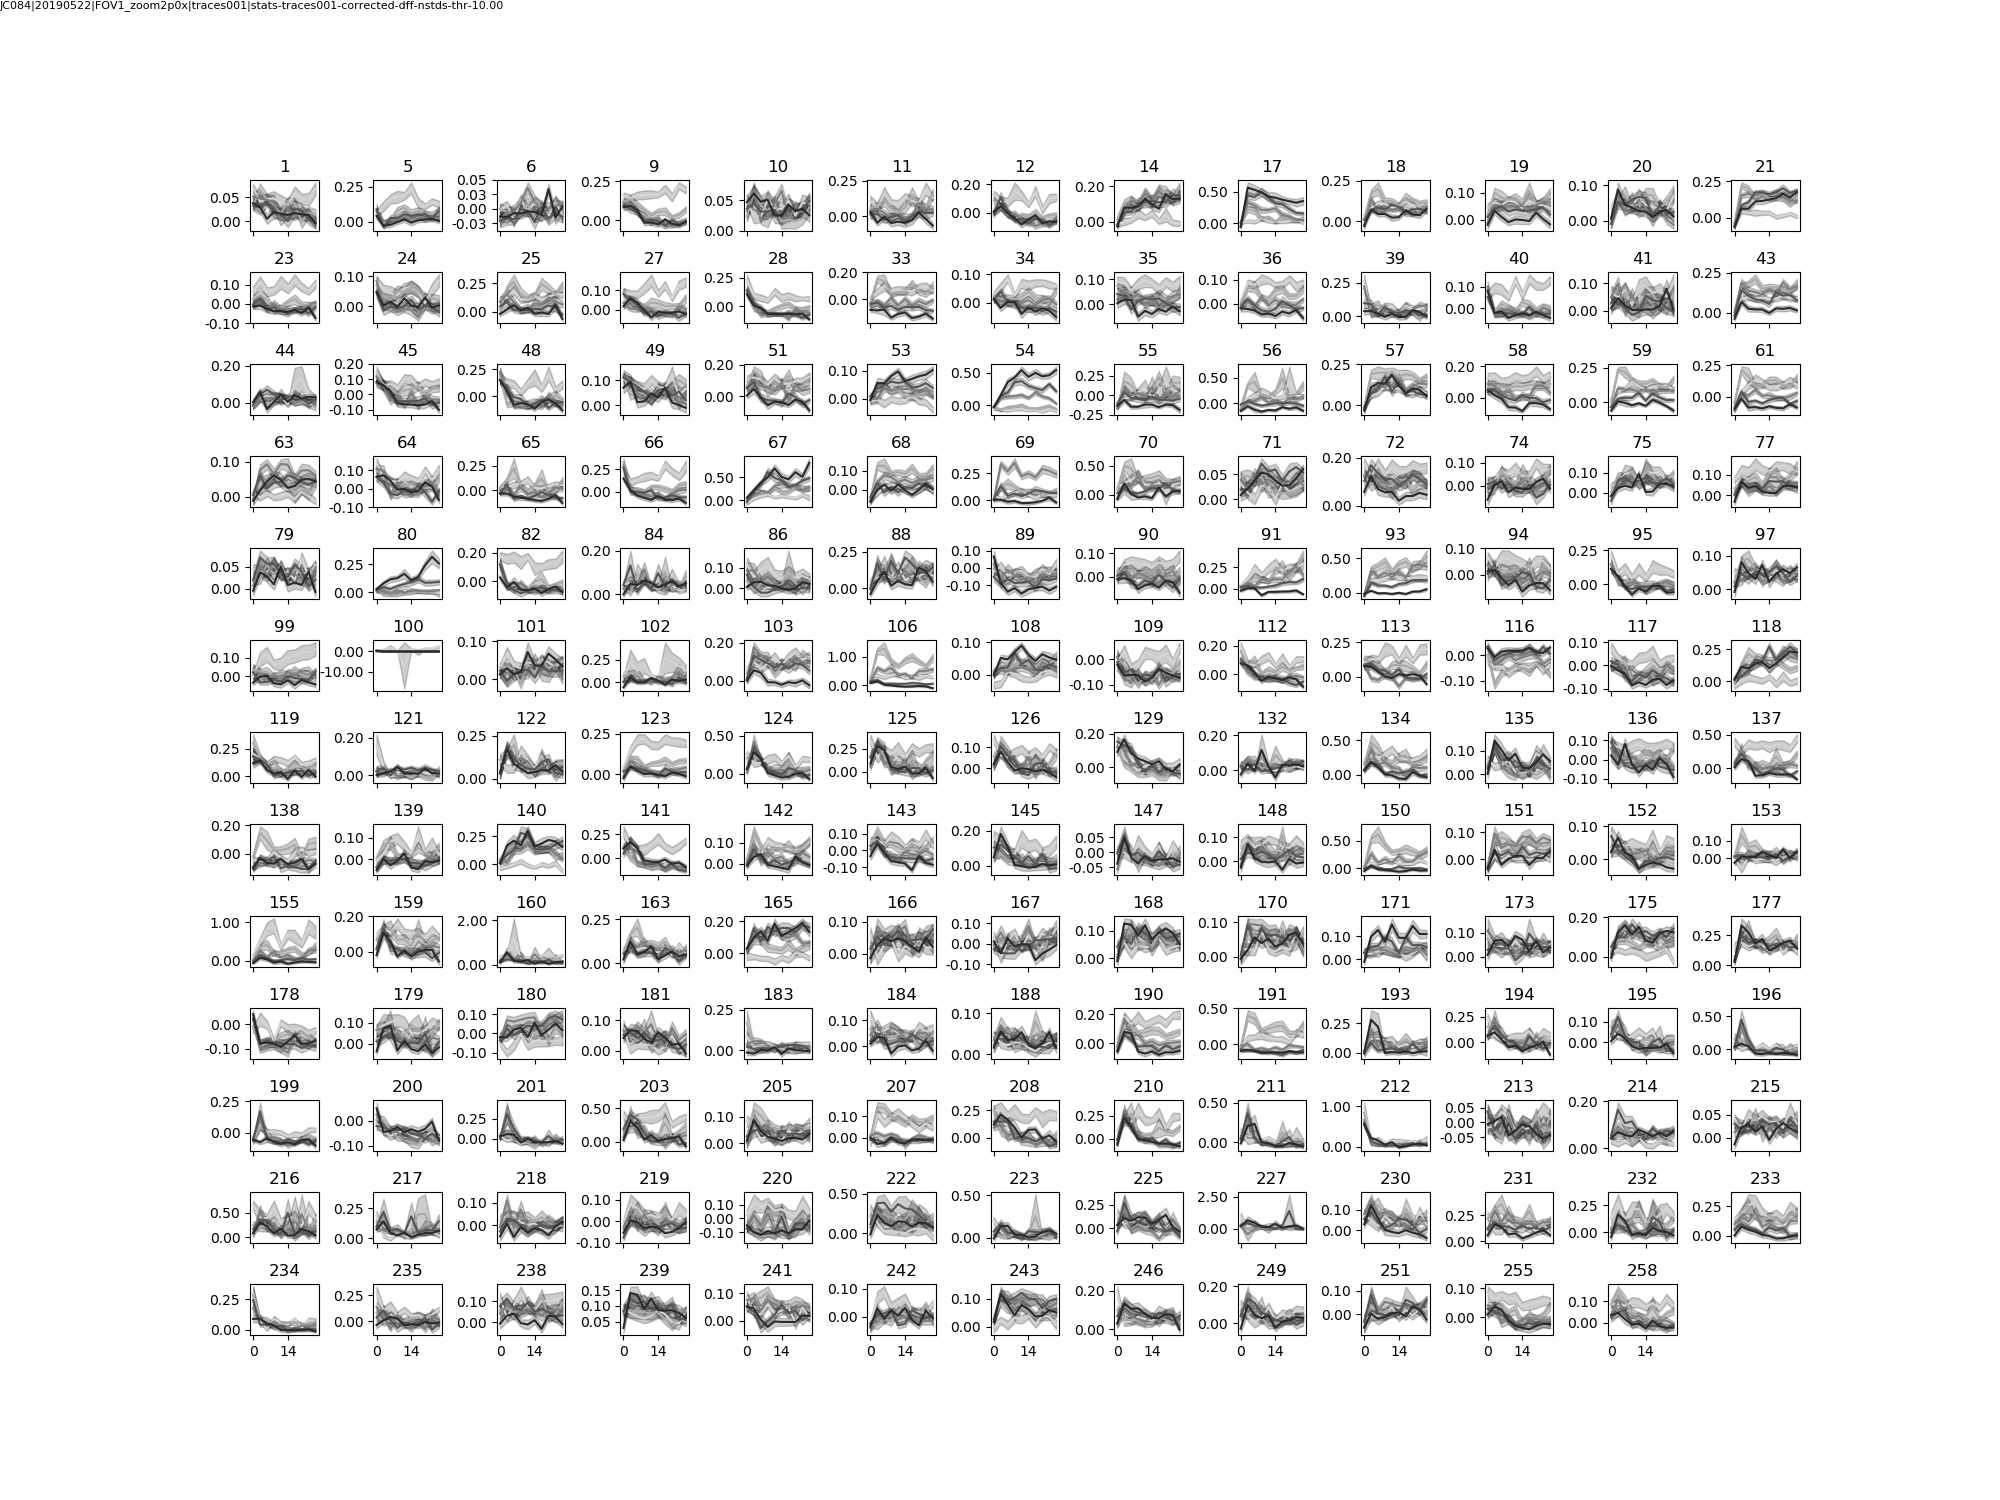

In [26]:

fig = plot_roi_tuning(df_mean, df_sem=df_sem, tune_values=tune_values, tune_name=tune_name,
                     hue_values=hue_values, hue_name=hue_name, hue_colors=hcolors)
# if threshold_dff:
#     figname = '%s-tuning_%s__%s_thr-dff-%.2f_%irois' % (tune_name, visual_area, data_id.replace('|', '_'), min_dff, len(rois_plot))
# else:
#     figname = '%s-tuning_%s__%s_all-resp_%irois' % (tune_name, visual_area, data_id.replace('|', '_'), len(rois_plot))


# Plot ALL datasets

In [240]:
data_id

'JC083|20190511|FOV1_zoom2p0x|traces001|stats-traces001-corrected-dff-nstds-thr-10.00'

In [61]:
len(glob.glob(os.path.join(outdir, 'sessions', 'morph-tuning_%s__%s*.png' % (visual_area, data_id.replace('|', '_')))))

1

... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blo

<IPython.core.display.Javascript object>


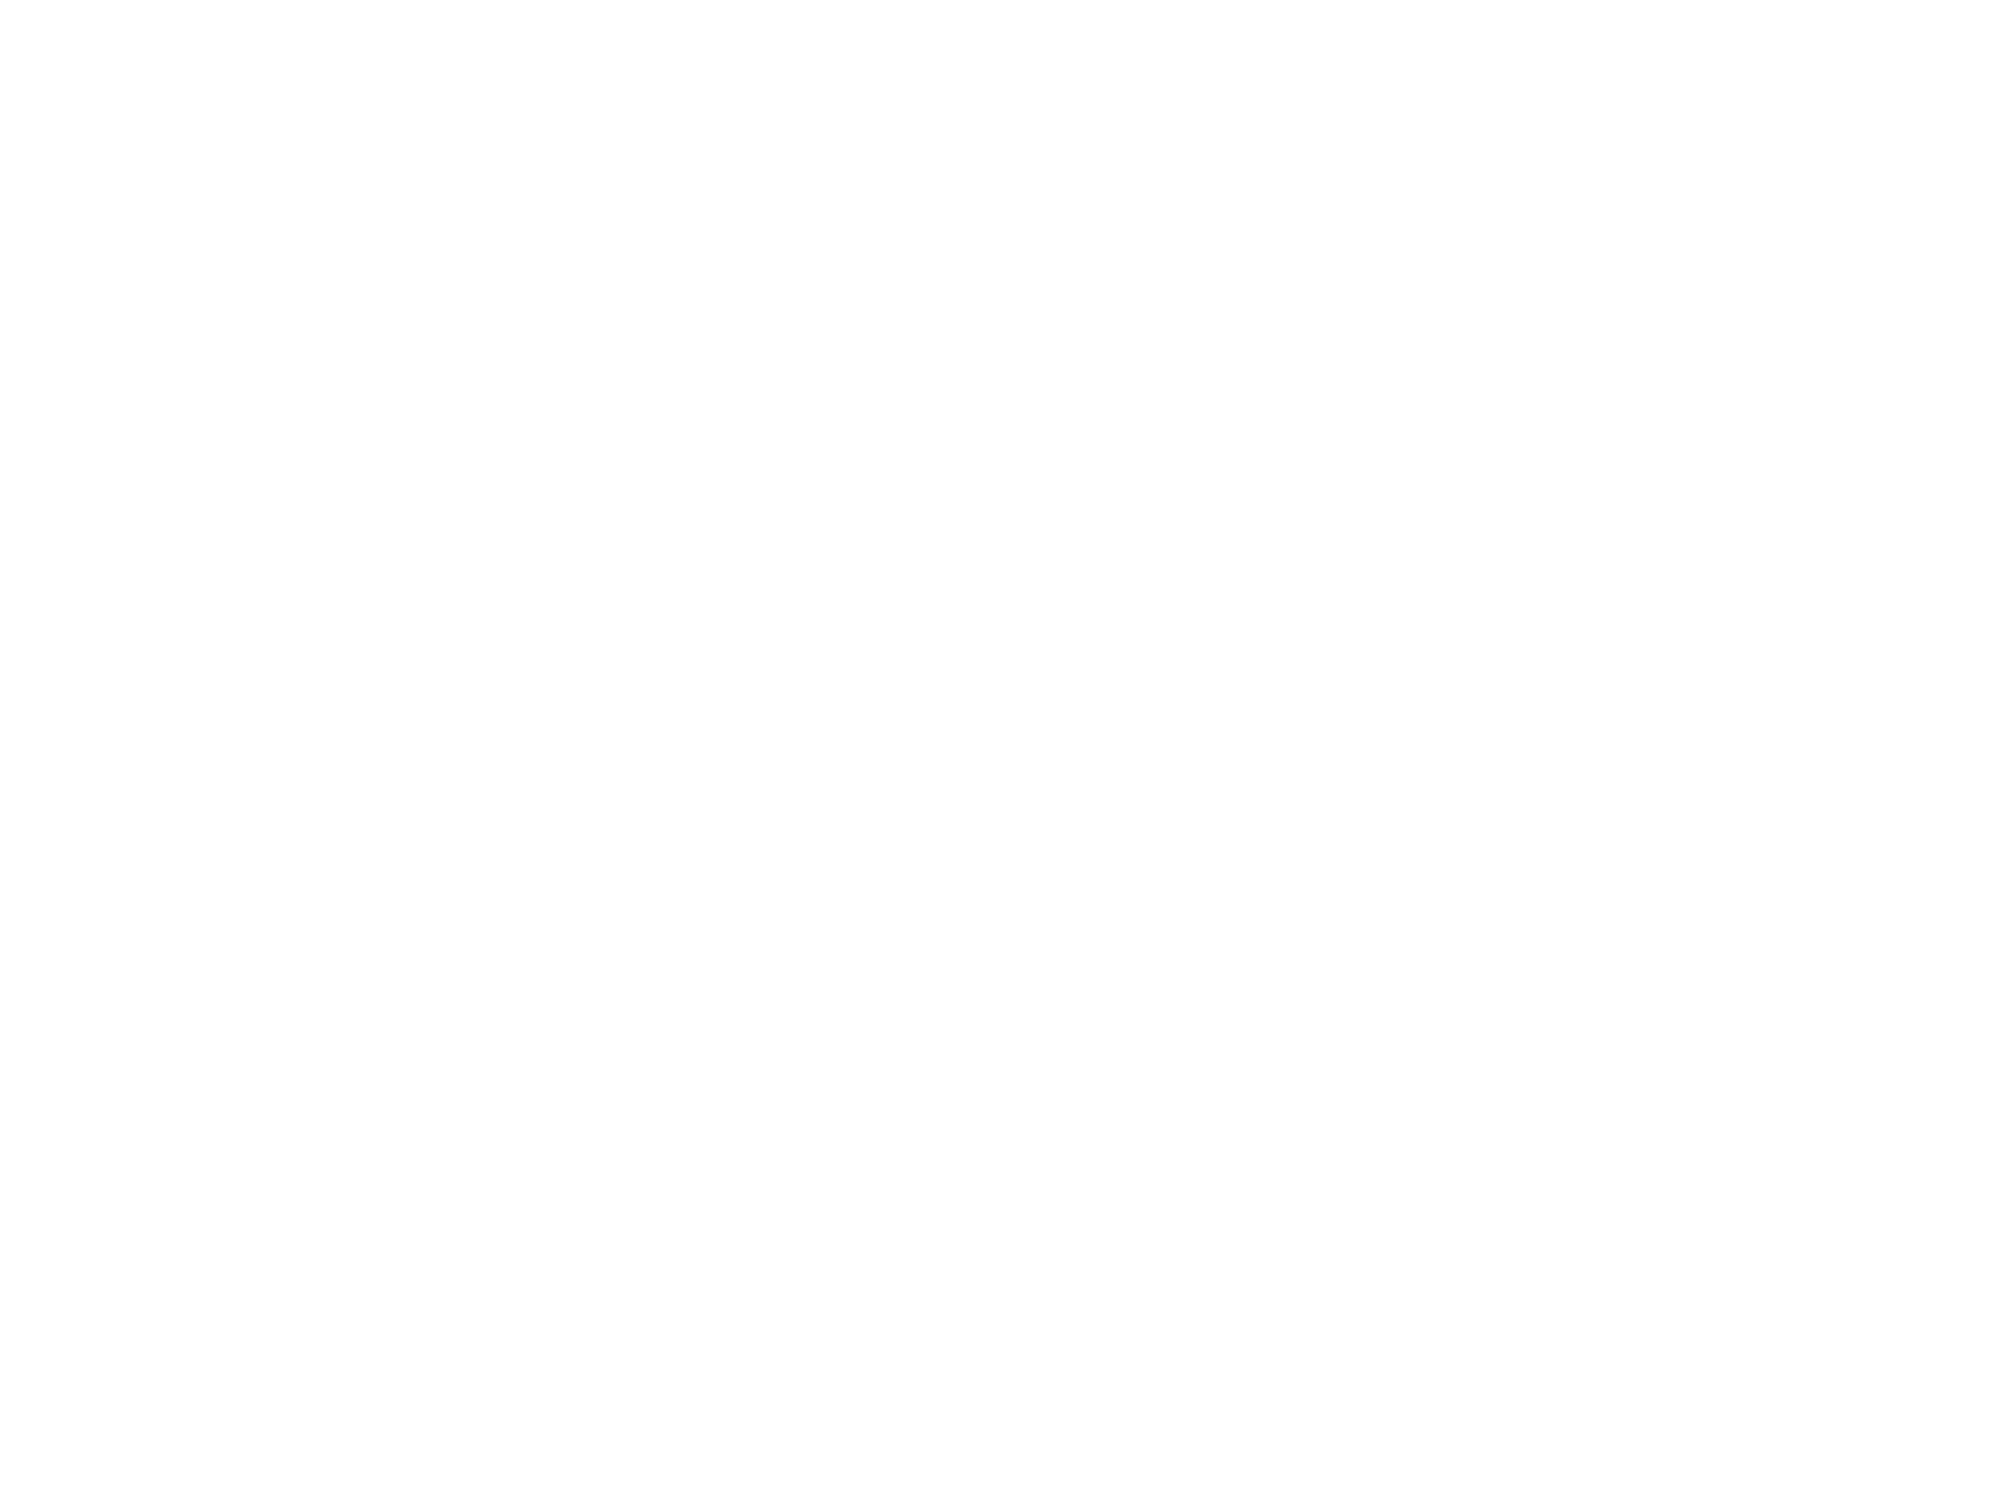

morph-tuning_Lm__JC078_20190430_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_152-of-185rois
... [JC078|20190504|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 368.74
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 155 of 188 responsive cells.
N rois to plot: 155
(12, 13)


<IPython.core.display.Javascript object>


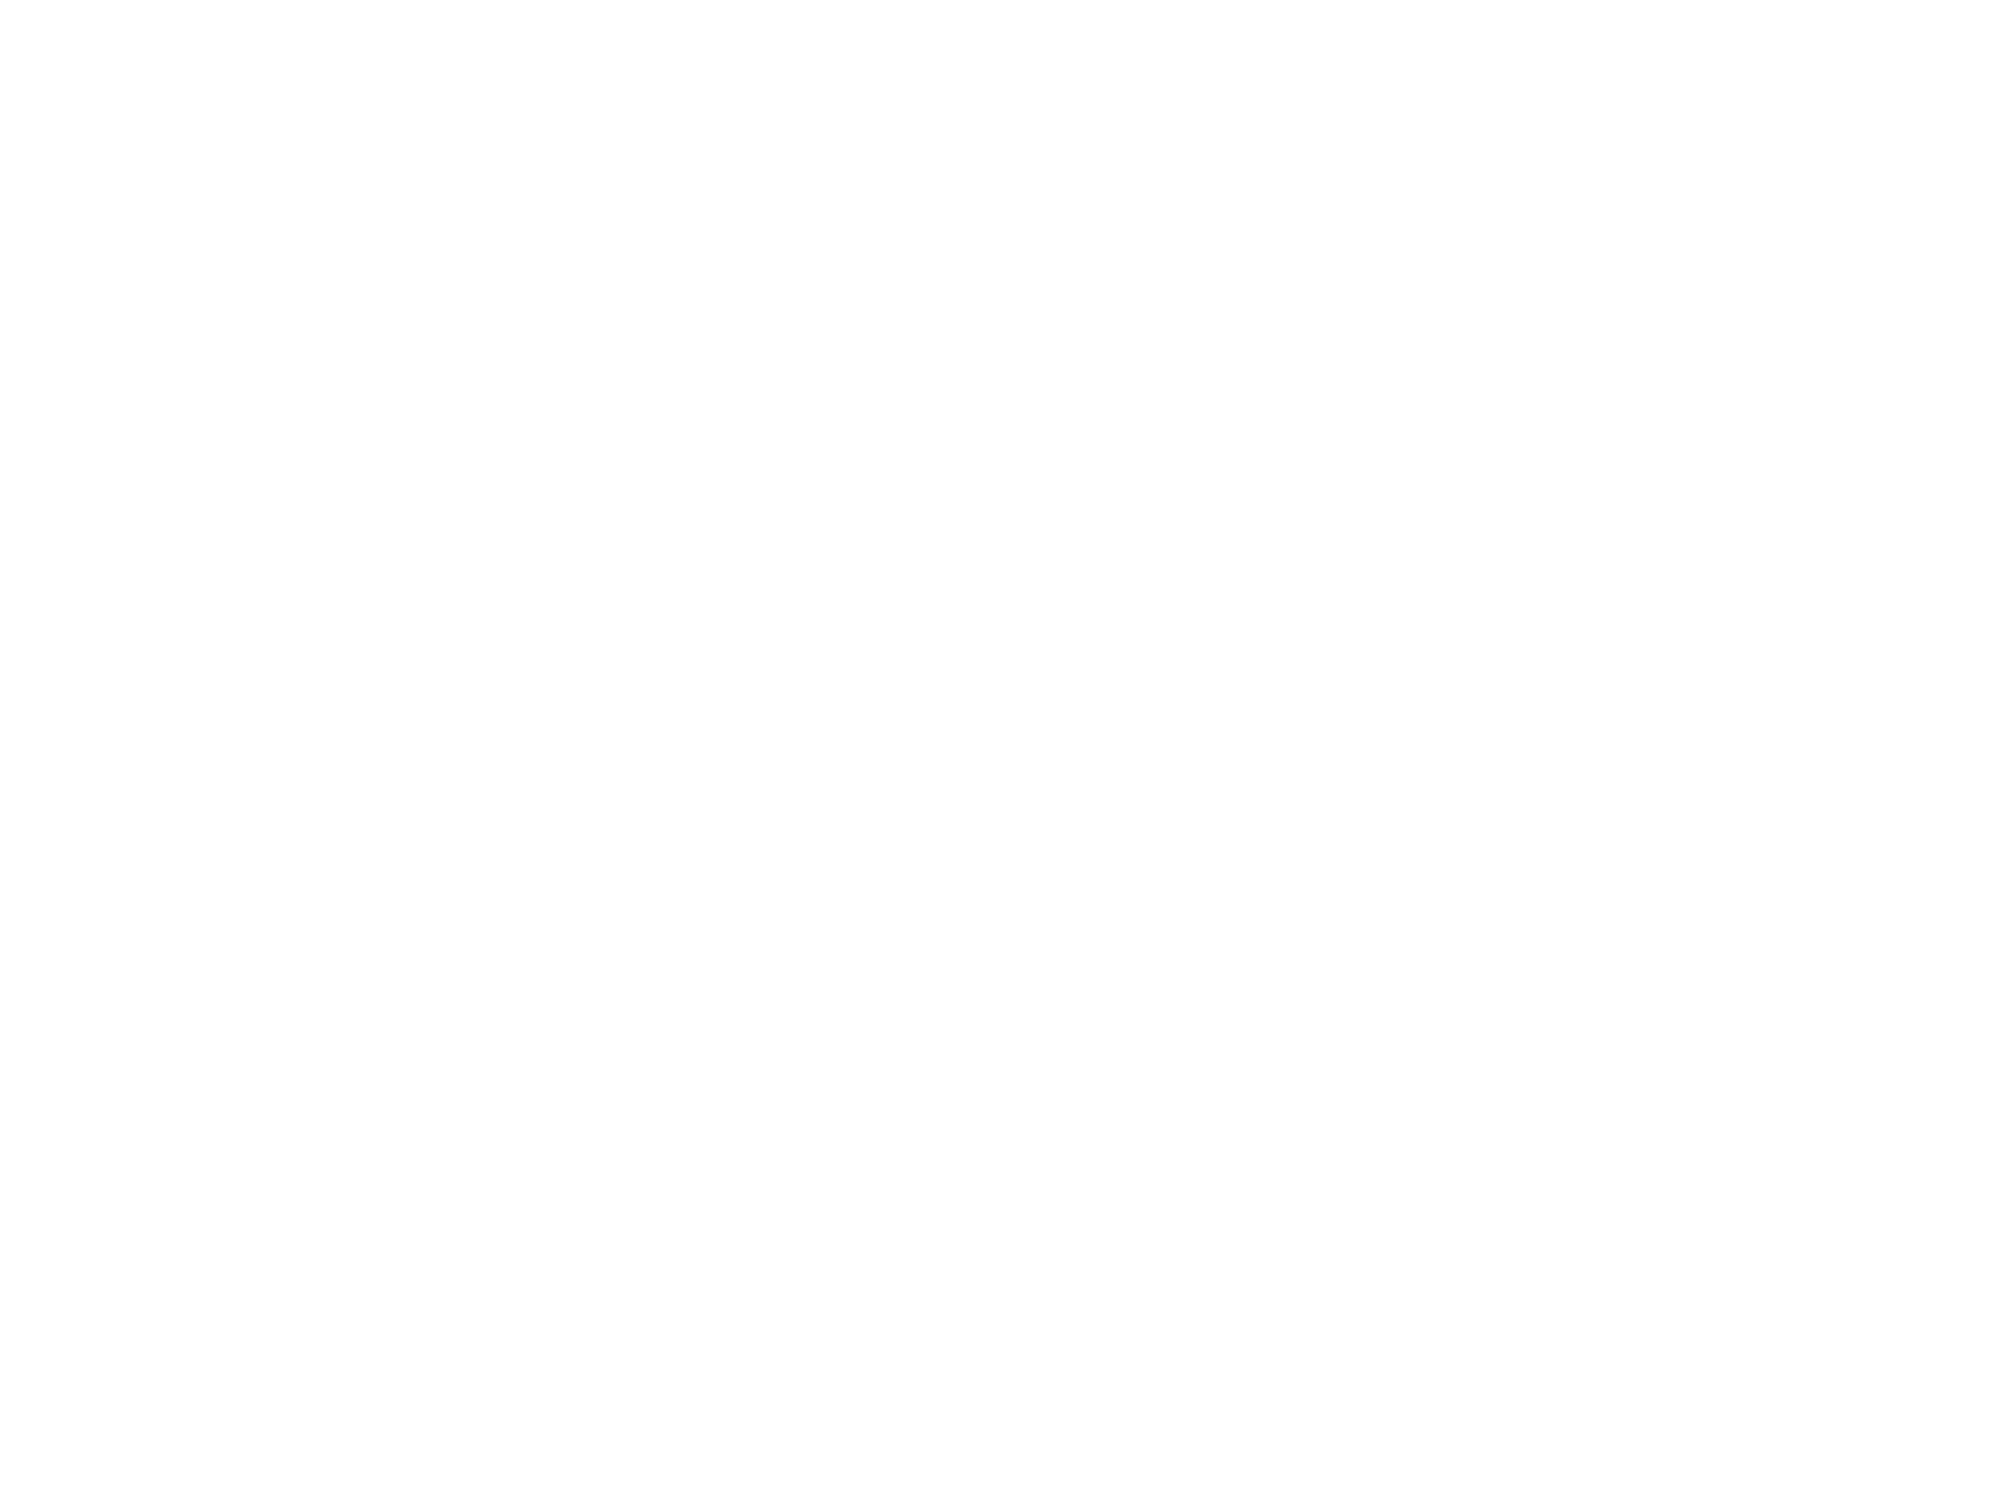

morph-tuning_Lm__JC078_20190504_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_155-of-188rois
... [JC078|20190509|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 329.04
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 123 of 165 responsive cells.
N rois to plot: 123
(11, 12)


<IPython.core.display.Javascript object>


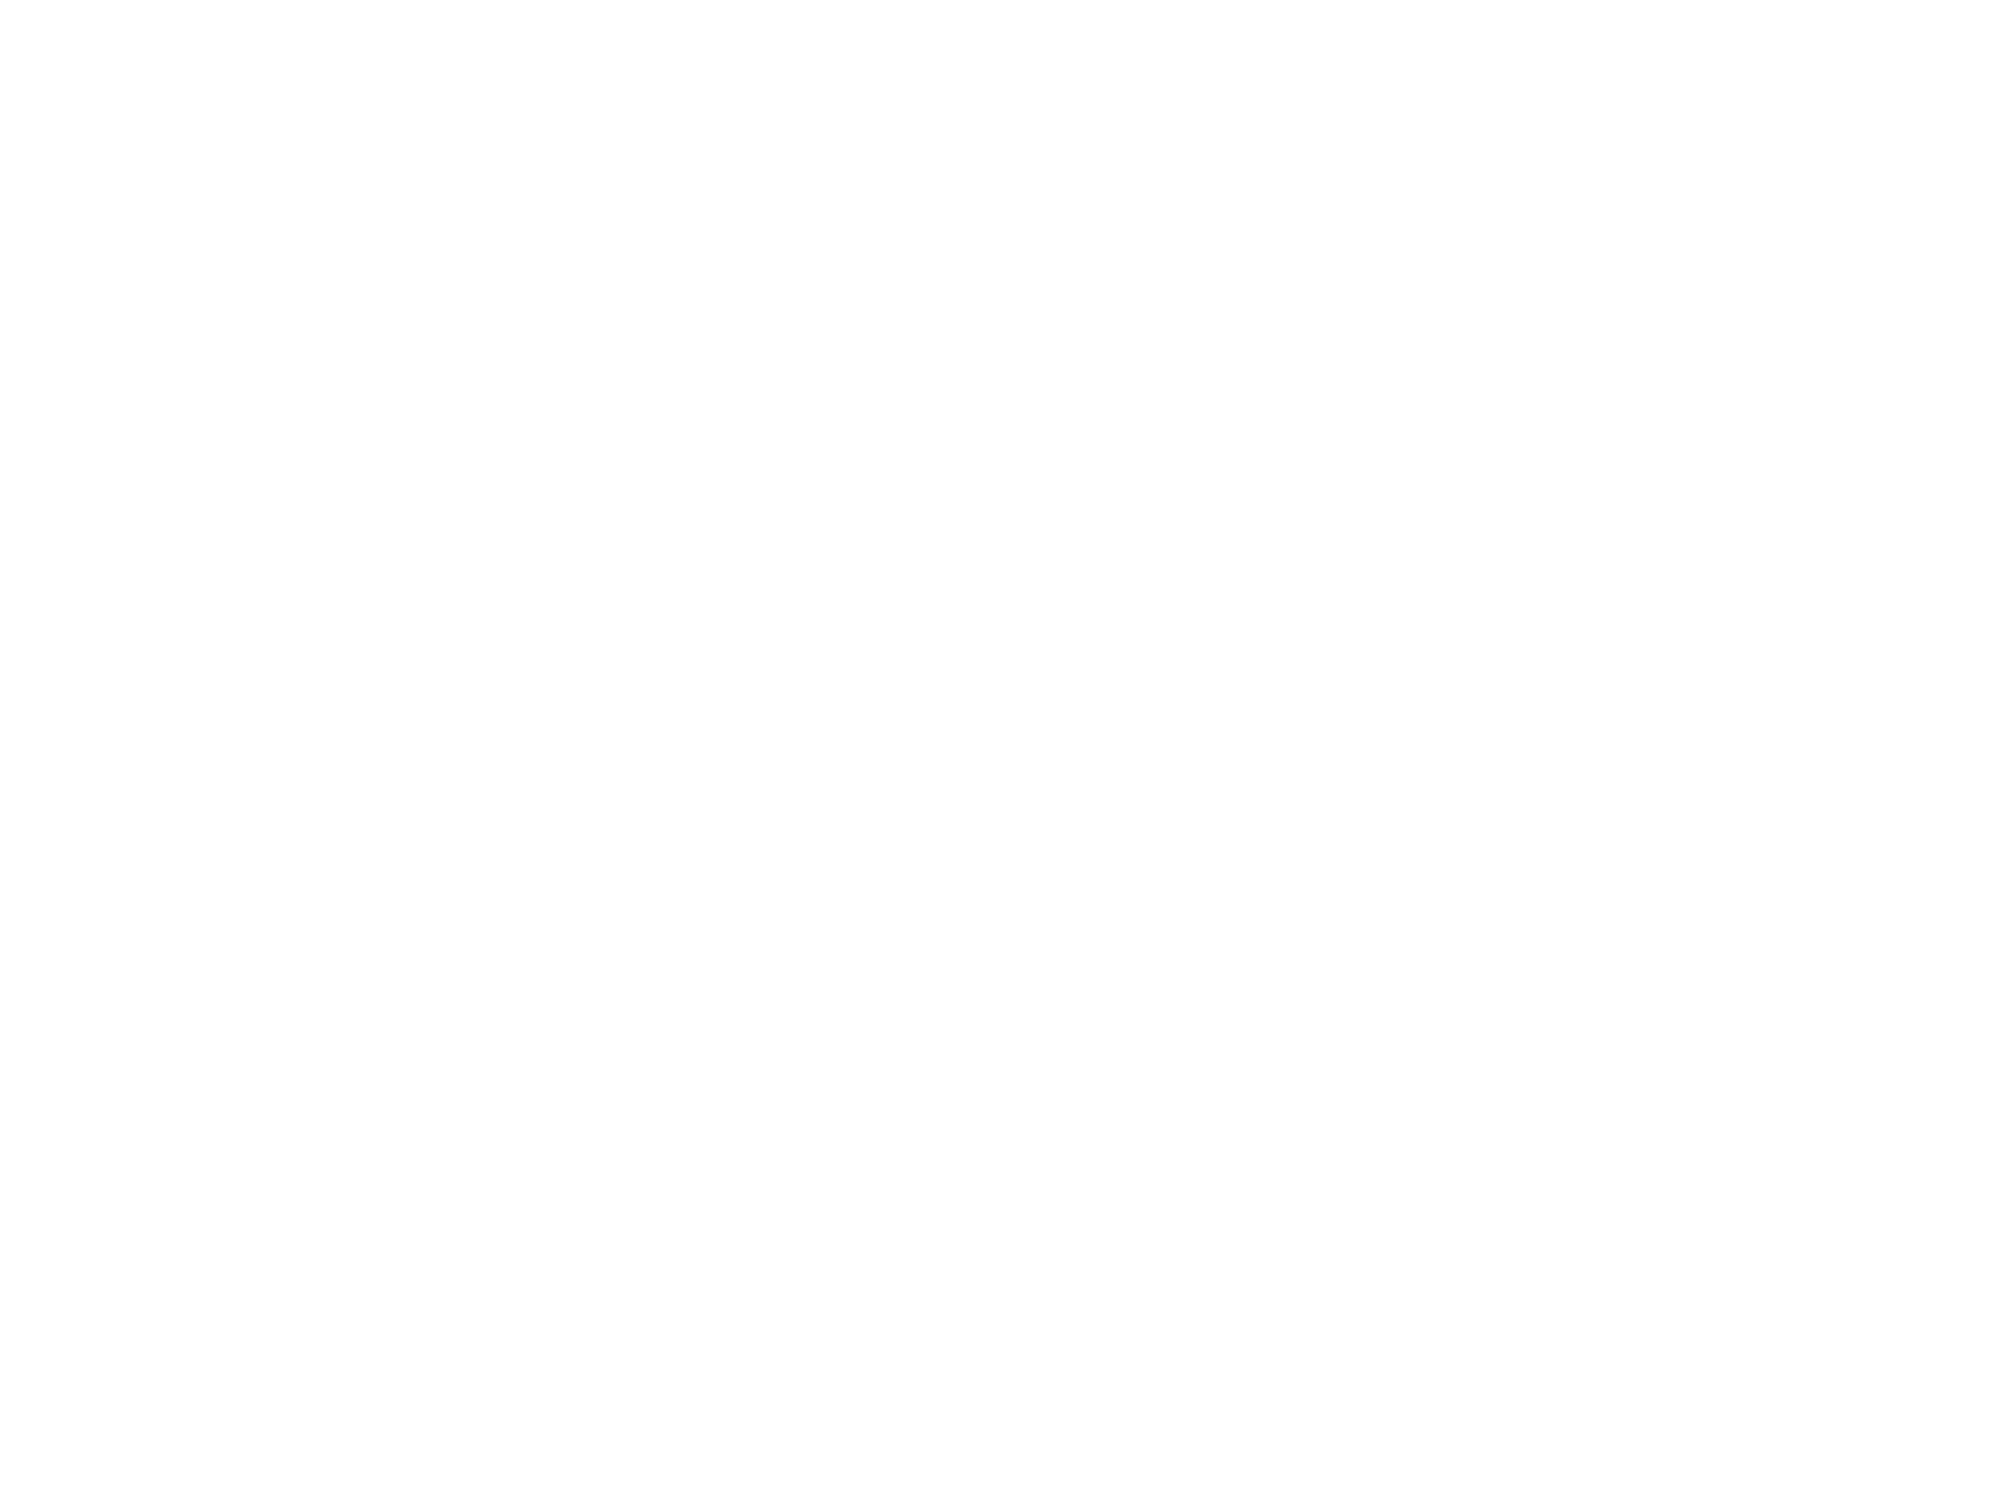

morph-tuning_Lm__JC078_20190509_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_123-of-165rois
... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 422.91
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 138 of 177 responsive cells.
N rois to plot: 138
(12, 12)


<IPython.core.display.Javascript object>


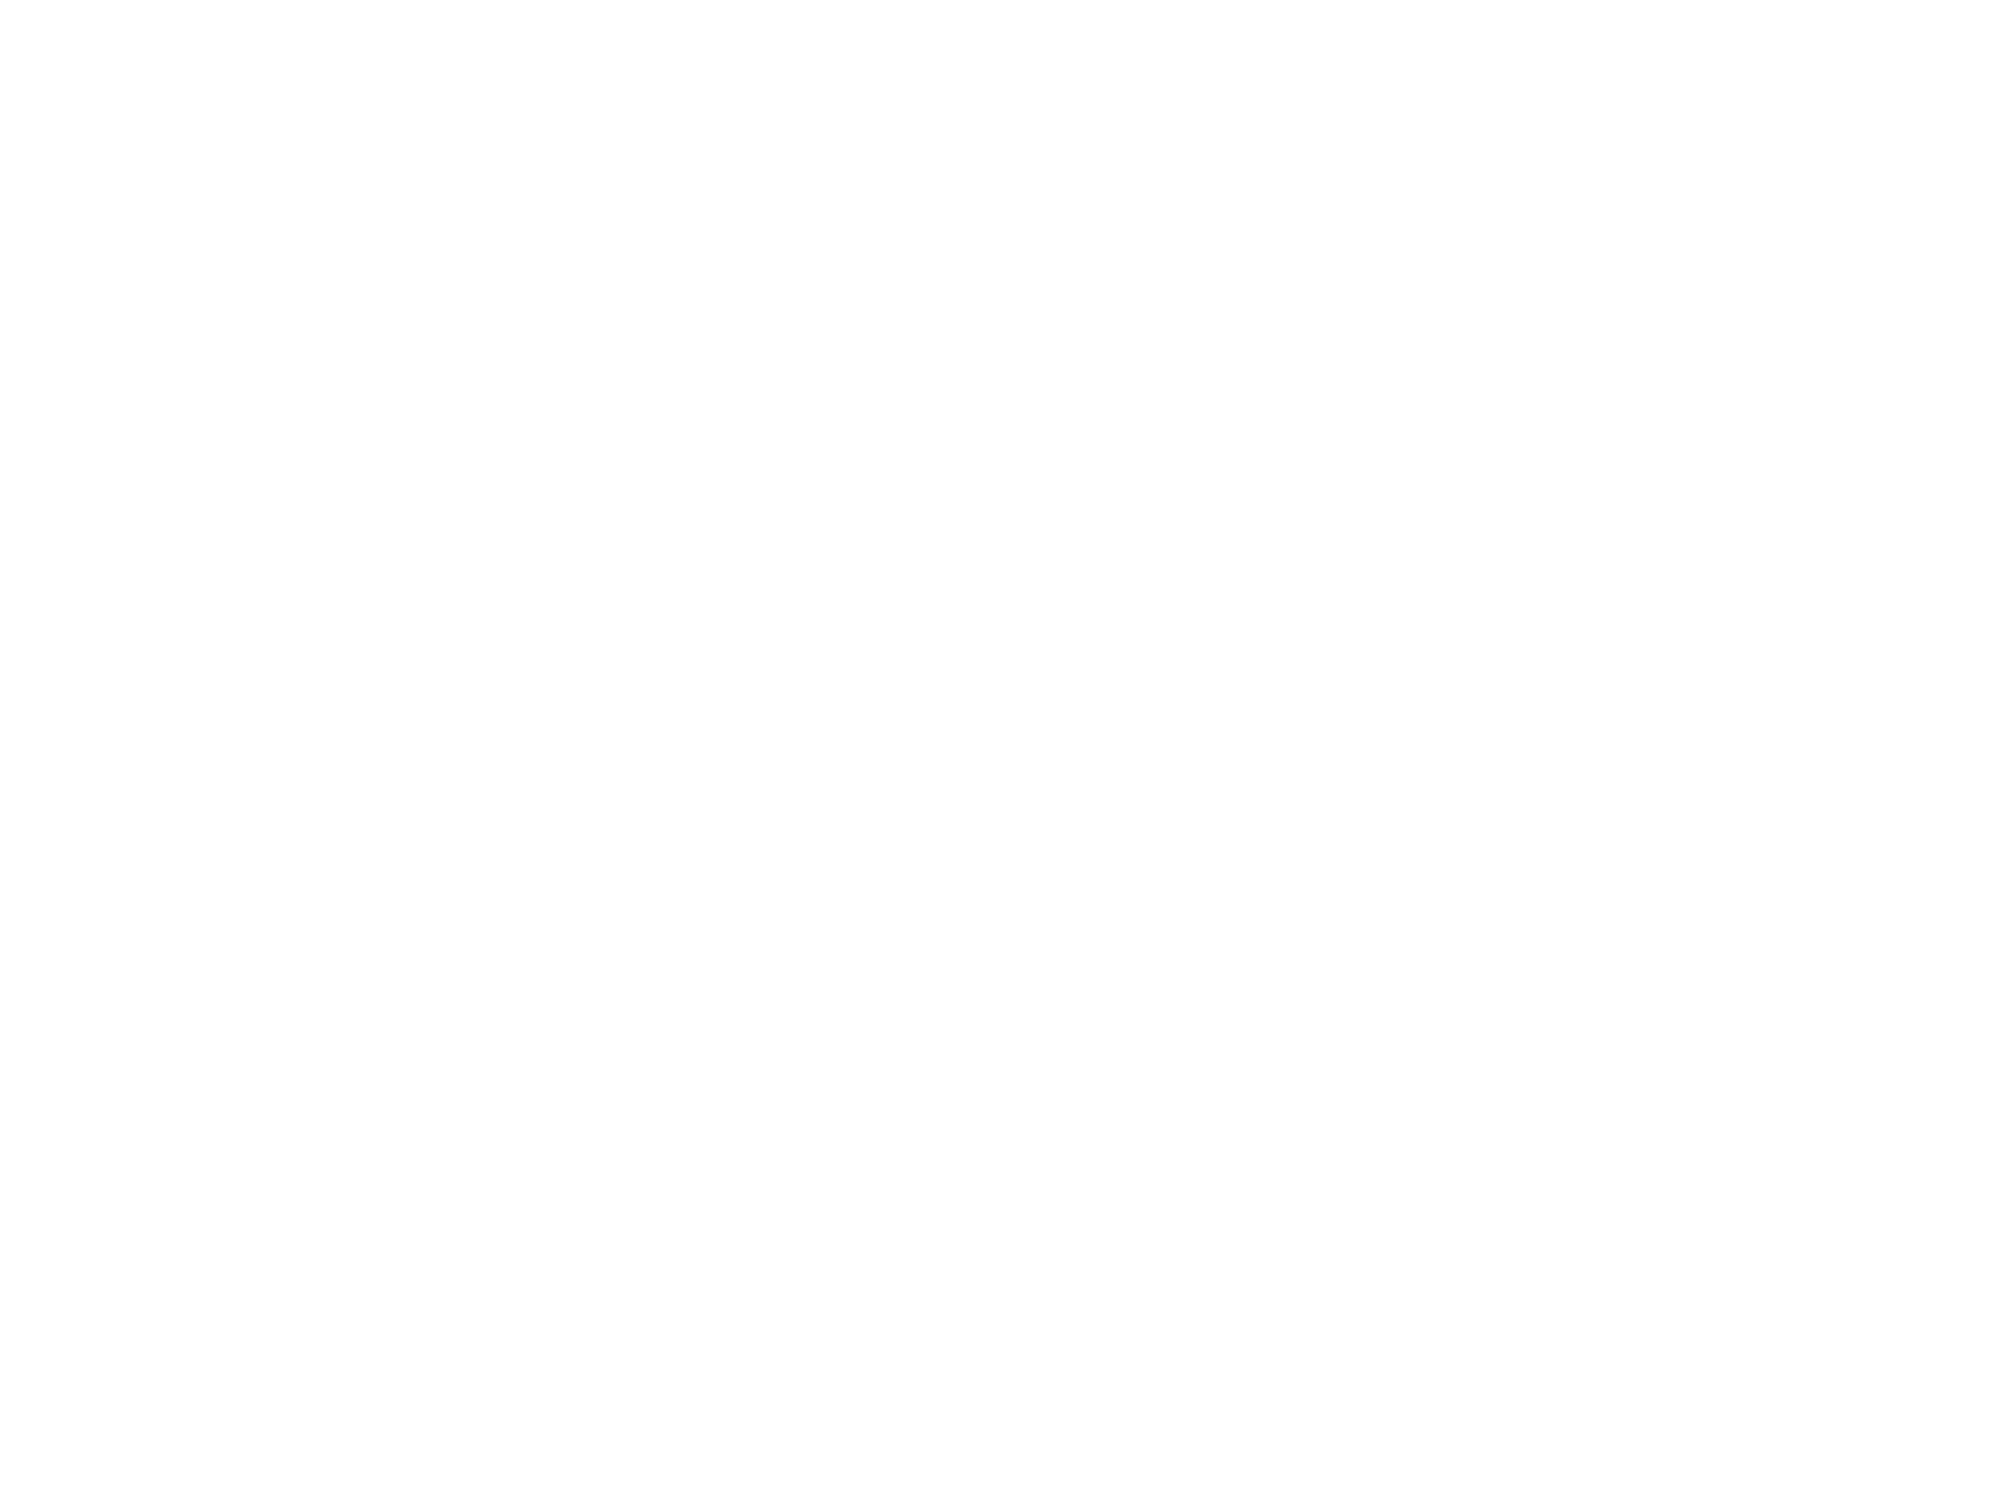

morph-tuning_Lm__JC078_20190513_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_138-of-177rois
... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 423.89
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 196 of 225 responsive cells.
N rois to plot: 196
(14, 14)


<IPython.core.display.Javascript object>


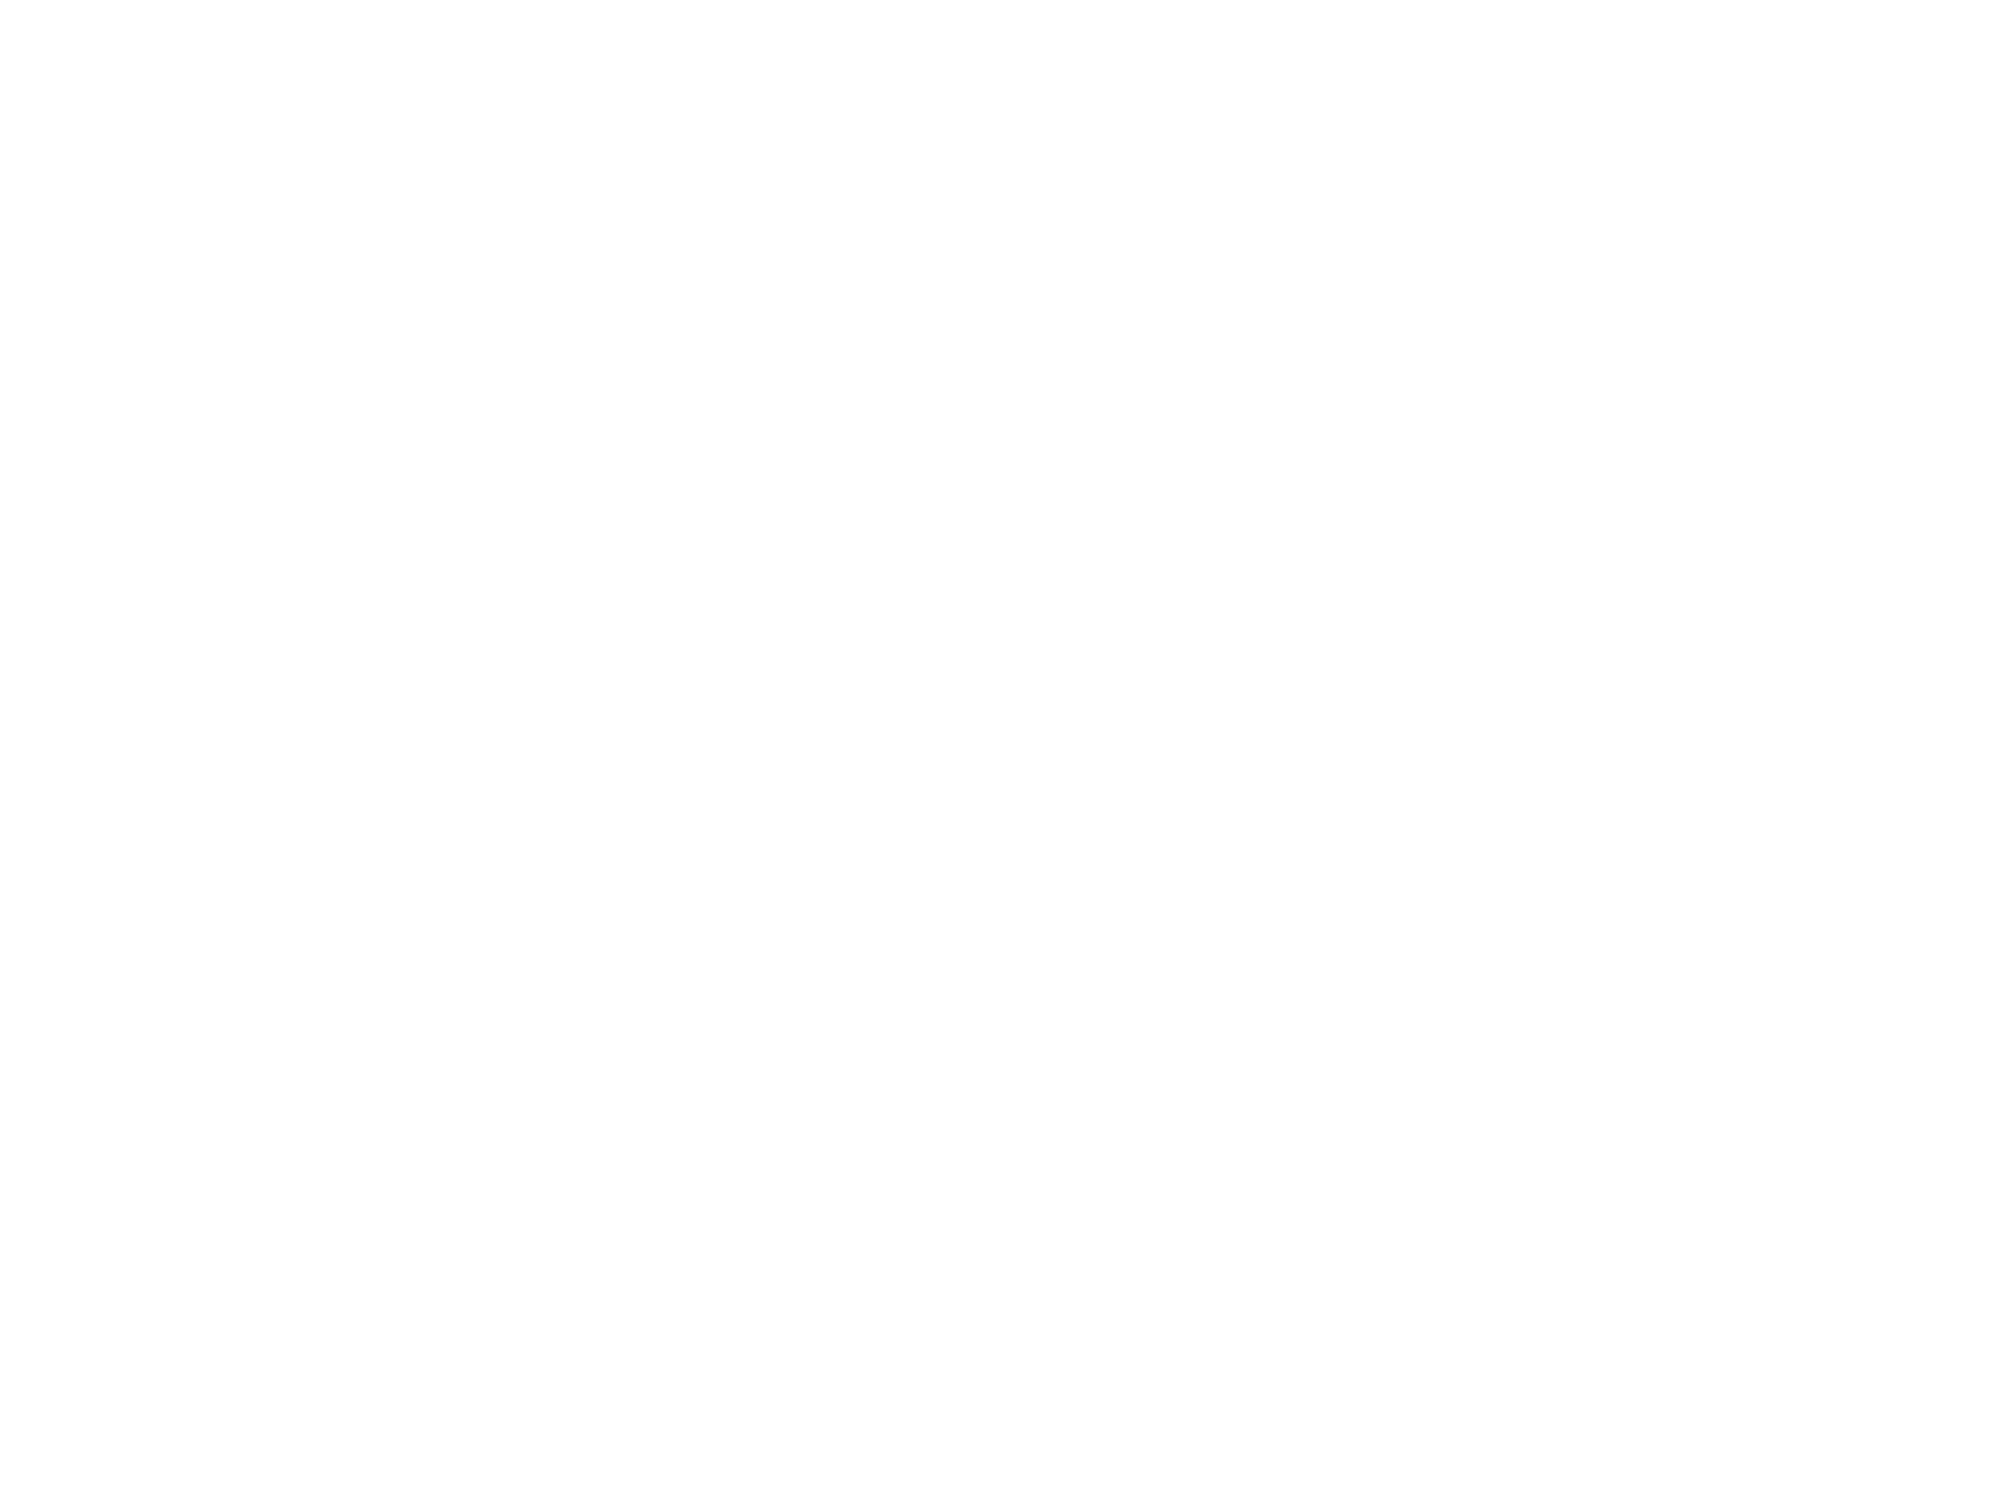

morph-tuning_Lm__JC080_20190506_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_196-of-225rois
... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 573.12
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 167 of 226 responsive cells.
N rois to plot: 167
(13, 13)


<IPython.core.display.Javascript object>


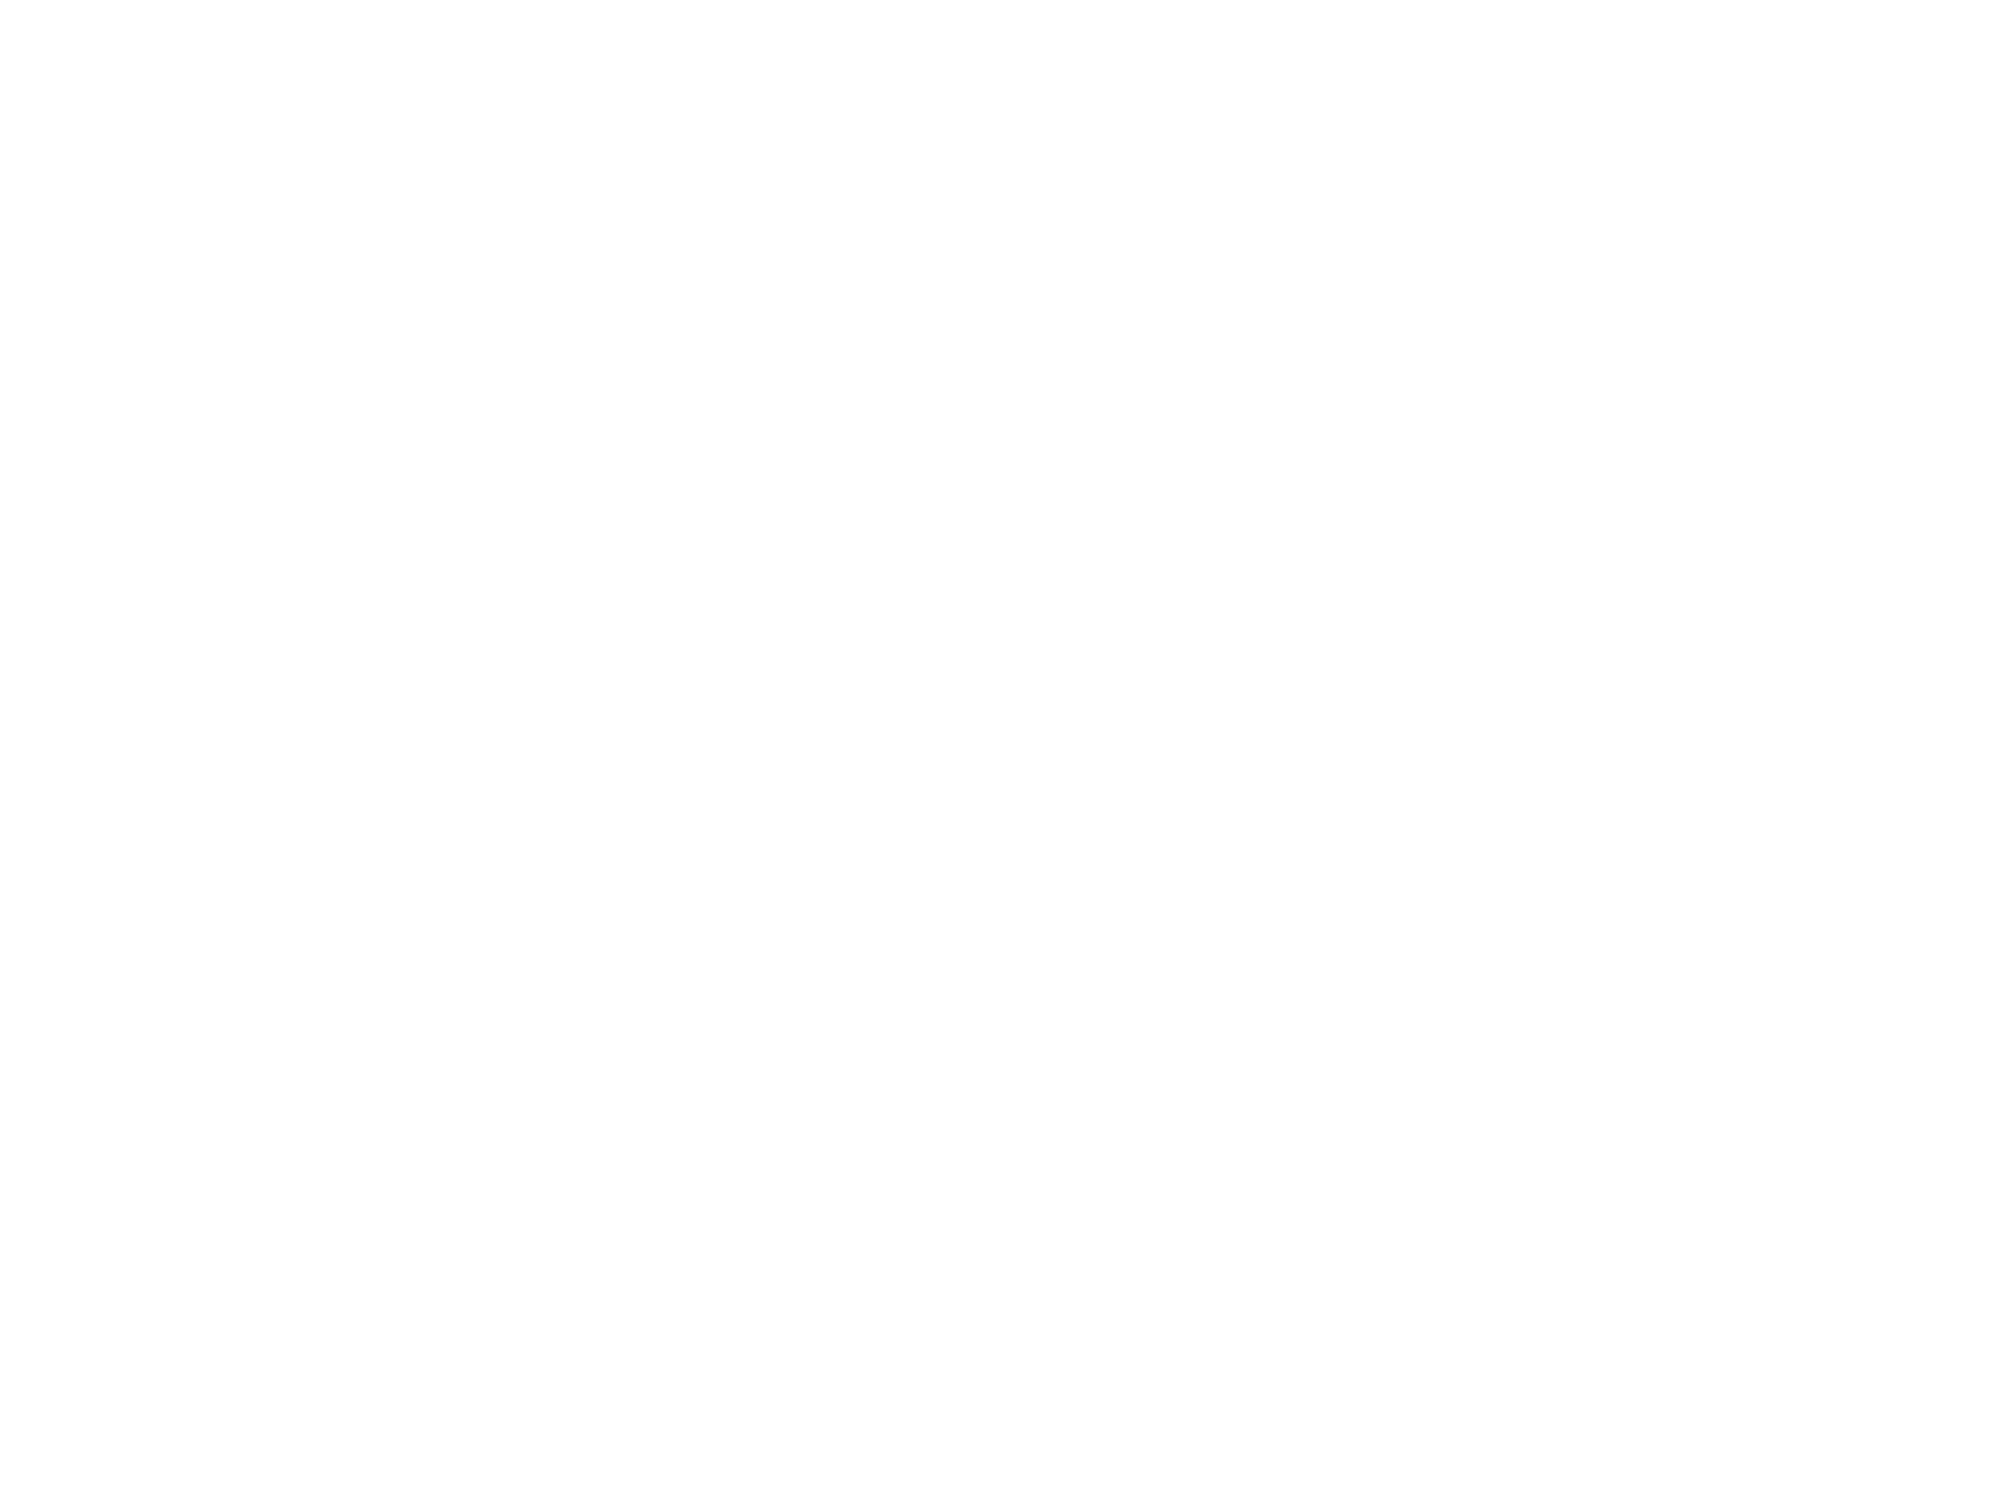

morph-tuning_Lm__JC080_20190603_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_167-of-226rois
... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 516.48
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 129 of 171 responsive cells.
N rois to plot: 129
(11, 12)


<IPython.core.display.Javascript object>


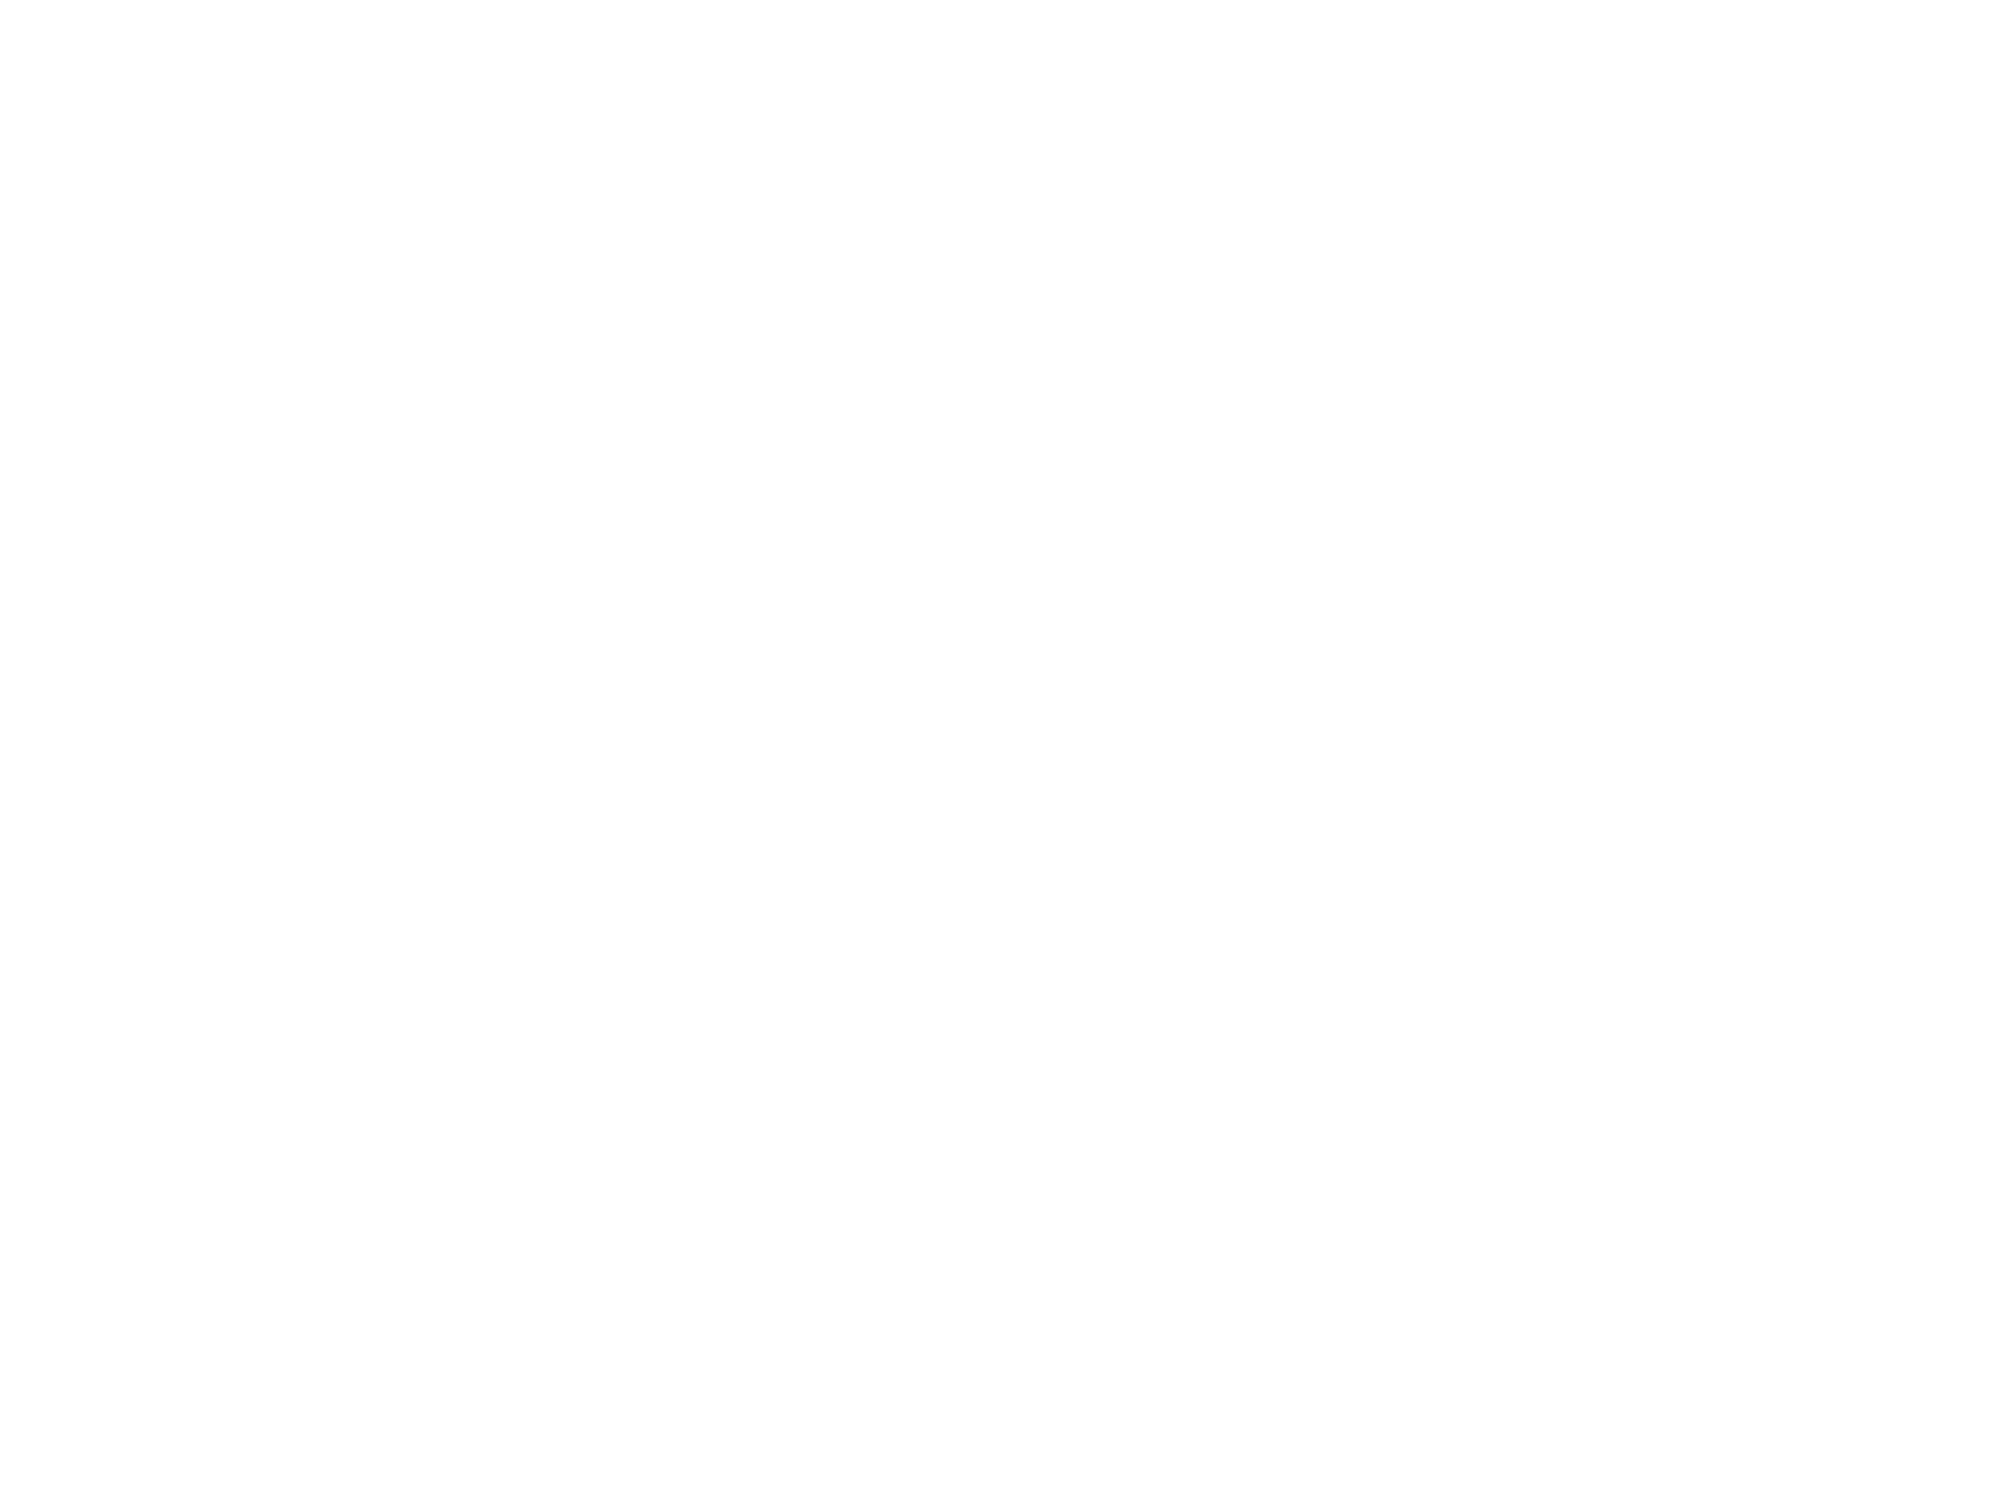

morph-tuning_Lm__JC083_20190508_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_129-of-171rois
... [JC083|20190512|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 582.17
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 142 of 266 responsive cells.
N rois to plot: 142
(12, 12)


<IPython.core.display.Javascript object>


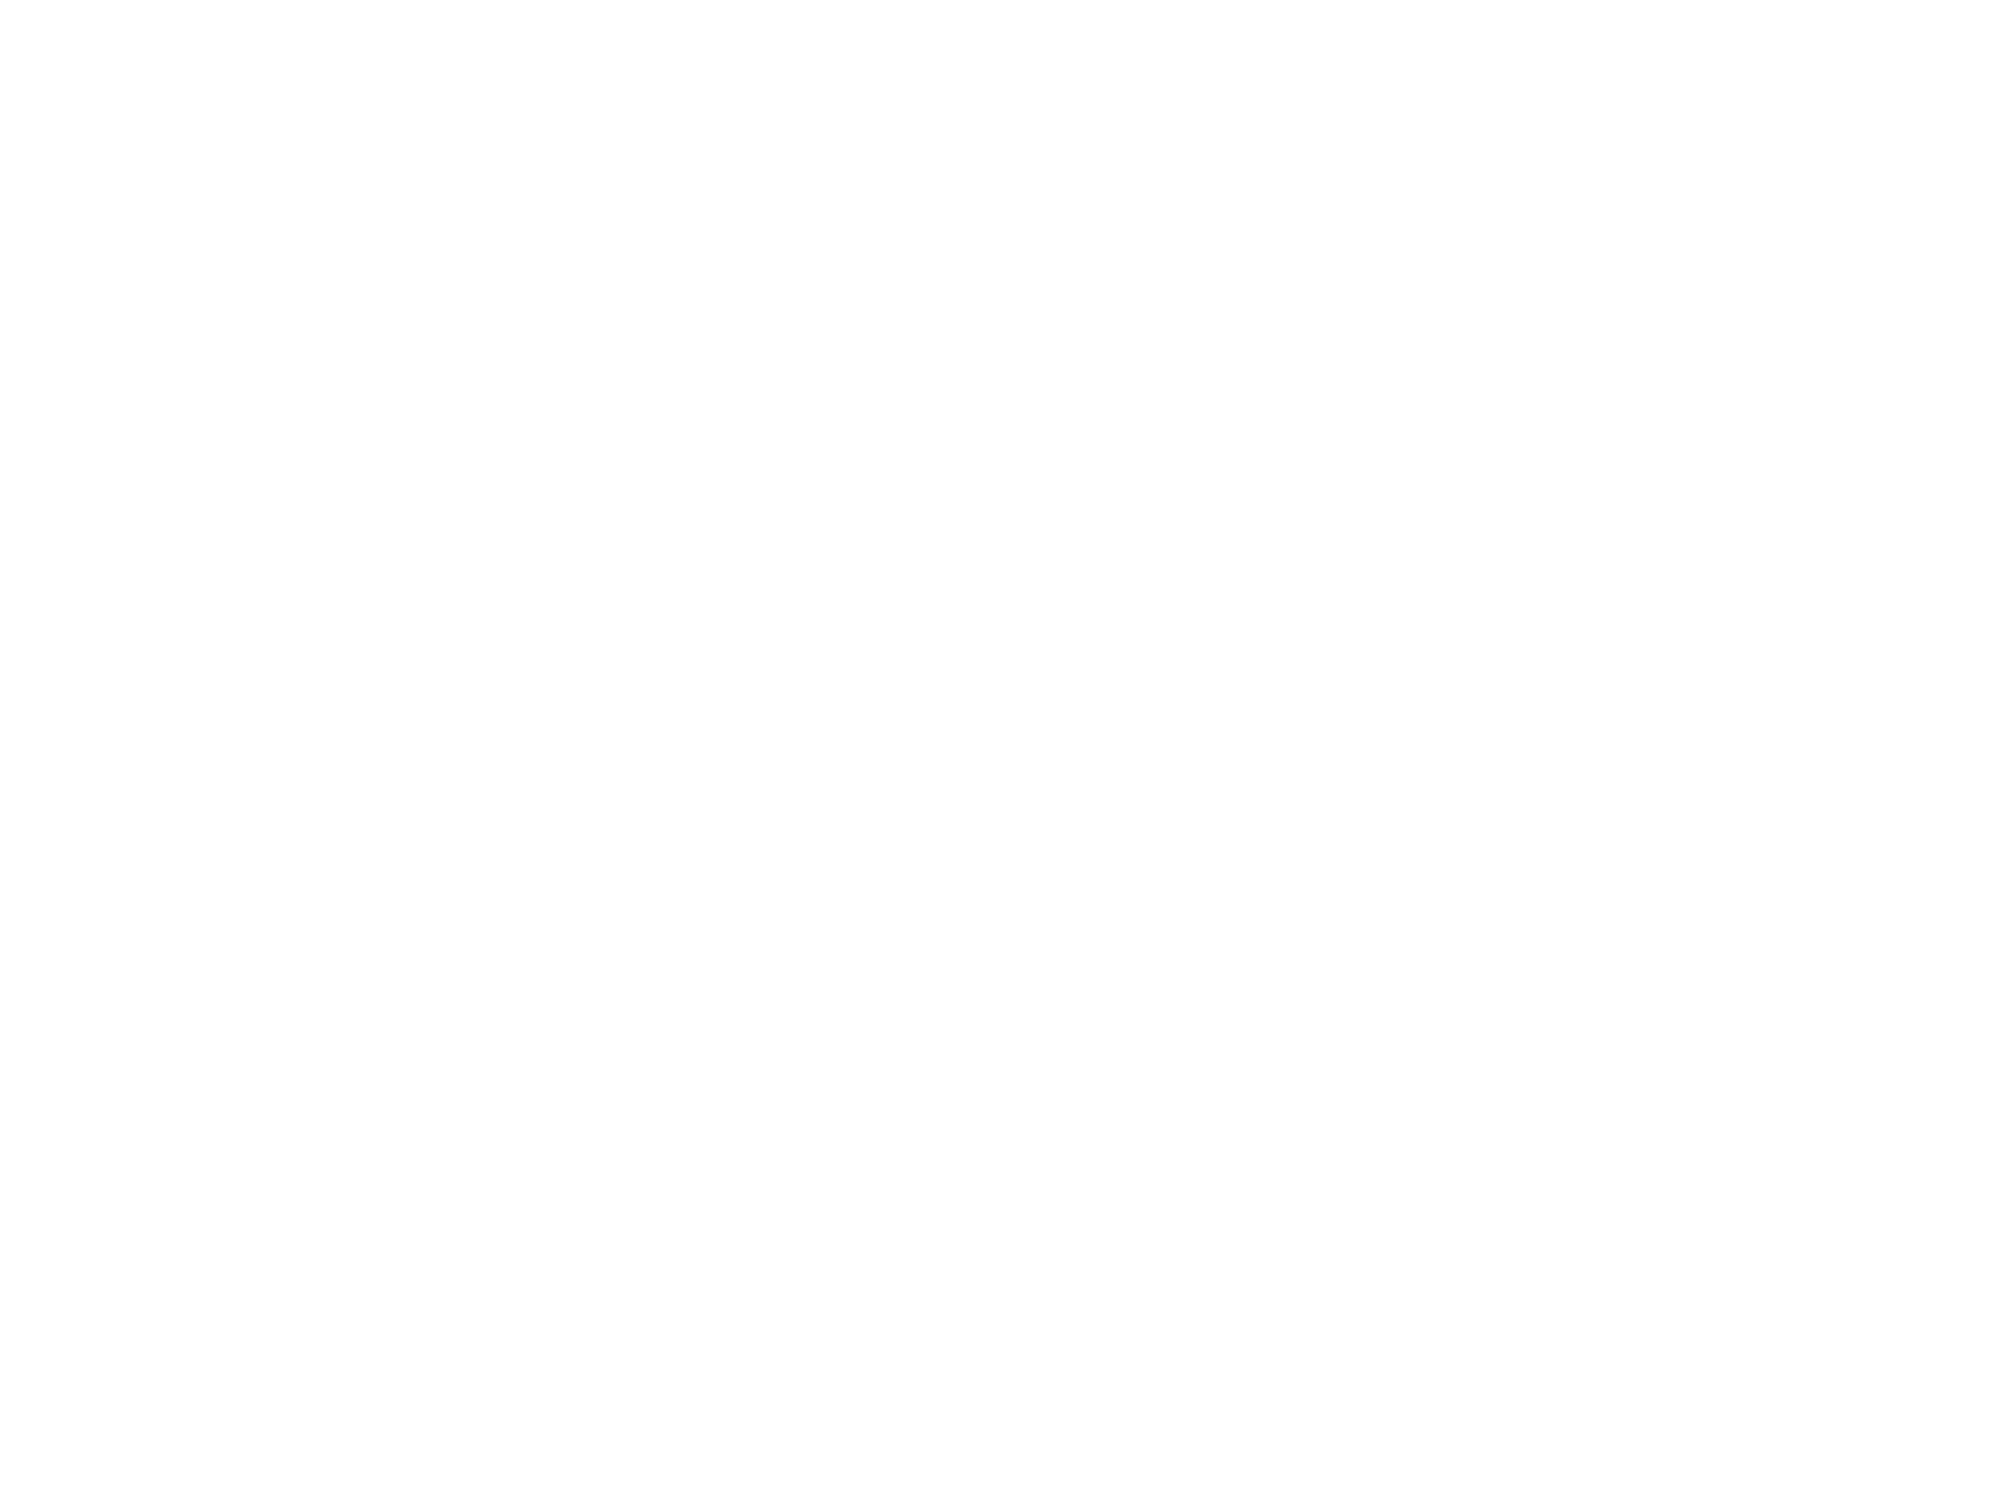

morph-tuning_Lm__JC083_20190512_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_142-of-266rois
... [JC083|20190517|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 501.39
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 111 of 133 responsive cells.
N rois to plot: 111
(11, 11)


<IPython.core.display.Javascript object>


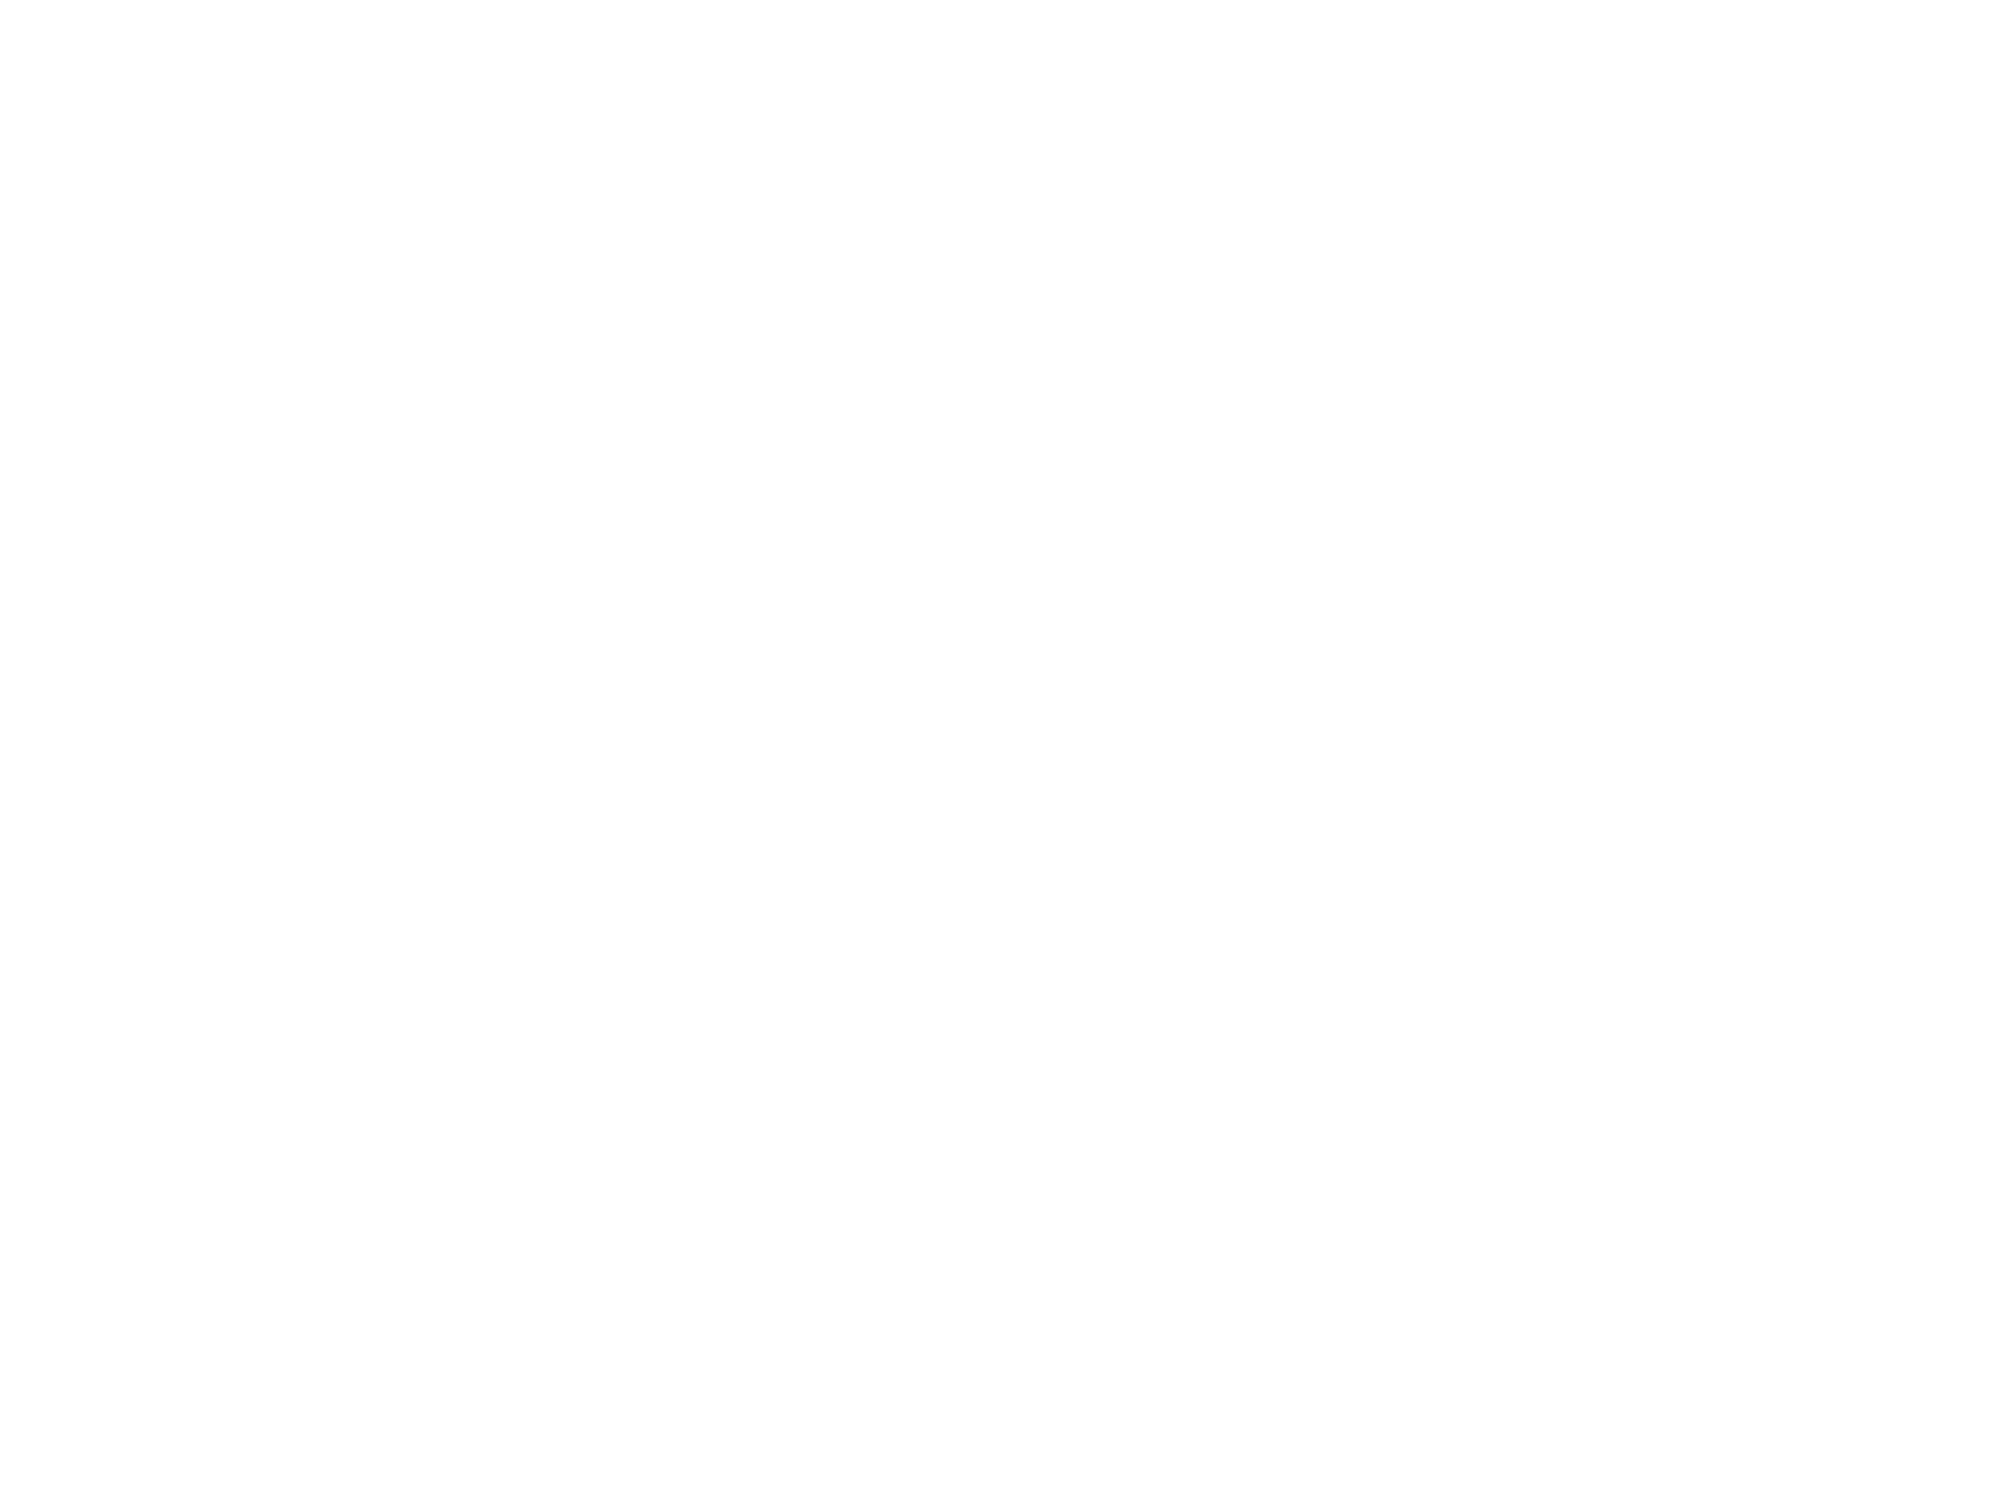

morph-tuning_Lm__JC083_20190517_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_111-of-133rois
... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 289.08
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 143 of 160 responsive cells.
N rois to plot: 143
(12, 12)


<IPython.core.display.Javascript object>


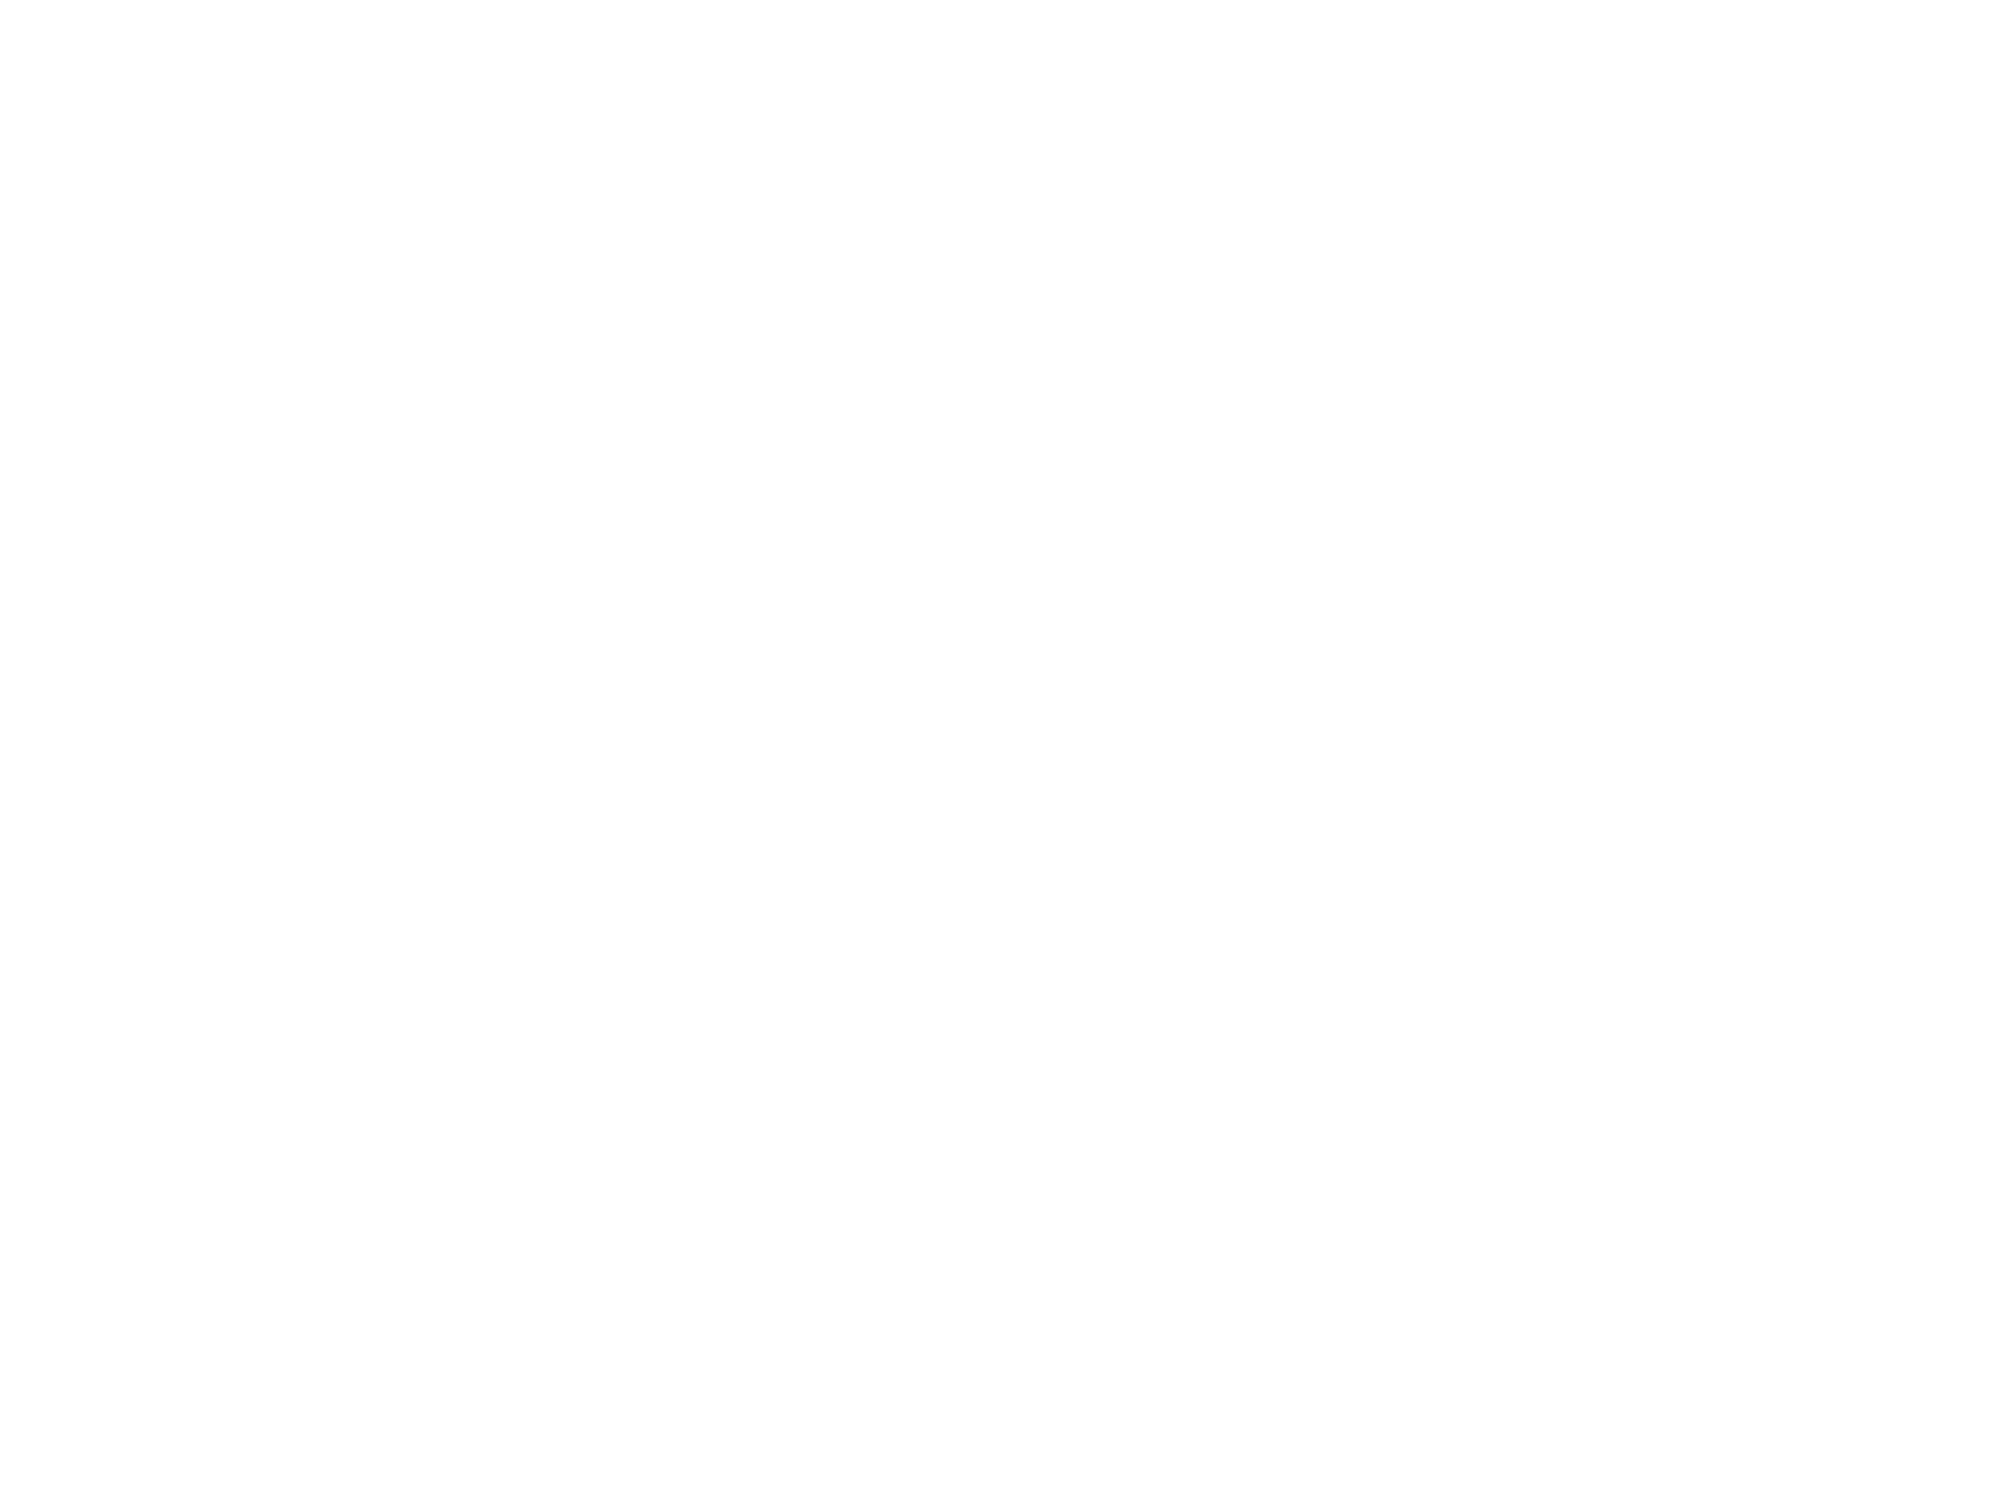

morph-tuning_Lm__JC084_20190525_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_143-of-160rois
... [JC091|20190627|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 363.42
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 155 of 170 responsive cells.
N rois to plot: 155
(12, 13)


<IPython.core.display.Javascript object>


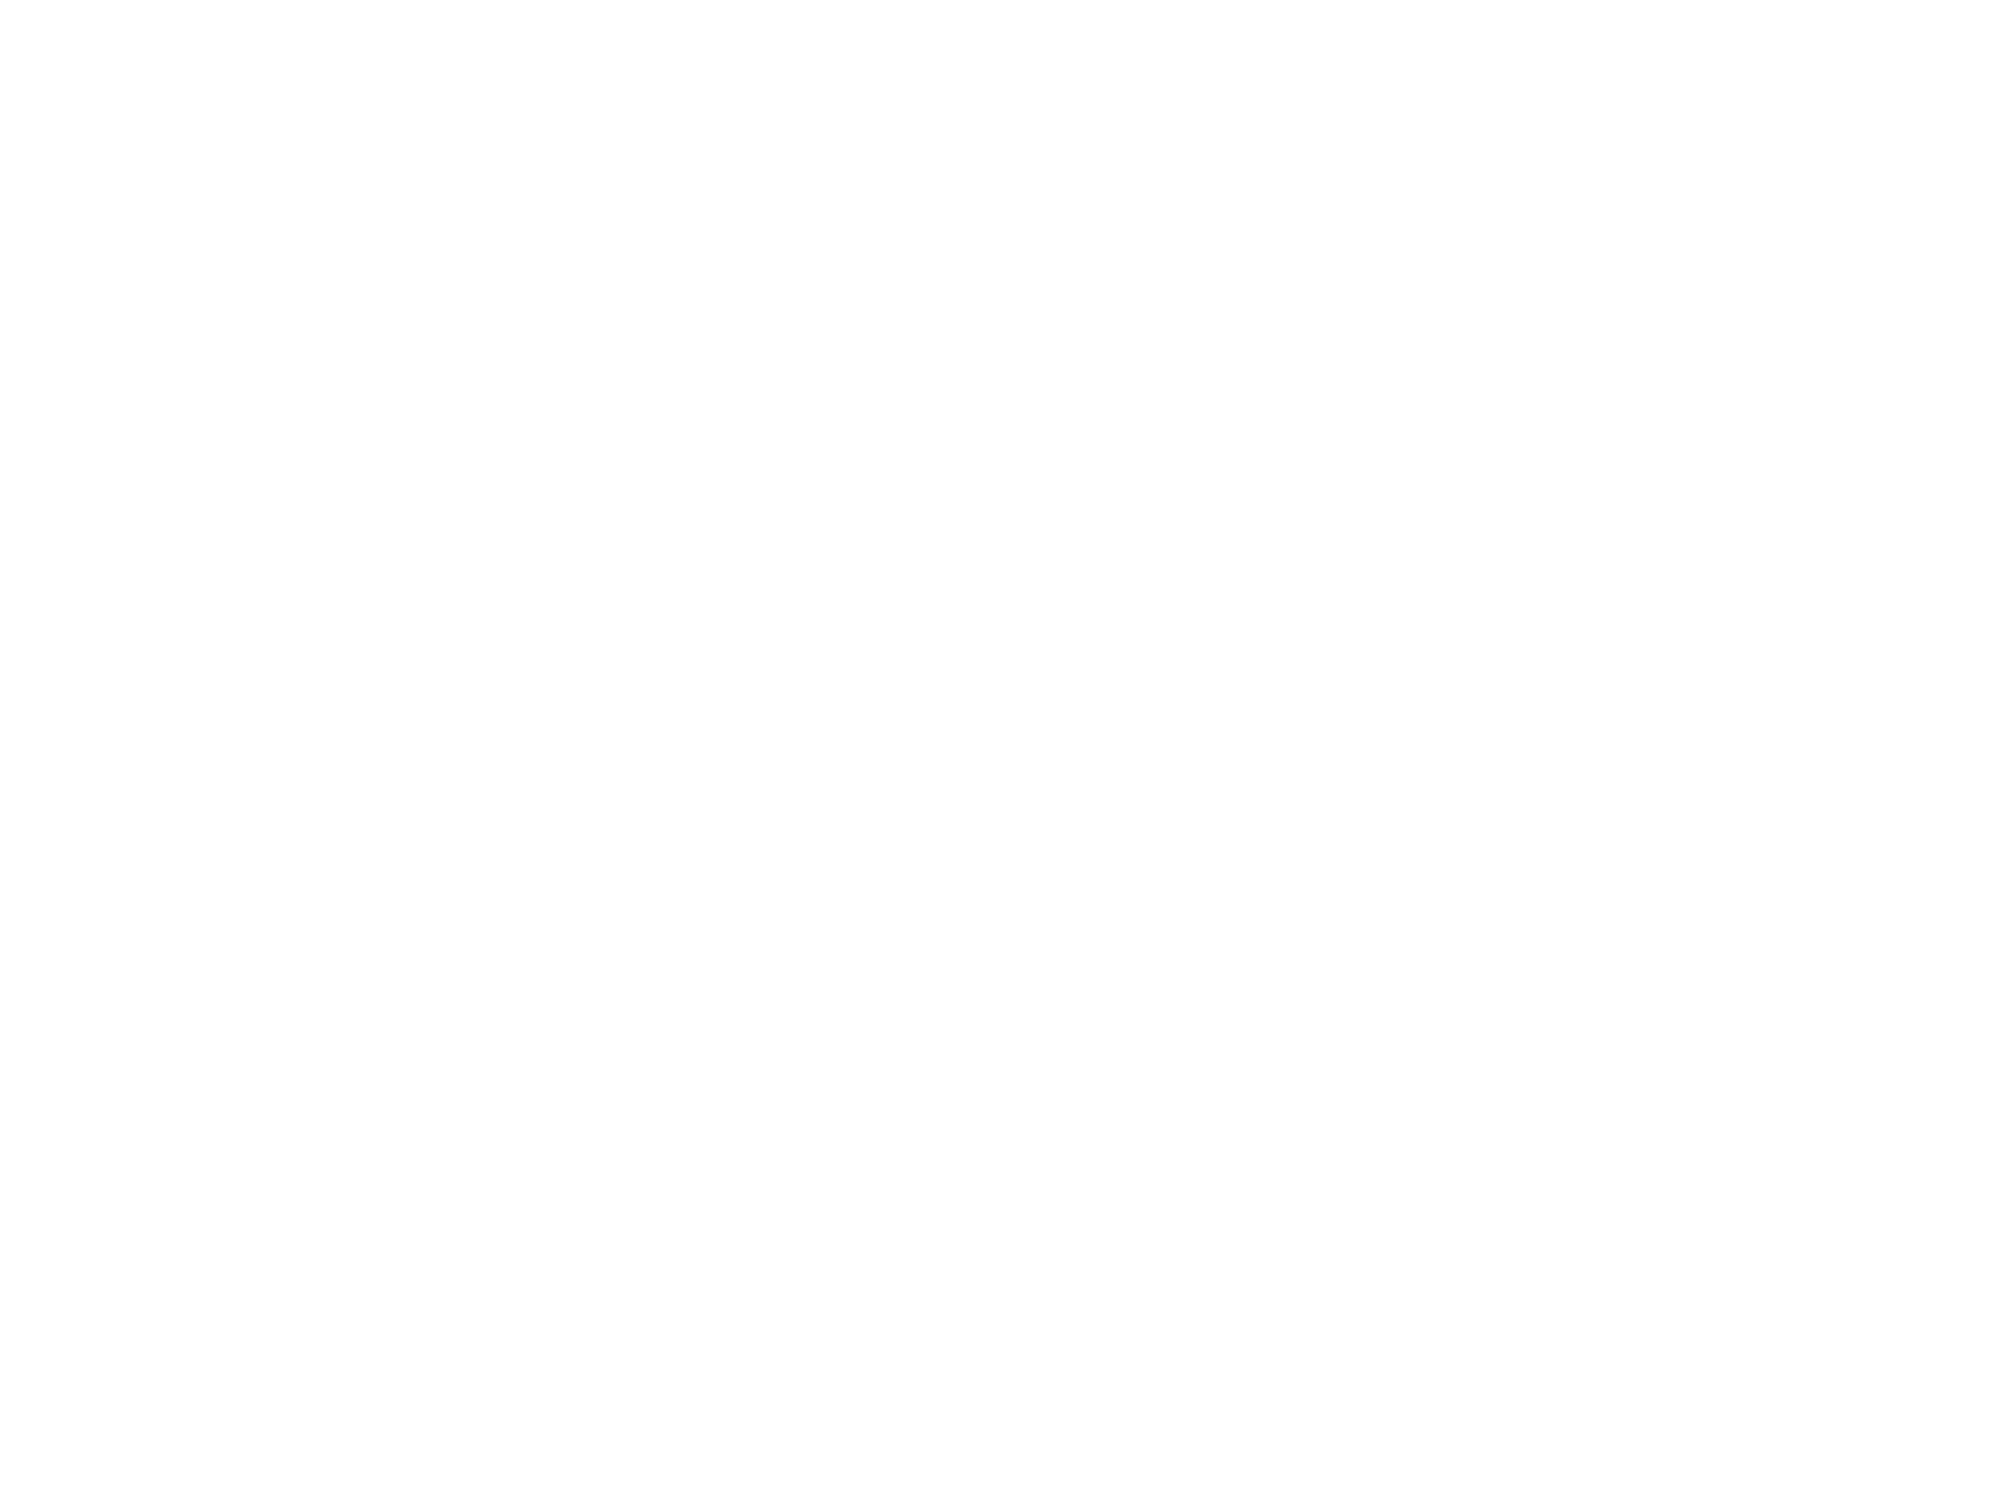

morph-tuning_Lm__JC091_20190627_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_155-of-170rois
... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 253.29
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 138 of 175 responsive cells.
N rois to plot: 138
(12, 12)


<IPython.core.display.Javascript object>


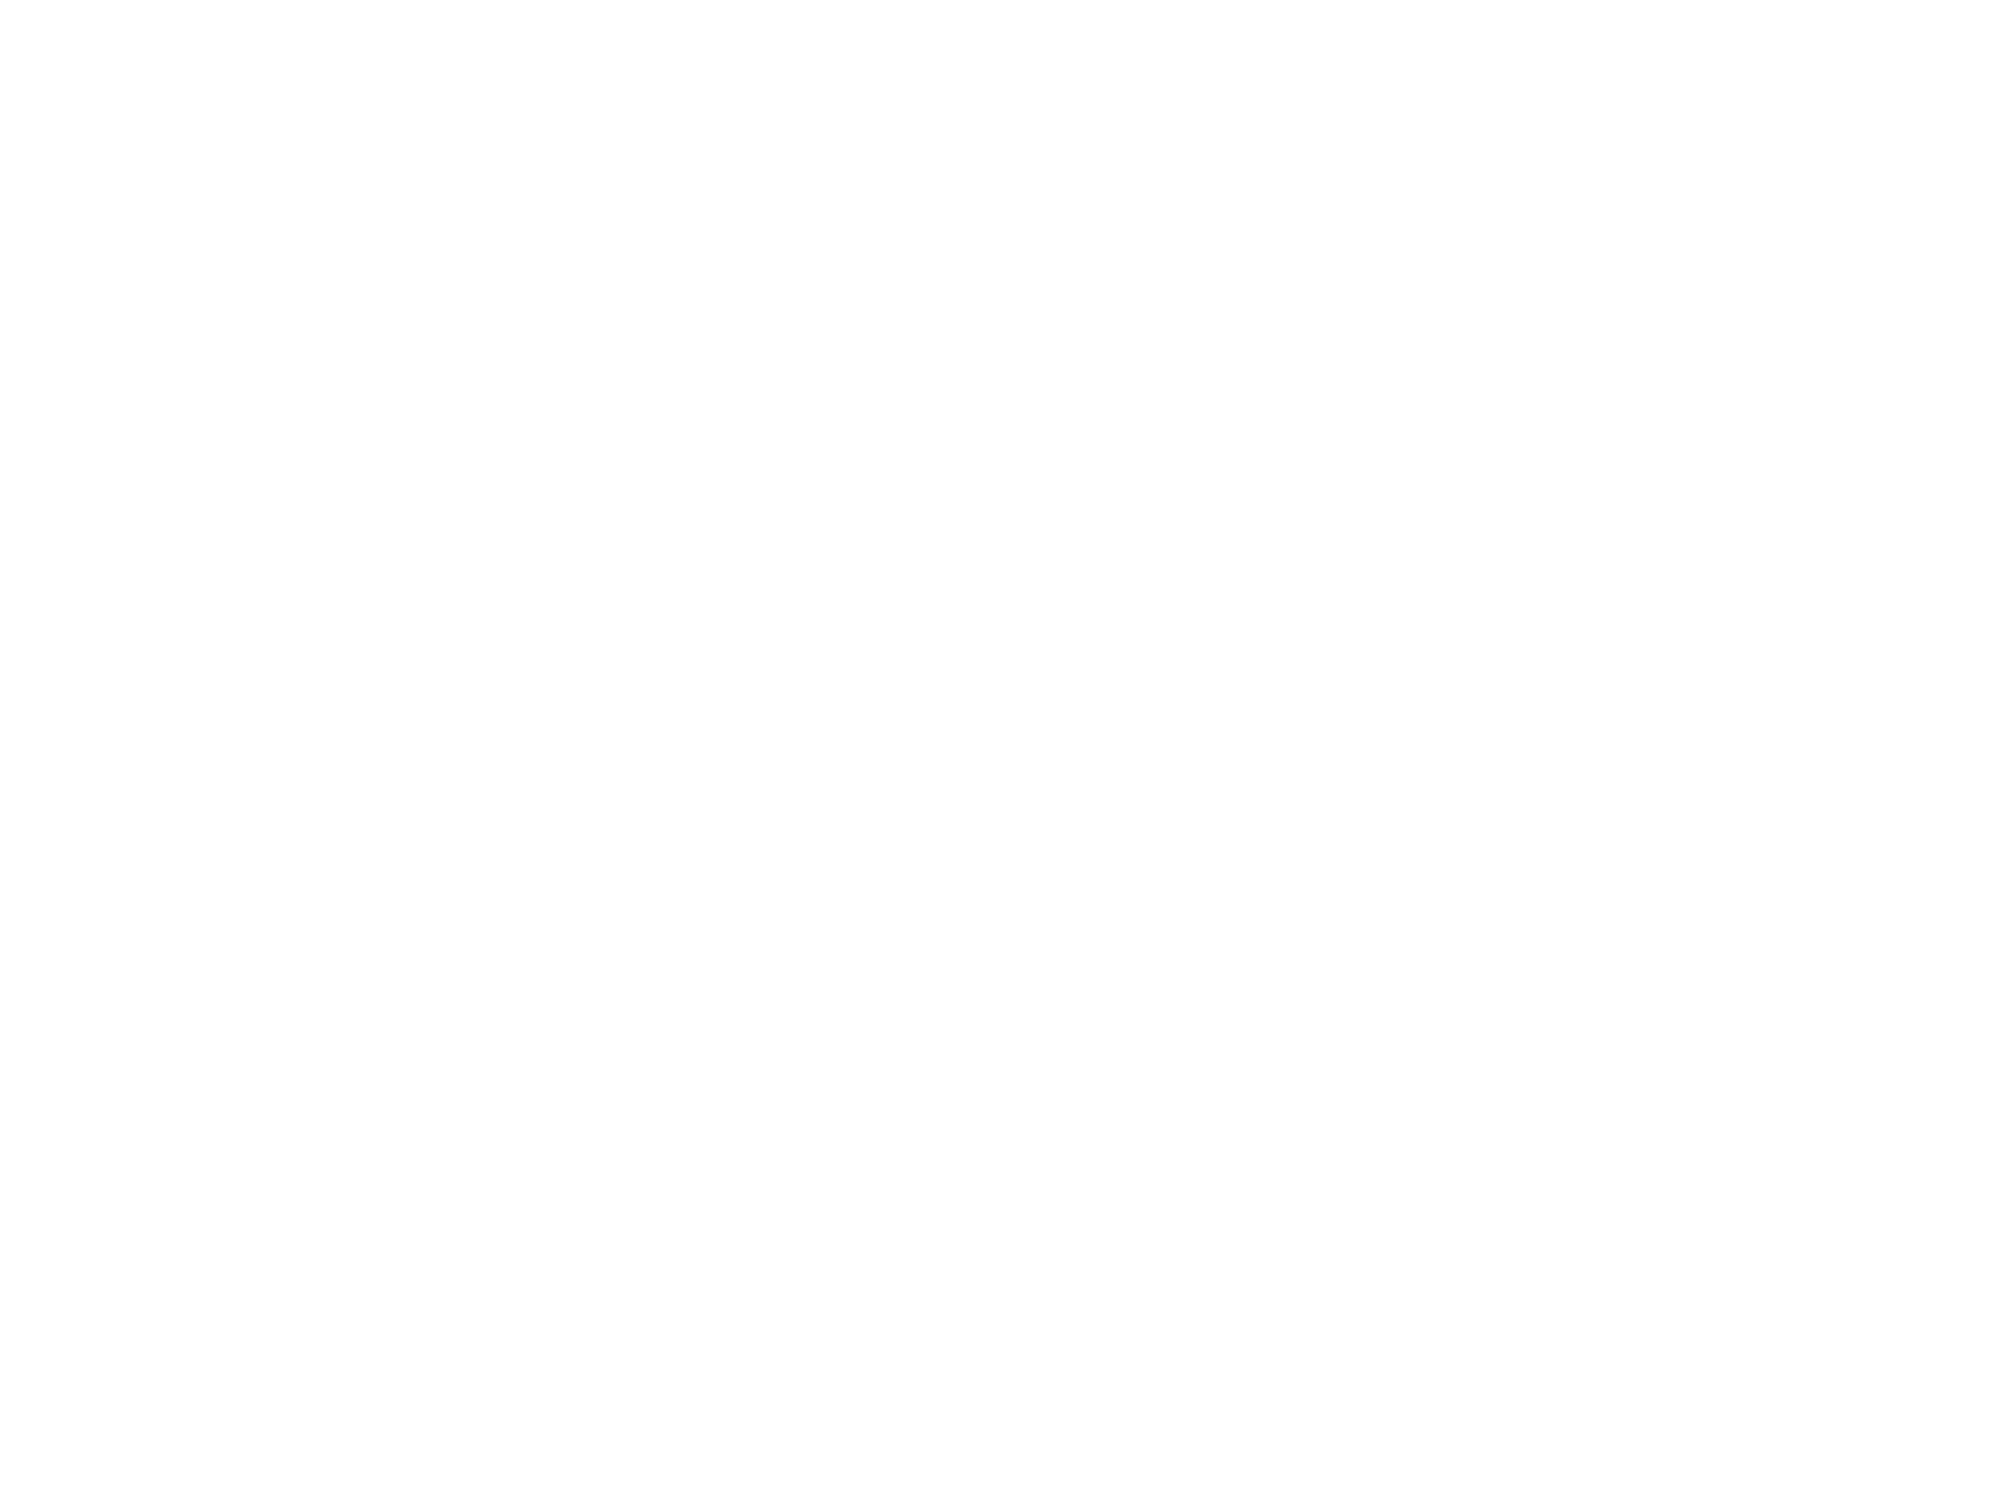

morph-tuning_V1__JC076_20190420_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_138-of-175rois
... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 285.69
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 156 of 189 responsive cells.
N rois to plot: 156
(12, 13)


<IPython.core.display.Javascript object>


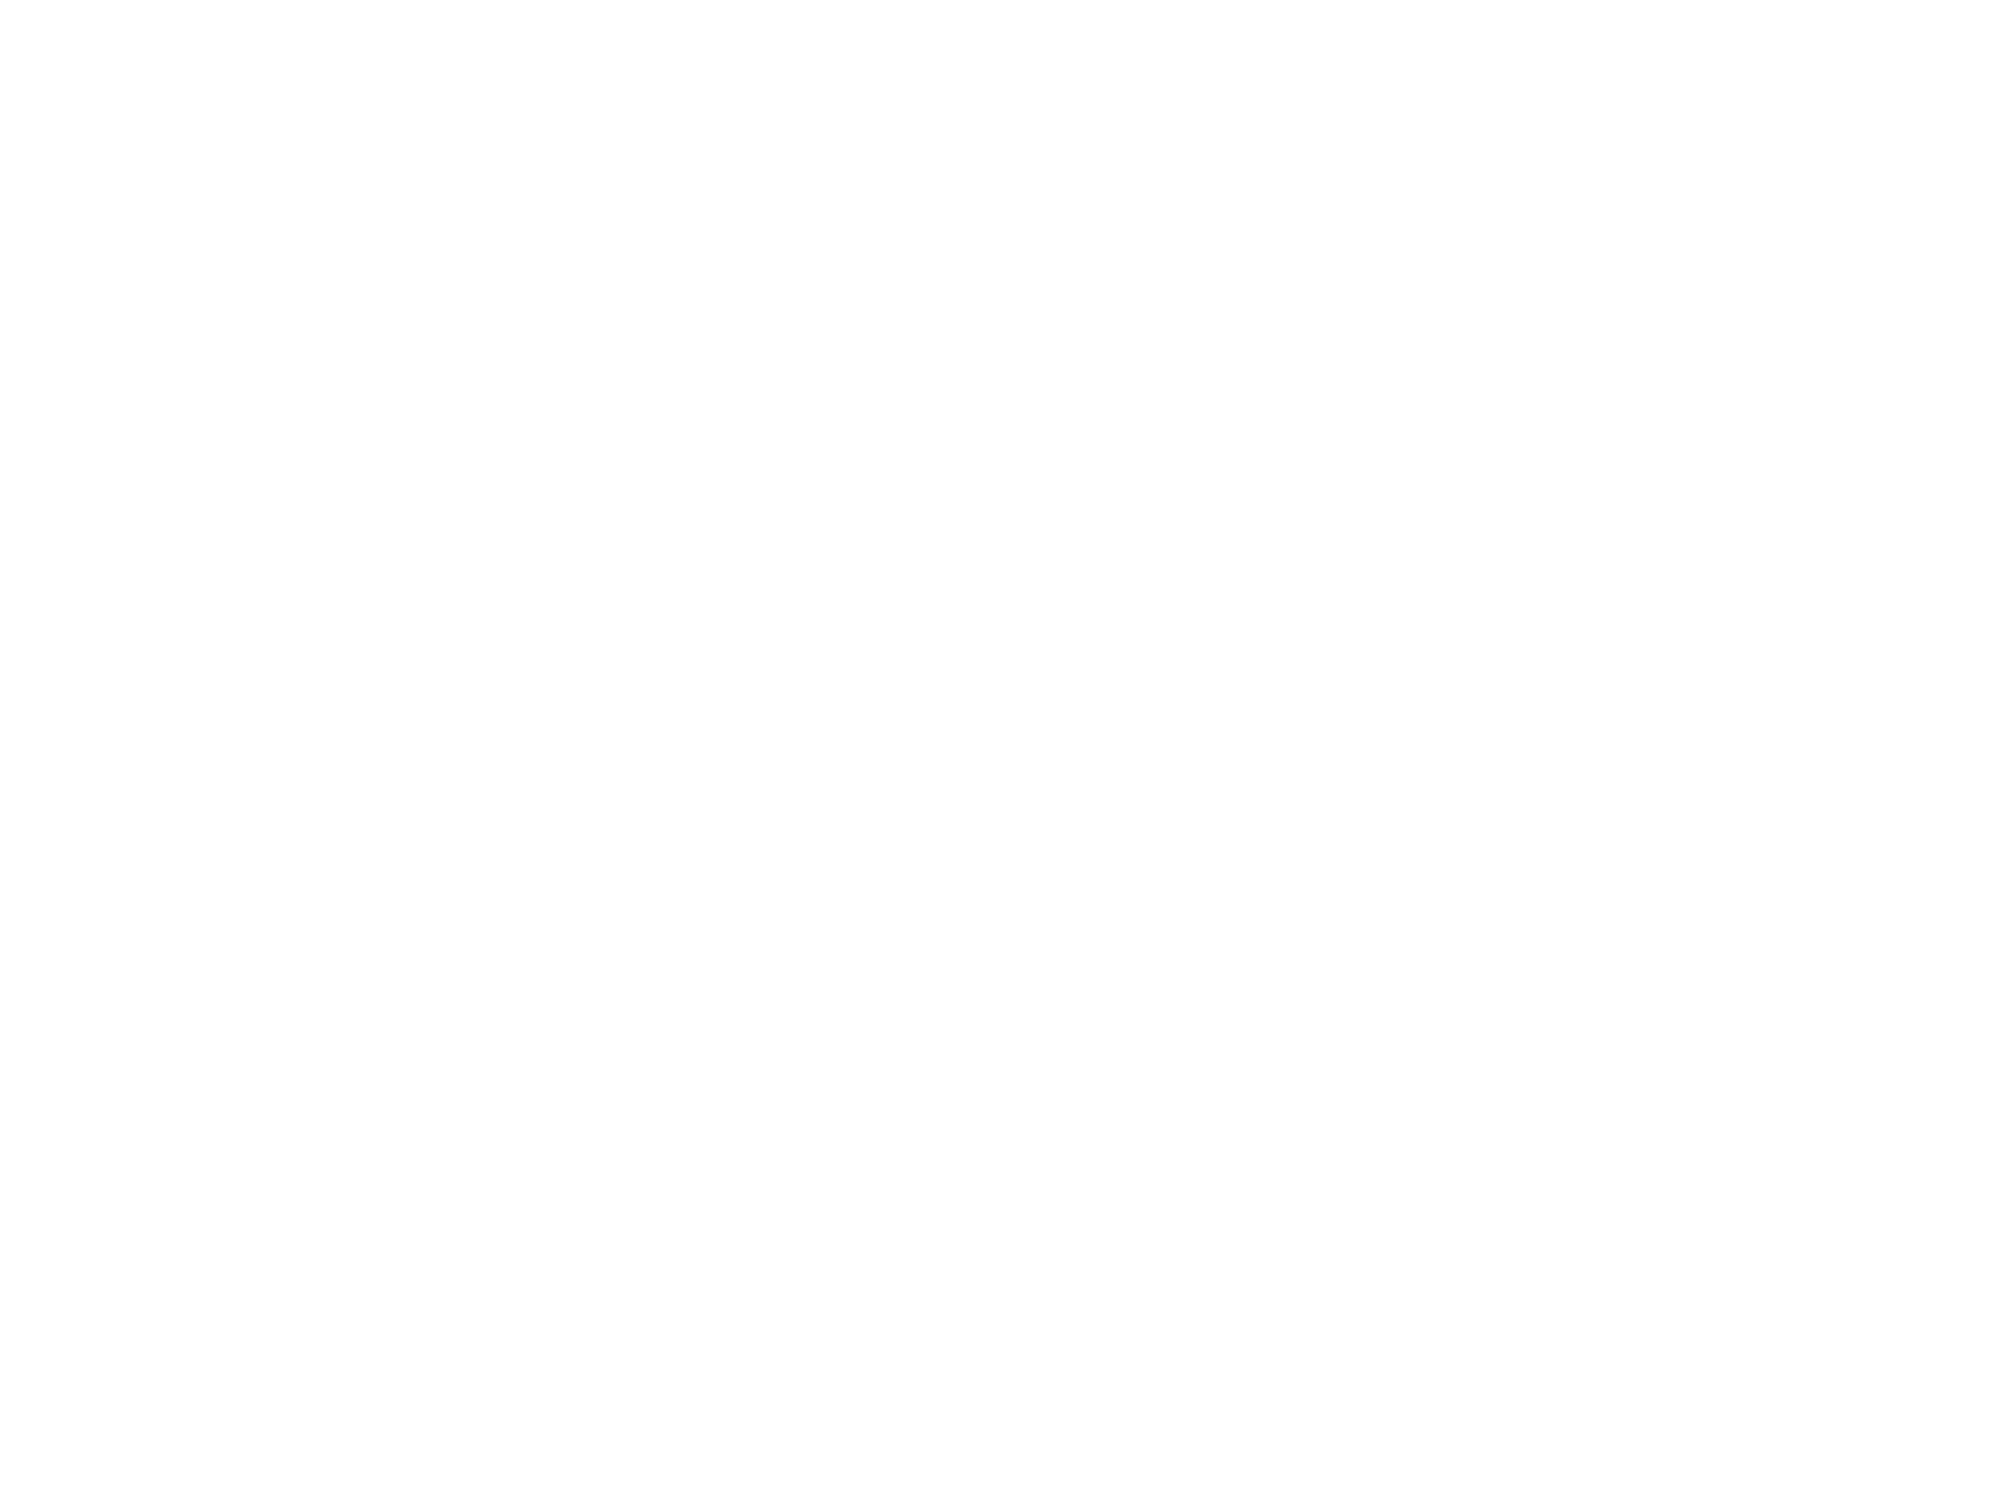

morph-tuning_V1__JC076_20190501_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_156-of-189rois
... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 297.28
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 119 of 132 responsive cells.
N rois to plot: 119
(11, 11)


<IPython.core.display.Javascript object>


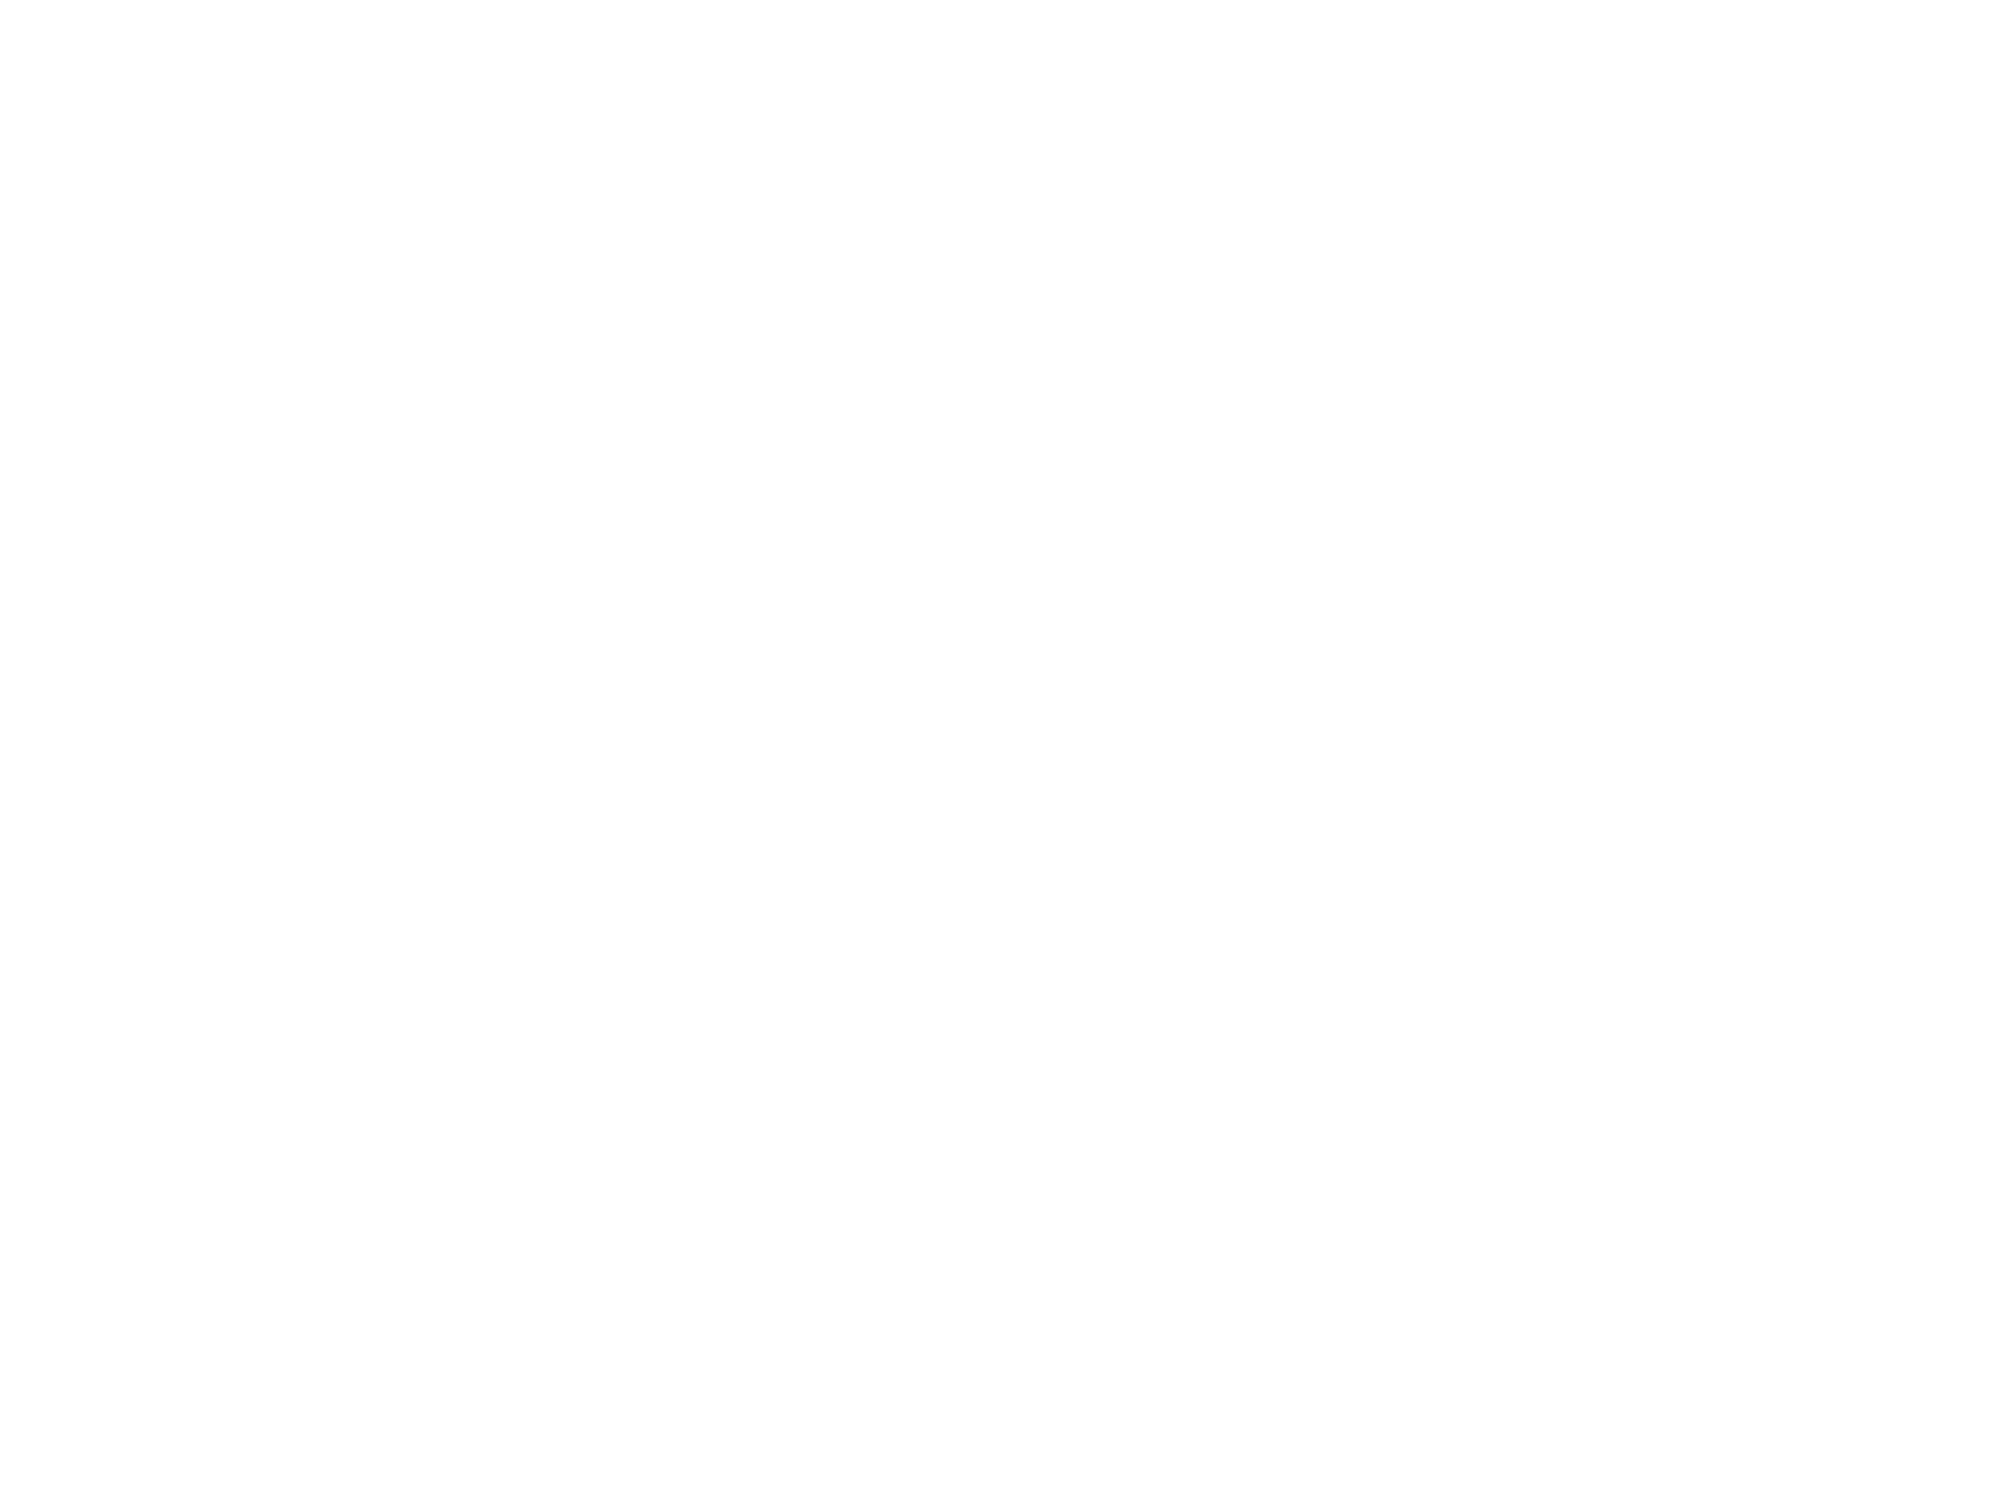

morph-tuning_V1__JC083_20190507_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_119-of-132rois
... [JC083|20190510|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 310.52
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 100 of 121 responsive cells.
N rois to plot: 100
(10, 10)


<IPython.core.display.Javascript object>


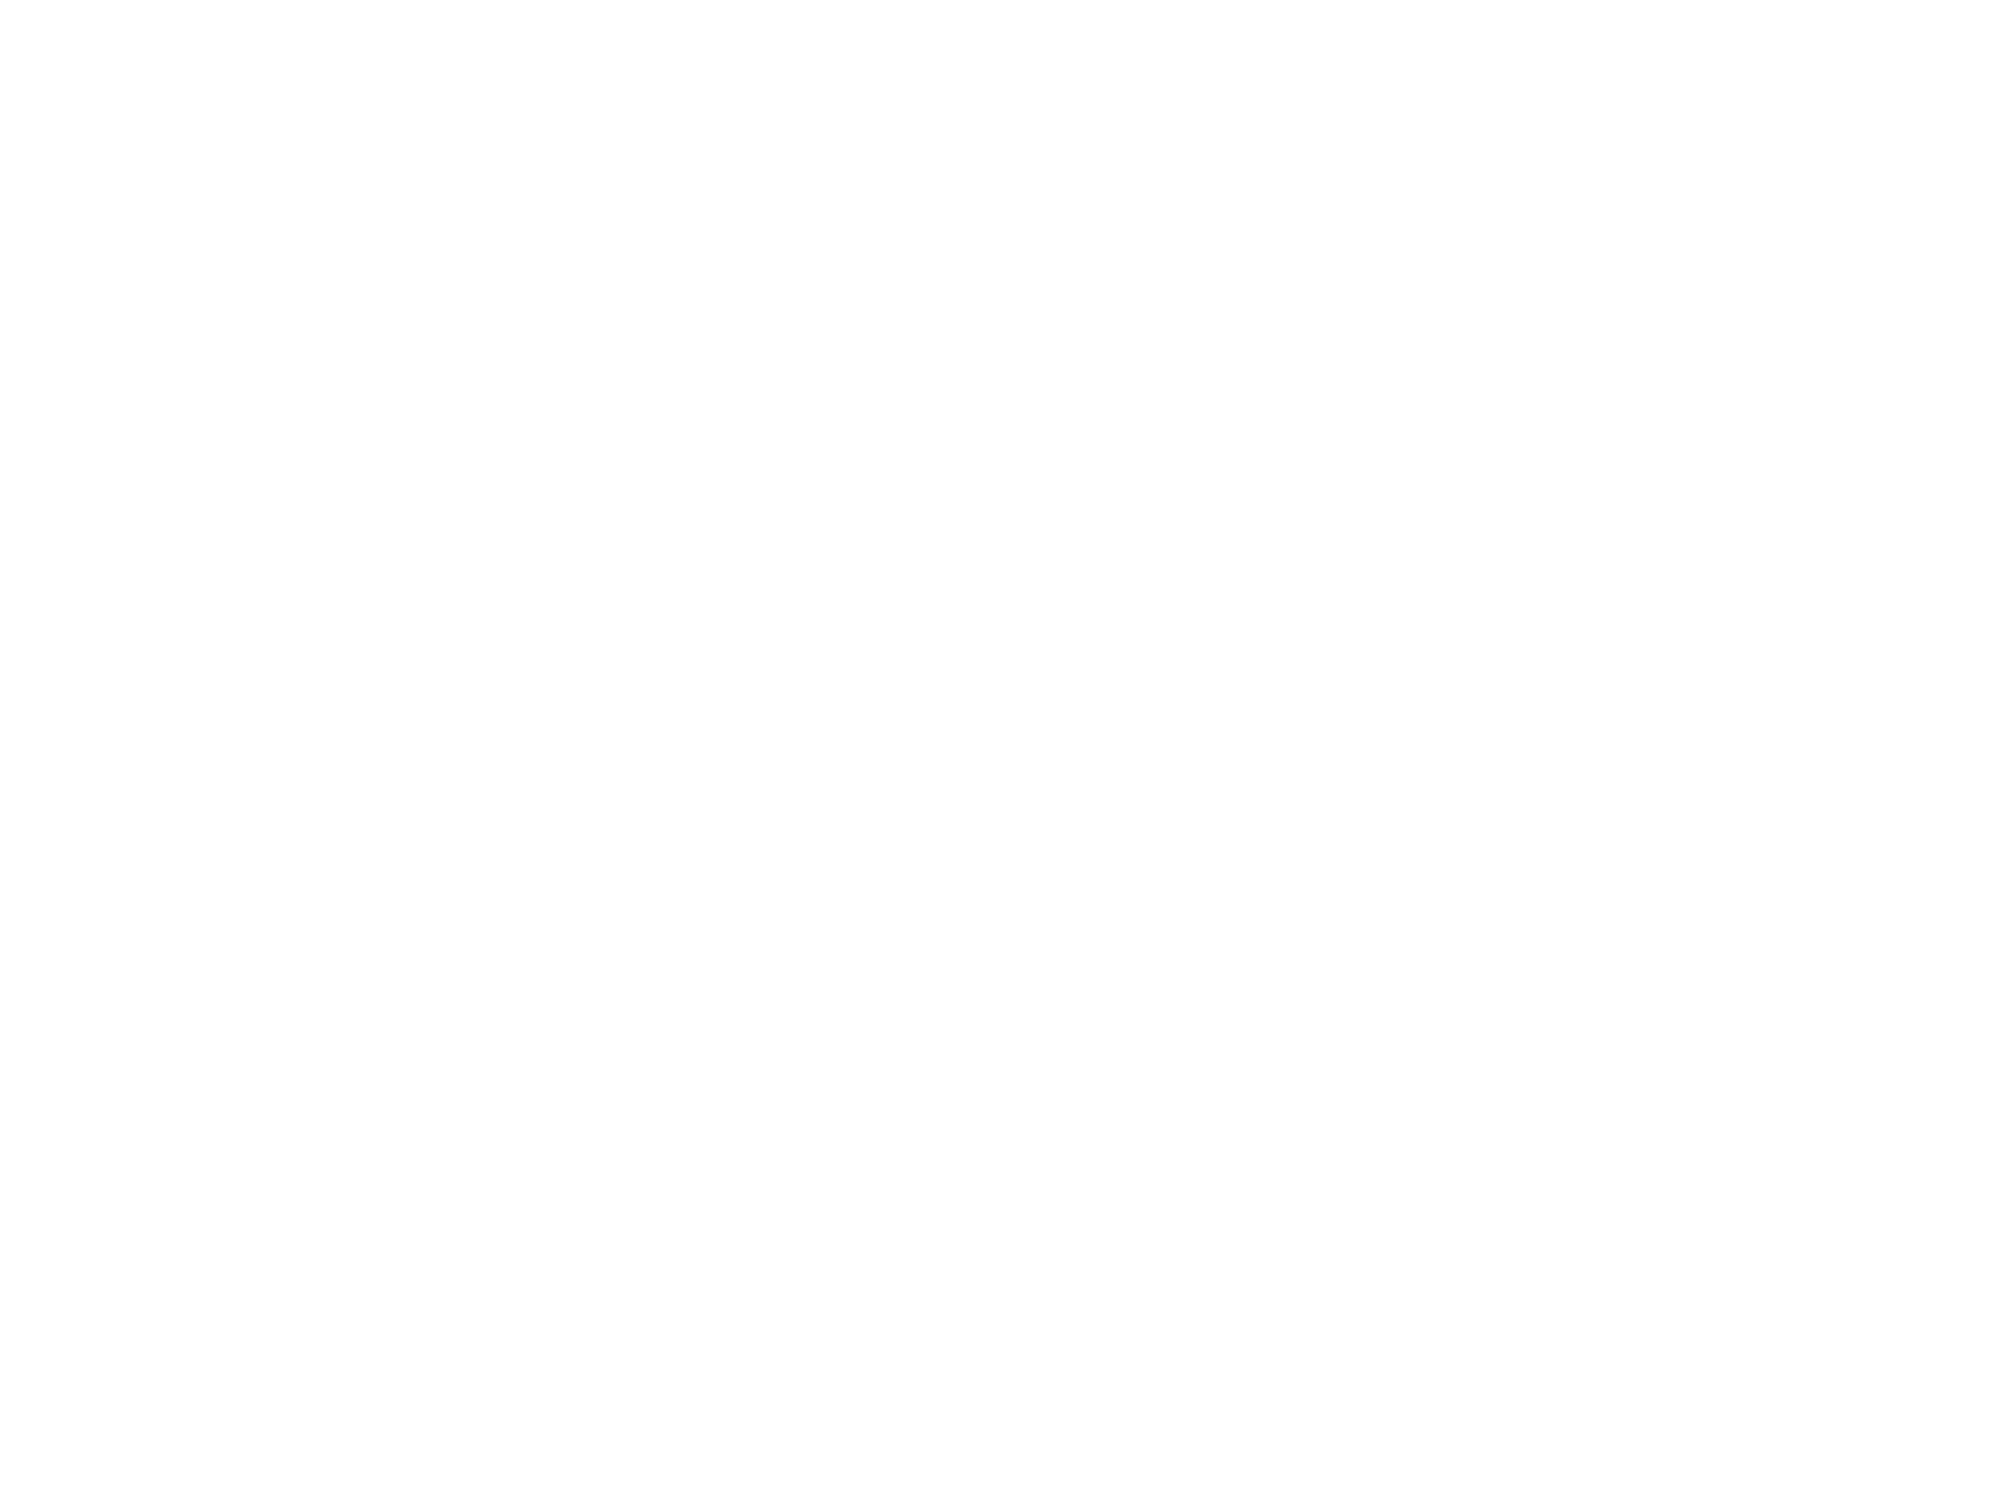

morph-tuning_V1__JC083_20190510_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_100-of-121rois
... [JC083|20190511|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 327.49
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 120 of 126 responsive cells.
N rois to plot: 120
(11, 11)


<IPython.core.display.Javascript object>


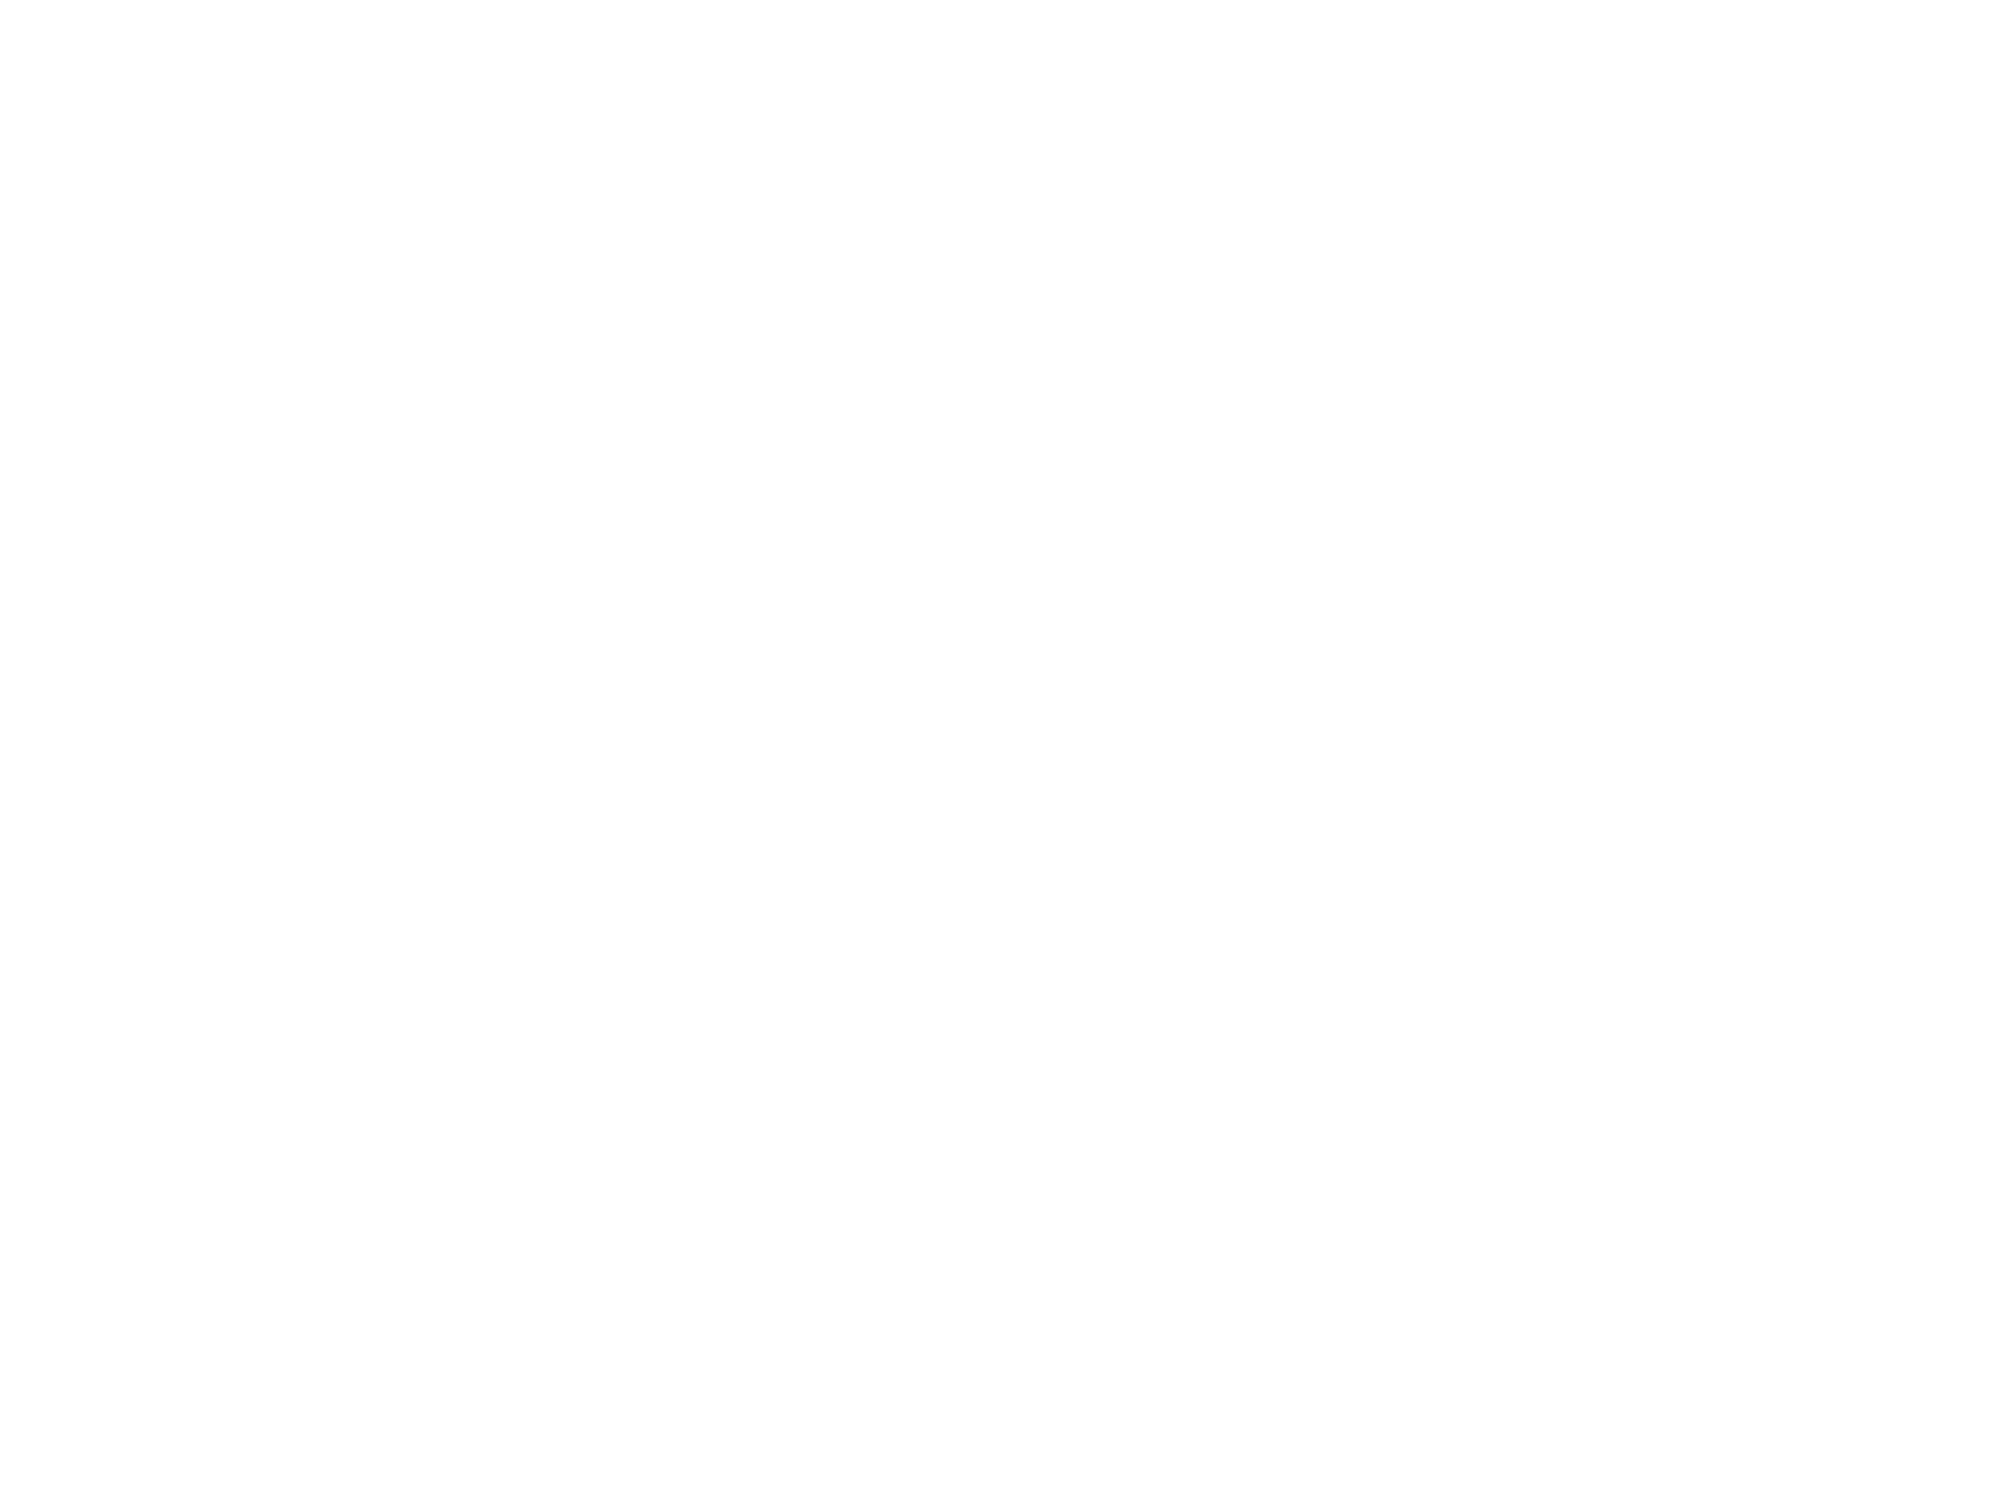

morph-tuning_V1__JC083_20190511_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_120-of-126rois
... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 608.72
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 128 of 180 responsive cells.
N rois to plot: 128
(11, 12)


<IPython.core.display.Javascript object>


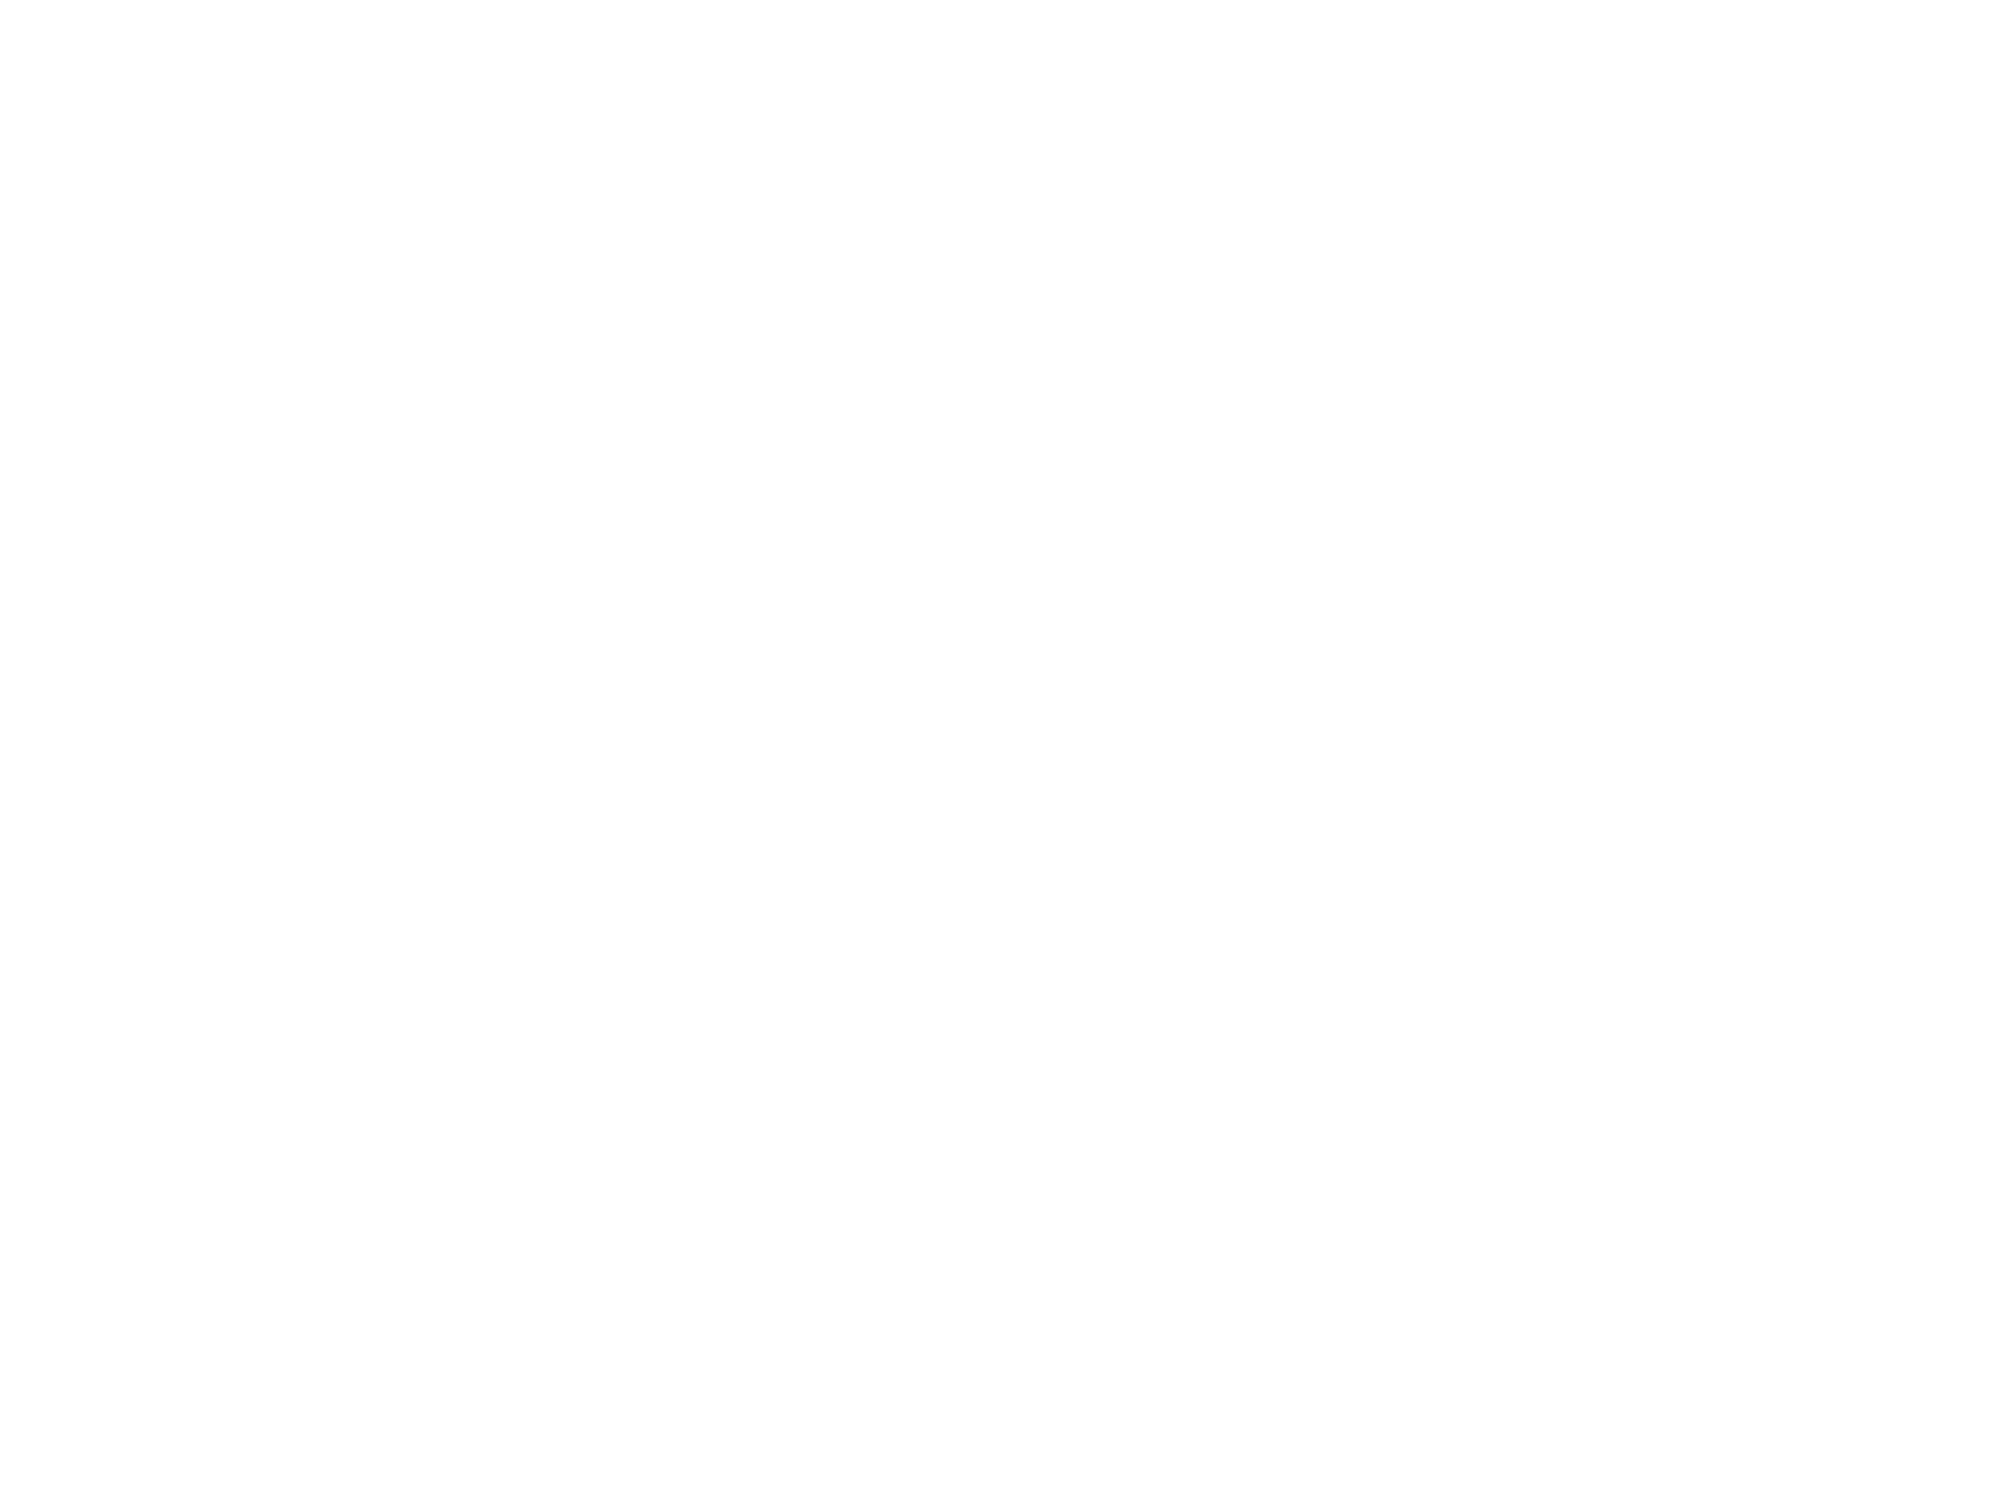

morph-tuning_V1__JC084_20190522_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_128-of-180rois
... [JC085|20190622|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 370.88
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 185 of 202 responsive cells.
N rois to plot: 185
(14, 14)


<IPython.core.display.Javascript object>


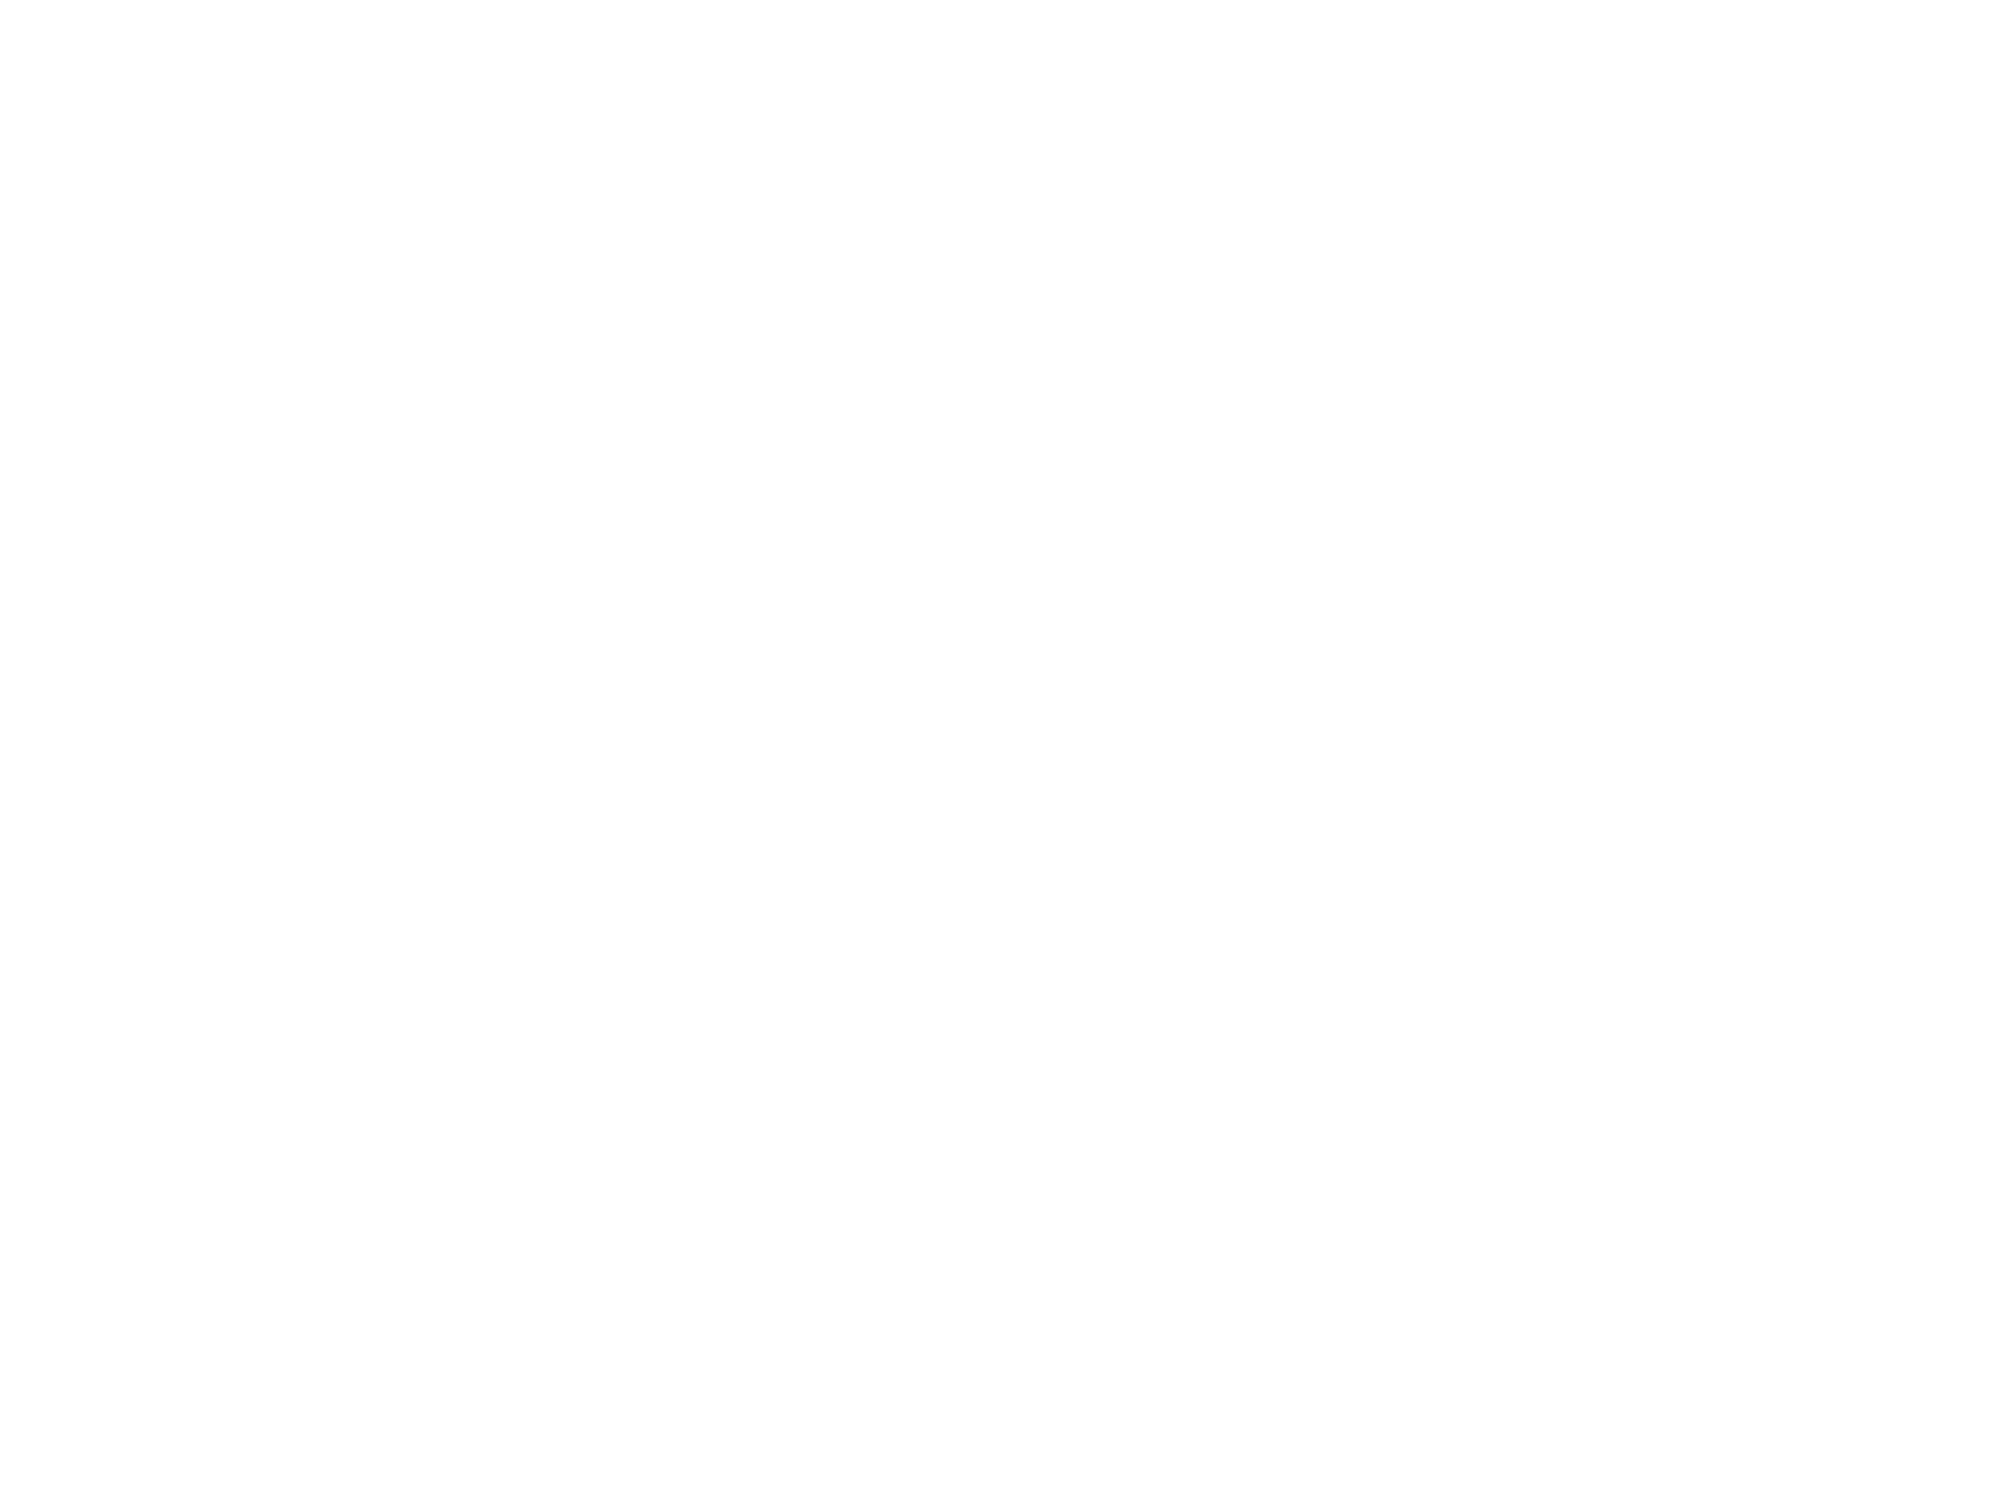

morph-tuning_V1__JC085_20190622_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_185-of-202rois
... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 634.92
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 125 of 166 responsive cells.
N rois to plot: 125
(11, 12)


<IPython.core.display.Javascript object>


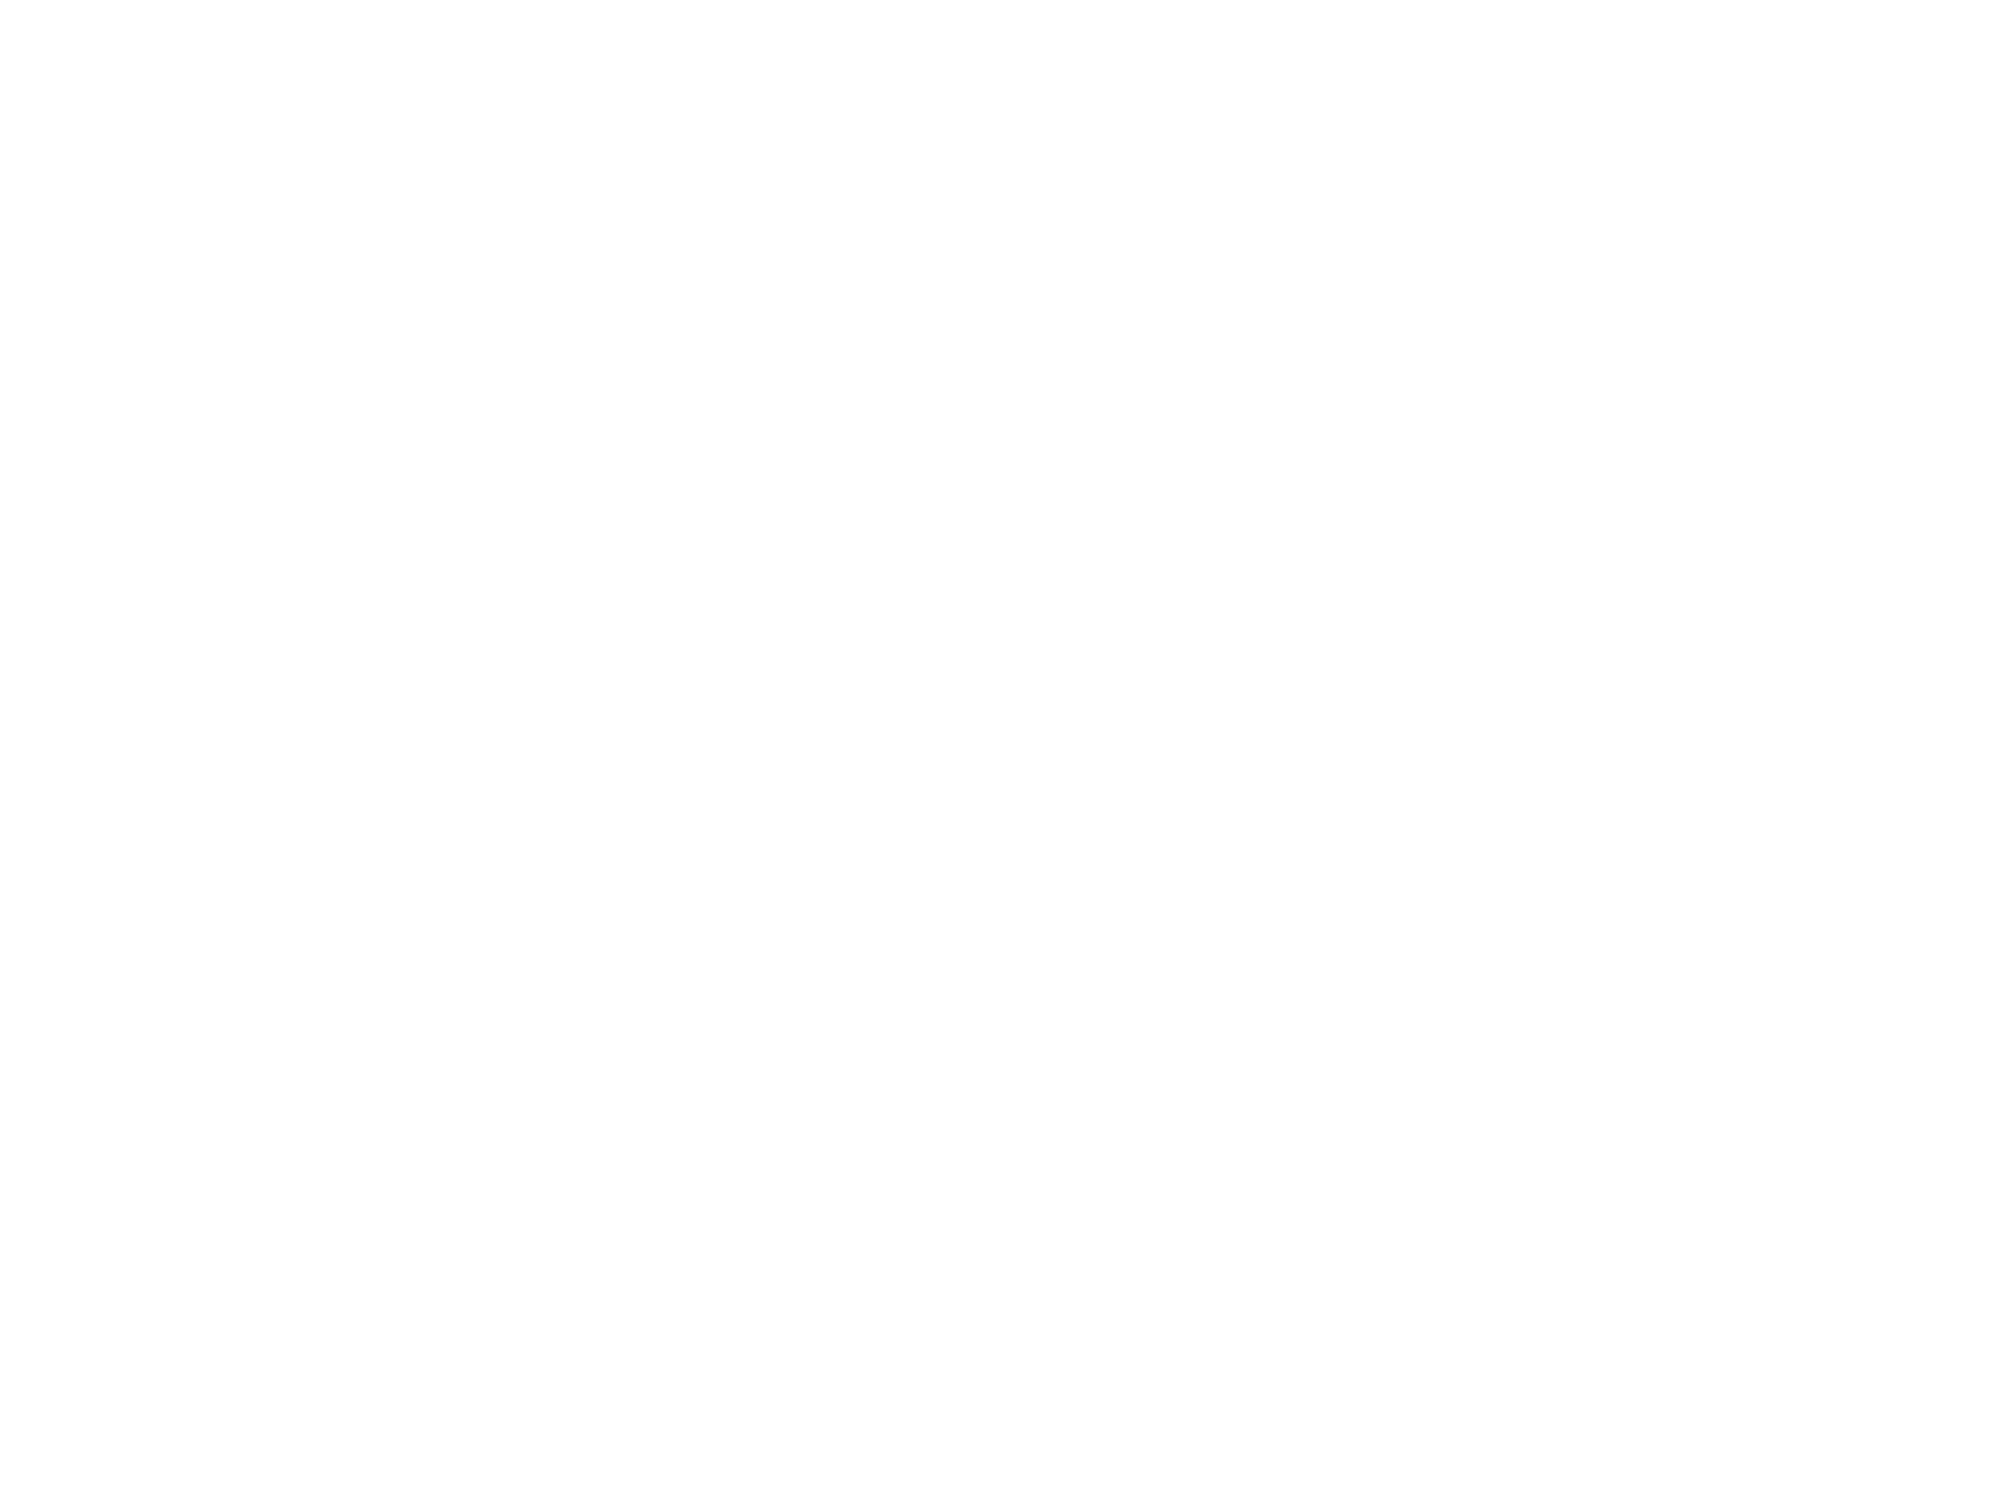

morph-tuning_V1__JC097_20190613_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_125-of-166rois
... [JC097|20190616|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 692.01
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 237 of 298 responsive cells.
N rois to plot: 237
(15, 16)


<IPython.core.display.Javascript object>


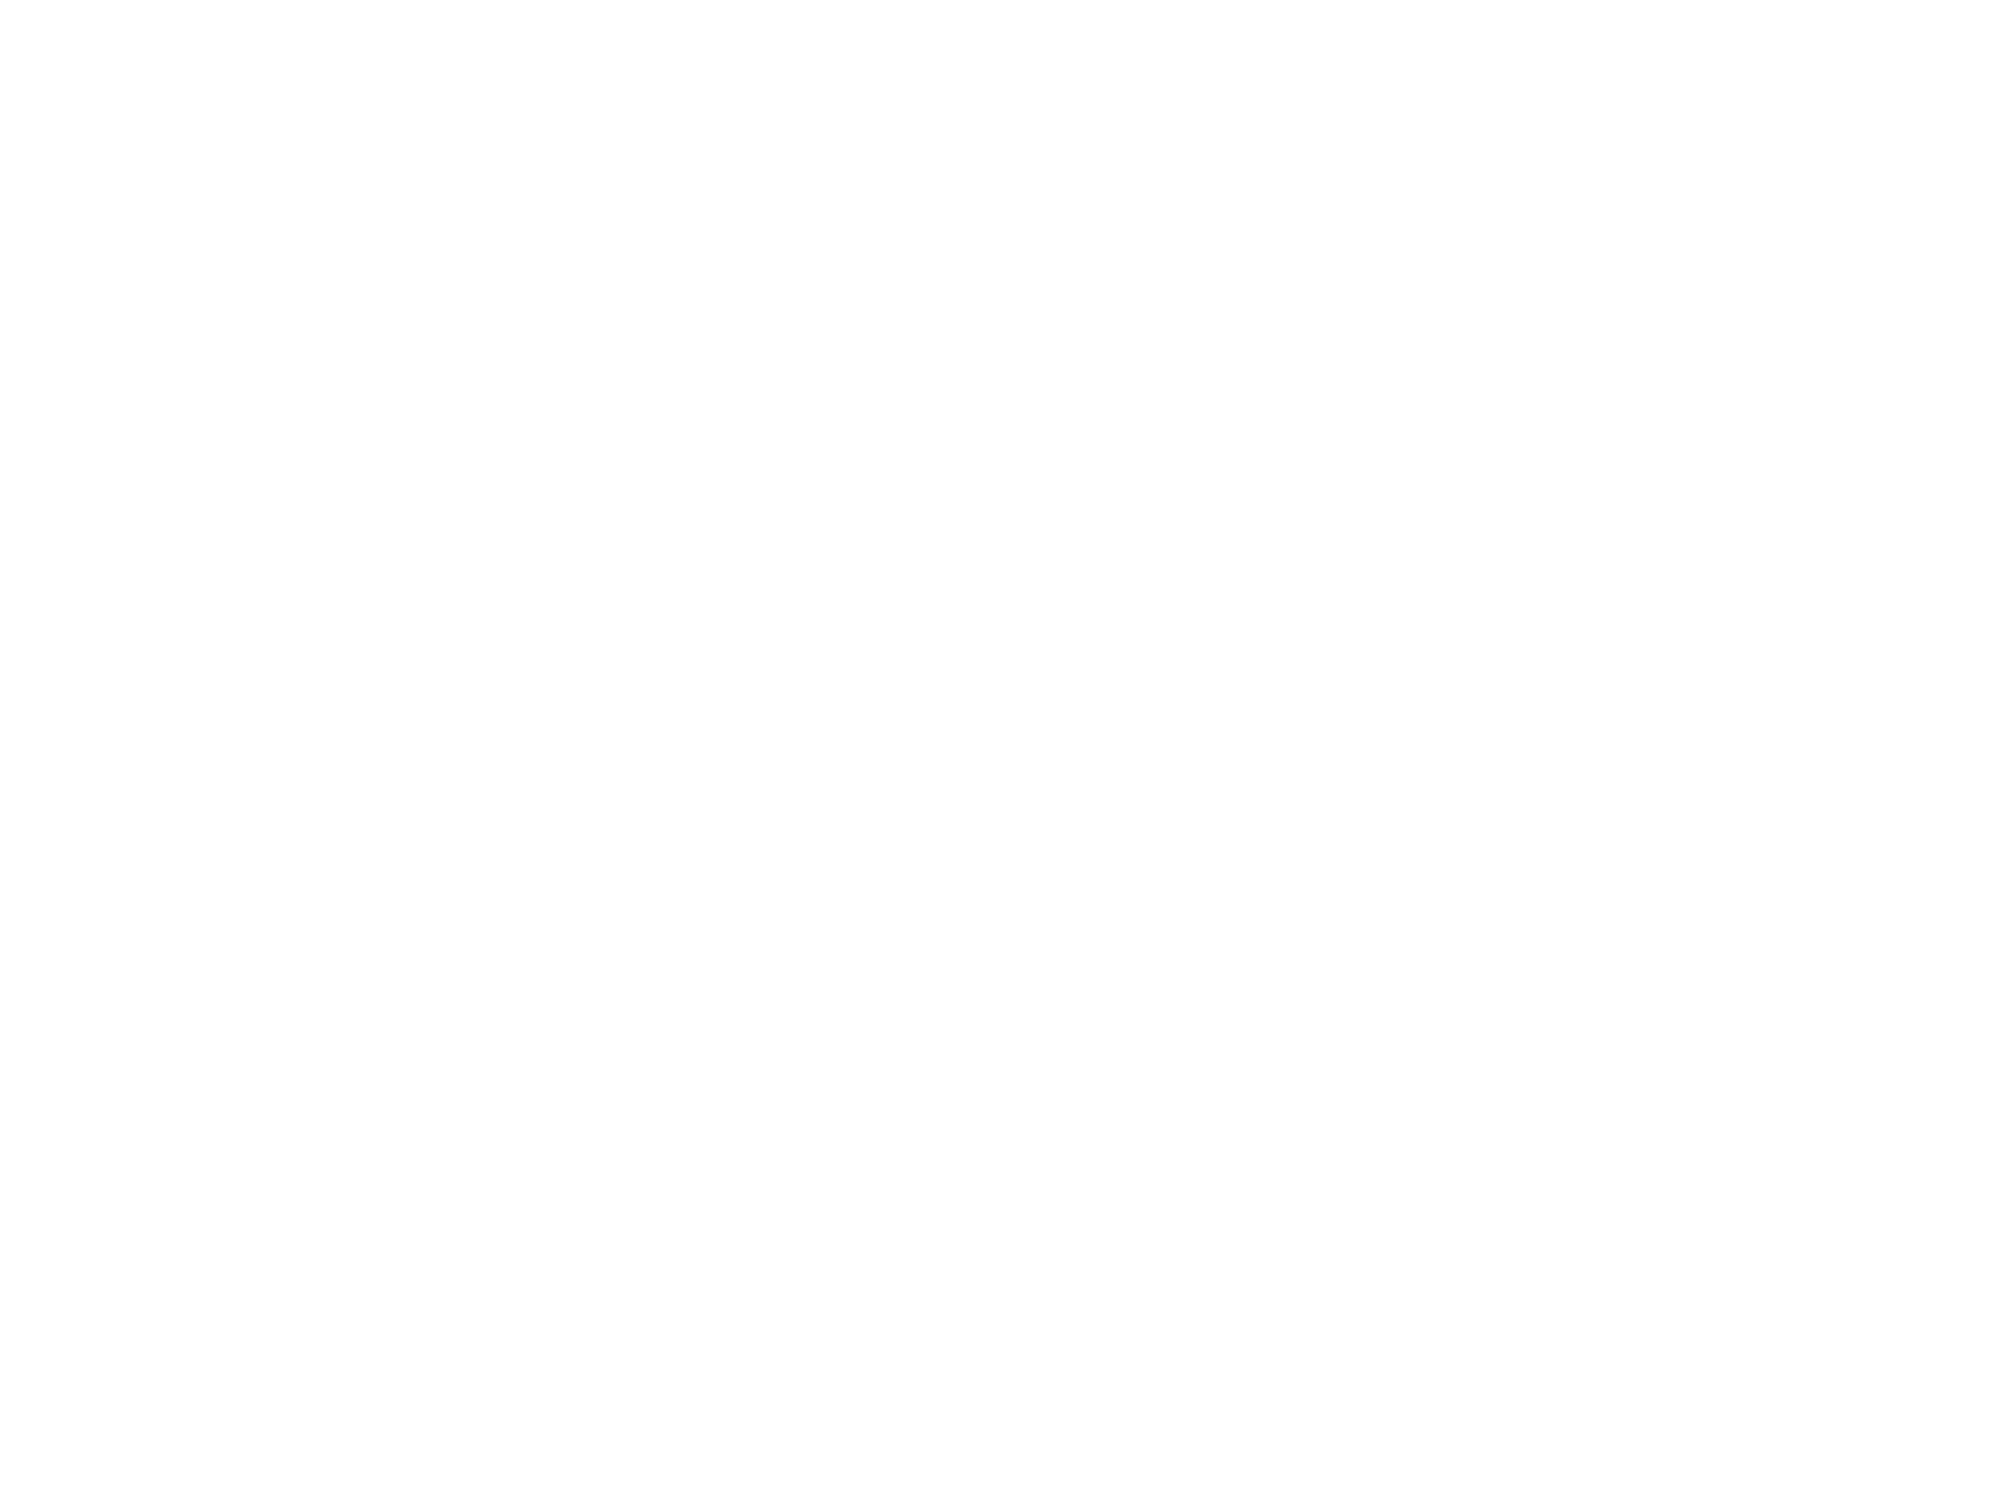

morph-tuning_V1__JC097_20190616_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_237-of-298rois
... [JC097|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
... offset: 617.18
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 231 of 276 responsive cells.
N rois to plot: 231
(15, 16)


<IPython.core.display.Javascript object>


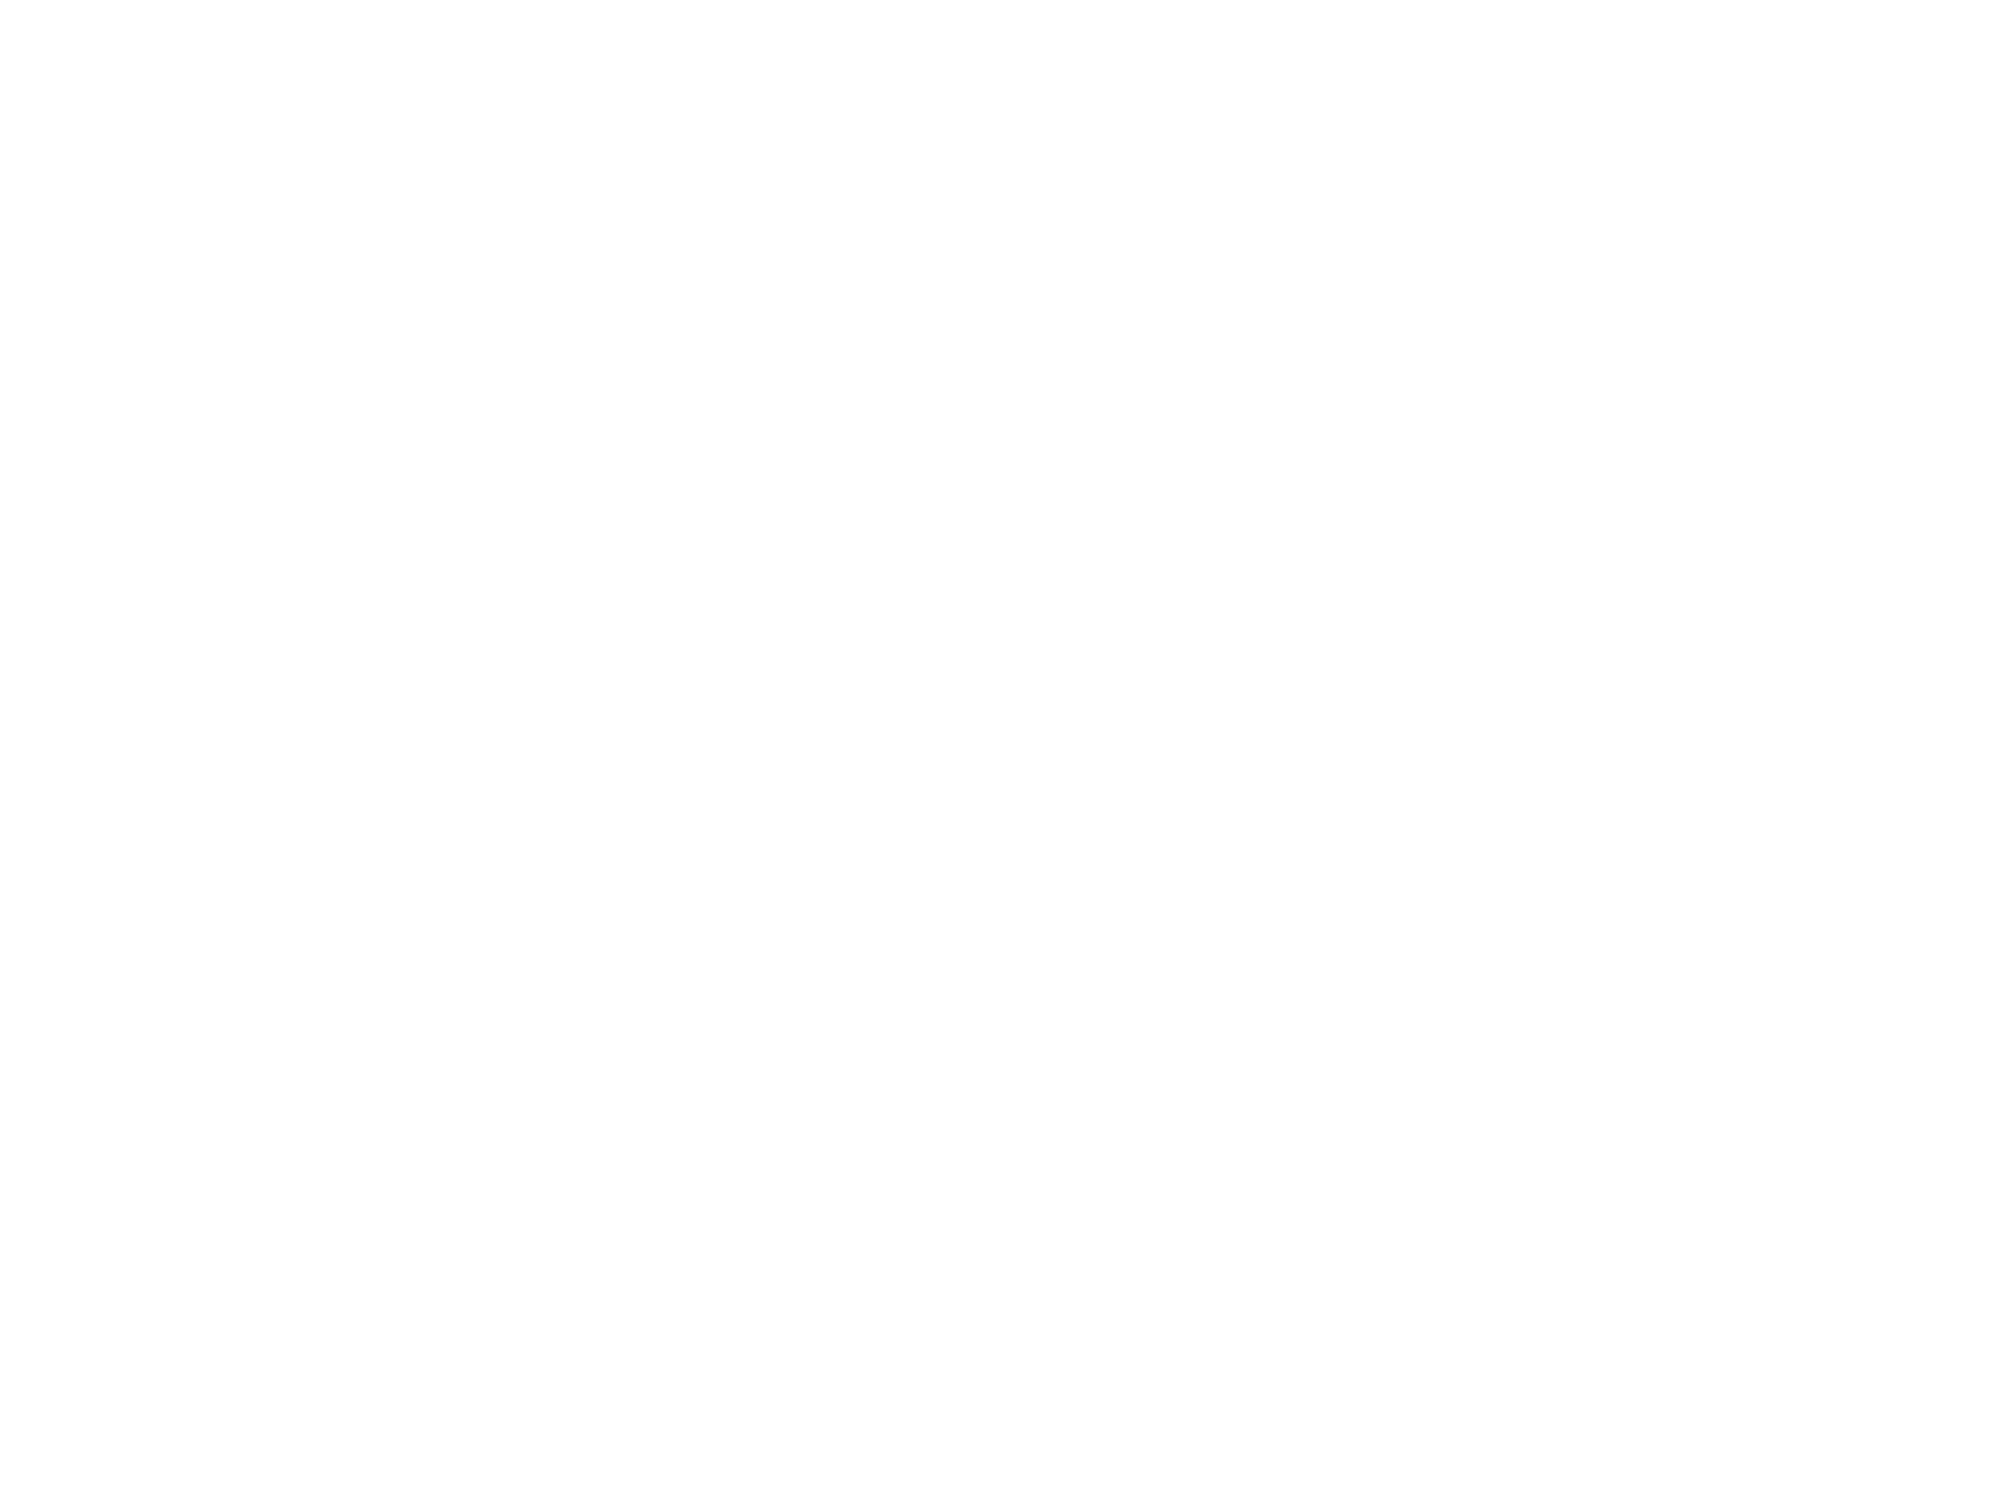

morph-tuning_V1__JC097_20190617_FOV1_zoom2p0x_traces001_stats-traces001-corrected-dff-nstds-thr-10.00_thr-dff-0.03_231-of-276rois


In [62]:
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

    skey = '-'.join([visual_area, animalid, session, fov])
    
    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    # Get stimulus conditions
    sdf = exp.get_stimuli()
    sdf = reformat_morph_values(sdf)
    sizes = np.array(sorted(sdf['size'].unique()))
    morphs = np.array(sorted(sdf['morphlevel'].unique()))

    n_sizes = len(sdf['size'].unique())
    n_morphs = len(sdf['morphlevel'].unique()) 
    if n_sizes != n_sz or n_morphs != n_mp:
        incorrect_nvalues.append(skey)
        continue
        
    figexists = len(glob.glob(os.path.join(outdir, 'sessions', 'morph-tuning_%s__%s*.png' % (visual_area, data_id.replace('|', '_')))))
    
    if figexists:
        continue
    

    rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
    rstats = rstats['nframes_above']
    

    # Get metrics for each condition
    estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
    meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                       for roi in estats.rois], axis=1).T
    assert len(np.where(np.isnan(meanr))[0])==0
    semr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).sem()['dff'], name=roi) \
                       for roi in estats.rois], axis=1).T
    # Get ROI list
    if threshold_dff:
        rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
    else:
        rois_plot = meanr.index.tolist()
    print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

    df_mean = meanr.loc[rois_plot]
    df_sem = semr.loc[rois_plot]

    hue_name = 'size' if tune_name=='morph' else 'morph'
    tune_values = morphs.copy() if tune_name=='morph' else sizes.copy()
    hue_values = sizes.copy() if tune_name=='morph' else morphs.copy()
    hcolors = sns.color_palette('gray_r', n_colors=n_sz) if tune_name=='morph' else sns.color_palette('gray_r', n_colors=n_mp) 


    fig = plot_roi_tuning(df_mean, df_sem=df_sem, tune_values=tune_values, tune_name=tune_name,
                         hue_values=hue_values, hue_name=hue_name, hue_colors=hcolors)
    if threshold_dff:
        figname = '%s-tuning_%s__%s_thr-dff-%.2f_%i-of-%irois' % (tune_name, visual_area, data_id.replace('|', '_'), min_dff, len(rois_plot), len(estats.rois))
    else:
        figname = '%s-tuning_%s__%s_all-resp_%i-of-%irois' % (tune_namevisual_area, data_id.replace('|', '_'), len(rois_plot), len(estats.rois))

    pl.savefig(os.path.join(outdir, 'sessions', '%s.png' % figname))
    print figname
    pl.close()
    
    del exp


# Look at counts across visual areas

In [154]:
incorrect_nconfigs = []
incorrect_nvalues = []
nresponsive = {}
ntotal = {}

In [155]:
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    skey = '%s-%s-%s' % (animalid, session, fov)

    sdf = exp.get_stimuli()
    if len(sdf.index.tolist()) != 50:
        incorrect_nconfigs.append(skey)
        continue

    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]
    n_sizes = len(sdf['size'].unique())
    n_morphs = len(sdf['morphlevel'].unique()) 
    if n_sizes != nr or n_morphs != nc:
        incorrect_nvalues.append(skey)
        continue

    if visual_area not in nresponsive.keys():
        nresponsive[visual_area] = {}
        ntotal[visual_area] = {}
    rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
    rstats = rstats['nframes_above']


    ncells_arr = np.empty((nr, nc), dtype=int)
    for ri, sz in enumerate(sizes):
        for mi, mp in enumerate(morphs):
            assert sz in sdf['size'].unique(), "wrong size: %i" % sz
            assert mp in sdf['morphlevel'].unique(), "wrong morph: %i" % mp
            ax = axes[ri, mi]
            cfg = sdf[( (sdf['size']==sz) & (sdf['morphlevel']==mp) )].index[0]
            ncells_resp = len(np.where(rstats.loc[cfg] >= responsive_thr)[0])
            ncells_arr[ri, mi] = ncells_resp

    nresponsive[visual_area].update({skey: ncells_arr})
    ntotal[visual_area].update({skey: len(rlist)})
    
    
        

... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data pa

In [157]:
print incorrect_nvalues
print incorrect_nconfigs

[]
['JC078-20190426-FOV1_zoom2p0x']


In [192]:
data_identifier = '|'.join(['blobs', fov_type, traceid, stats_desc])
print(data_identifier)

blobs|zoom2p0x|traces001|stats-traces001-corrected-dff-nstds-thr-10.00


<IPython.core.display.Javascript object>


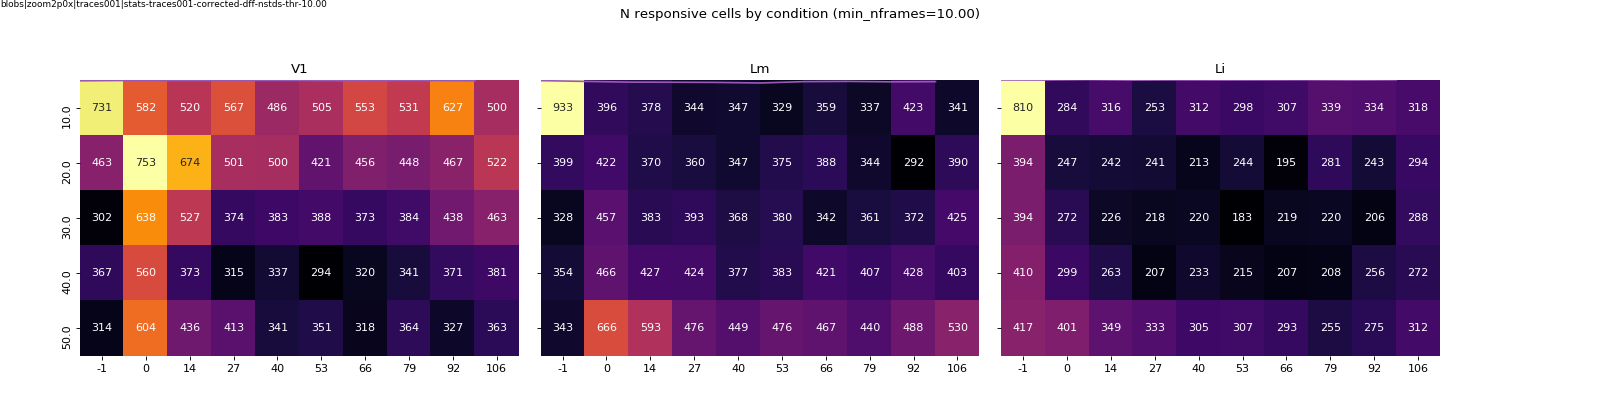

In [210]:
nr=5
nc=10
cmap = 'inferno'
normalize = False

fig, axes = pl.subplots(1,3, sharex=True, sharey=True, figsize=(20, 5))
fig.patch.set_alpha(1)
#vmin = 0
#vmax = 1
for ax, visual_area in zip(axes, ['V1', 'Lm', 'Li']):
    agg_arr = np.empty((nr, nc))
    sessionkeys = sorted(ntotal[visual_area].keys(), key=natural_keys)
    ncells_total = [ntotal[visual_area][k] for k in sessionkeys]
    resp_array = [nresponsive[visual_area][k] for k in sessionkeys]
    for ncells, r_arr in zip(ncells_total, resp_array):
        if normalize:
            agg_arr += (r_arr / float(ncells))
        else:
            agg_arr += r_arr
    
    if normalize:
        agg_arr = agg_arr / float(len(sessionkeys))
        sns.heatmap(agg_arr, ax=ax,cmap=cmap, #square=True, 
                    fmt='.2g', annot=True, cbar=0,
                    vmin=vmin, vmax=vmax)
    else:
        agg_arr = agg_arr.astype(int)
        sns.heatmap(agg_arr, ax=ax,cmap=cmap, #square=True, 
                    fmt='d', annot=True, cbar=0)
        
    ax.set_yticklabels(sizes)
    ax.set_xticklabels(morphs)    
    ax.set_title(visual_area)

if normalize:
    title = 'perc. of responsive cells by condition (min_nframes=%.2f)' % responsive_thr
    figname = 'ncells_responsive_by_condition-%s-thr-%.2f_normalized' % (responsive_test, responsive_thr)

else:
    title = 'N responsive cells by condition (min_nframes=%.2f)' % responsive_thr
    figname = 'ncells_responsive_by_condition-%s-thr-%.2f' % (responsive_test, responsive_thr)

fig.suptitle(title)

pl.subplots_adjust(wspace=0.05, left=0.05, top=0.8)
label_figure(fig, data_identifier)


pl.savefig(os.path.join(outdir, '%s.png' % figname ))


In [190]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-tuning/stats-traces001-corrected-dff-nstds-thr-10.00'

#### Look at num responsive for 1 session

In [241]:
animalid =  'JC083' #'JC084'
session = '20190511' # '20190522'
fov = 'FOV1_zoom2p0x'


In [279]:
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)

rstats, _, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

... [JC097|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... loading ROI stats: nstds


In [280]:
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = sorted(sdf['size'].unique())
morphs = sorted(sdf['morphlevel'].unique())

Getting stimulus info for: combined_blobs_static


In [281]:

nr = len(sizes)
nc = len(morphs)

ncells_arr = np.empty((nr, nc), dtype=int)
#fig, axes = pl.subplots(nr, nc, sharex=True, sharey=True)
#cbar_ax = fig.add_axes([.91, .3, .03, .4])
#i  = 0
for ri, sz in enumerate(sizes):
    for mi, mp in enumerate(morphs):
        cfg = sdf[( (sdf['size']==sz) & (sdf['morphlevel']==mp) )].index[0]
        ncells_resp = len(np.where(rstats.loc[cfg] >= responsive_thr)[0])
        ncells_arr[ri, mi] = ncells_resp
        

<IPython.core.display.Javascript object>


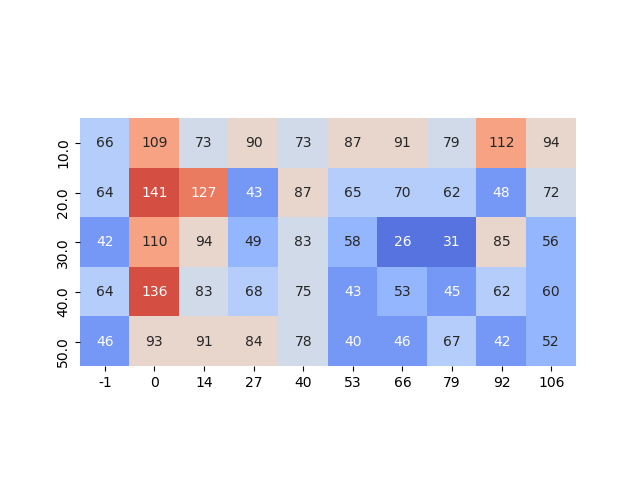

[Text(0.5,0,u'-1'),
 Text(1.5,0,u'0'),
 Text(2.5,0,u'14'),
 Text(3.5,0,u'27'),
 Text(4.5,0,u'40'),
 Text(5.5,0,u'53'),
 Text(6.5,0,u'66'),
 Text(7.5,0,u'79'),
 Text(8.5,0,u'92'),
 Text(9.5,0,u'106')]

In [282]:
fig, ax  = pl.subplots()
sns.heatmap(ncells_arr, ax=ax,cmap=cmap, square=True, fmt='d', annot=True, cbar=0)
ax.set_yticklabels(sizes)
ax.set_xticklabels(morphs)

# Tuning curves - traces

In [22]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00'

In [23]:
visual_area = 'V1'
skey = '-'.join([animalid, session, fov, traceid])
print skey

JC097-20190617-FOV1_zoom2p0x-traces001


In [289]:
roidir = os.path.join(outdir, 'example-cells', '%s_%s' % (visual_area, skey))
if not os.path.exists(roidir):
    os.makedirs(roidir)
print roidir

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00/example-cells/V1_JC097-20190617-FOV1_zoom2p0x-traces001


In [290]:
dff_traces = util.process_traces(exp.data.traces, exp.data.labels, response_type='dff')

In [255]:
sdf = reformat_morph_values(exp.data.sdf)

In [291]:
colormap='coolwarm'

In [292]:
transform_param = 'size'
transform_values = sorted(sdf[transform_param].unique())
hue_param = 'morphlevel'
hue_values = sorted(sdf[hue_param].unique())

hue_colors = sns.color_palette(colormap, n_colors=len(hue_values))
if hue_param == 'morphlevel':
    hue_colors[0] = (0, 0, 0)
    new_colors = sns.color_palette(colormap, n_colors=len(hue_values)-1)
    hue_colors[1:] = new_colors

In [322]:
dff_traces[226]

0        -0.147947
1         0.025260
2        -0.171013
3        -0.176650
4        -0.057790
5        -0.210450
6        -0.080054
7        -0.073232
8         0.238650
9         0.085346
10       -0.089270
11       -0.347348
12        0.044915
13       -0.422096
14        0.243357
15        0.018928
16       -0.250189
17        0.222865
18       -0.245701
19       -0.324695
20        0.085813
21       -0.053728
22        0.591925
23       -0.271210
24        0.032321
25       -0.267312
26        0.196745
27       -0.048955
28        0.363221
29       -0.018704
            ...   
195720    0.393477
195721    0.046501
195722   -0.439590
195723   -0.025137
195724    0.050941
195725   -0.327517
195726    0.342439
195727   -0.252313
195728   -0.214591
195729   -0.105006
195730   -0.135371
195731    0.279420
195732   -0.008203
195733   -0.294454
195734    0.344318
195735   -0.638125
195736         NaN
195737         NaN
195738         NaN
195739         NaN
195740         NaN
195741      

# Plot nice timecourses

<IPython.core.display.Javascript object>


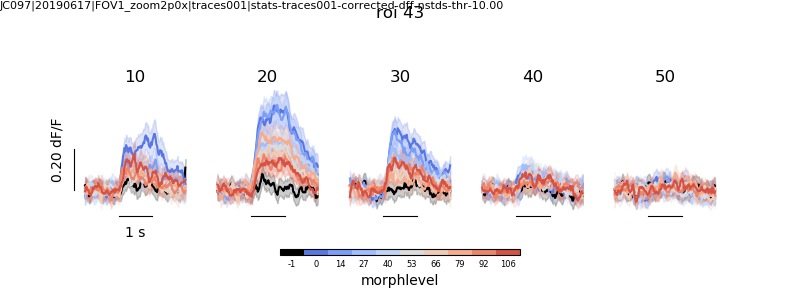

In [331]:
#roi = 234 #196 #183 #155 #138 #106 #93 #80 #69 # 67 # 39 #17 #121 #121 #212 #93 #54
#roi = 124 # 44
roi = 42

if roi not in meanr.T.columns:
    ymax = 0.2
else:
    ymax = 0.2 #round(meanr.T[roi].max() / 2., 1)
min_val, max_val = 0, 0

n_transforms = len(sizes)
fig, axes = pl.subplots(1, len(transform_values), figsize=(8,3), sharex=True)
for hi, hue_value in enumerate(hue_values):
    currcfgs = sdf[sdf[hue_param]==hue_value].index.tolist()
    currlabels = exp.data.labels[exp.data.labels['config'].isin(currcfgs)]
    for cfg, g in currlabels.groupby(['config']):
        currsz = sdf[transform_param][cfg]
        plot_ix = transform_values.index(currsz)
        tsec =  np.nanmean(np.vstack(g.groupby(['trial'])['tsec'].apply(np.array).values), axis=0).astype(float)
        meantrace = np.nanmean(np.array([dff_traces[roi][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0)
        semtrace = spstats.sem(np.array([dff_traces[roi][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0, nan_policy='omit')
        
        st = temporal_downsample(tsec, windowsz)
        sm = temporal_downsample(meantrace, windowsz)
        ss = temporal_downsample(semtrace, windowsz)
    
        axes[plot_ix].plot(st, sm, color=hue_colors[hi], label=hue_value)
        axes[plot_ix].fill_between(st, sm+ss, sm-ss, color=hue_colors[hi], alpha=0.2)
        max_val = max([max_val, (sm+ss).max() ])
        min_val = min( [min_val, (sm-ss).min()])
for ai, (ax, sz) in enumerate(zip(axes.flat, transform_values)):
    ax.set_title(int(sz))
    ax.set_ylim([min_val, max_val])
    ax.tick_params(which='both', axis='both', length=0)
    if ai == 0:
        ax.set_xticks([0, 1])
        ax.set_xticklabels([''])
        ax.set_xlabel('1 s')
        ax.set_yticks([0, ymax])
        ax.set_yticklabels([''])
        ax.set_ylabel('%.2f dF/F' % ymax)
        sns.despine(trim=True, ax=ax, offset=4)
    else:
        sns.despine(trim=True, ax=ax, offset=4, left=True, bottom=False)
        ax.set_yticklabels([''])
        ax.set_yticks([]) 
pl.subplots_adjust(top=0.7, bottom=0.3, left=0.1)
cbar = create_color_bar(fig, hue_colors,  cbar_axes=[0.35, 0.15, 0.3, 0.02])
cbar.ax.set_xticklabels(hue_values, fontsize=6) #(['%i' % i for i in morphlevels])  # horizontal colorbar

fig.suptitle('roi %i' % (int(roi+1)))
label_figure(fig, data_id)
pl.savefig(os.path.join(roidir, 'roi%05d.png' % int(roi+1)))


In [24]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.cm as cm

def create_color_bar(fig, hue_colors, orientation='horizontal', cbar_axes=[0.58, 0.17, 0.3, 0.02]):

    cmap = ListedColormap(hue_colors)
    bounds = np.arange(0, len(hue_values))
    norm = BoundaryNorm(bounds, cmap.N)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array(bounds)

    cbar_ax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(mappable, cax=cbar_ax, boundaries=np.arange(-0.5,len(hue_values),1), \
                        ticks=bounds, norm=norm, orientation='horizontal')
    cbar.ax.tick_params(axis='both', which='both',length=0)
    cbar.ax.set_xticklabels(hue_values, fontsize=6) #(['%i' % i for i in morphlevels])  # horizontal colorbar
    cbar.ax.set_xlabel(hue_param, fontsize=10)

    return cbar

In [25]:
np.linspace(0, 100, 2)


array([  0., 100.])

In [26]:
def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace[0], trace, np.ones(windowsz)*trace[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2


<IPython.core.display.Javascript object>


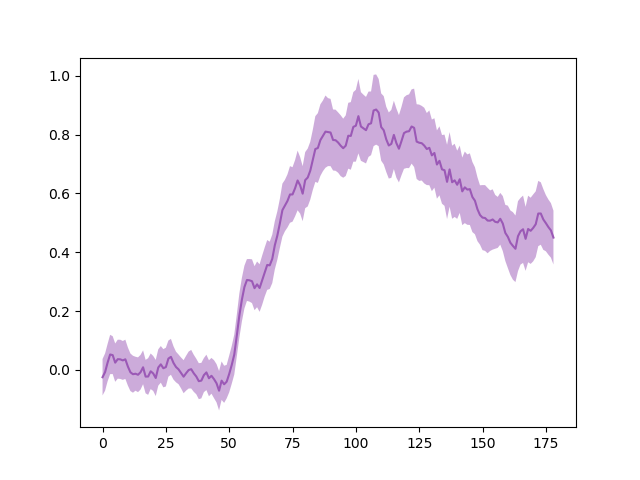

In [113]:
windowsz=5

pl.figure()
meantrace = np.nanmean(np.array([dff_traces[roi][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0)
semtrace = spstats.sem(np.array([dff_traces[roi][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0, nan_policy='omit')

sm = temporal_downsample(meantrace, windowsz)
ss = temporal_downsample(semtrace, windowsz)


pl.plot(sm)
pl.fill_between(range(len(sm)), sm+ss, sm-ss, alpha=0.5)

<IPython.core.display.Javascript object>


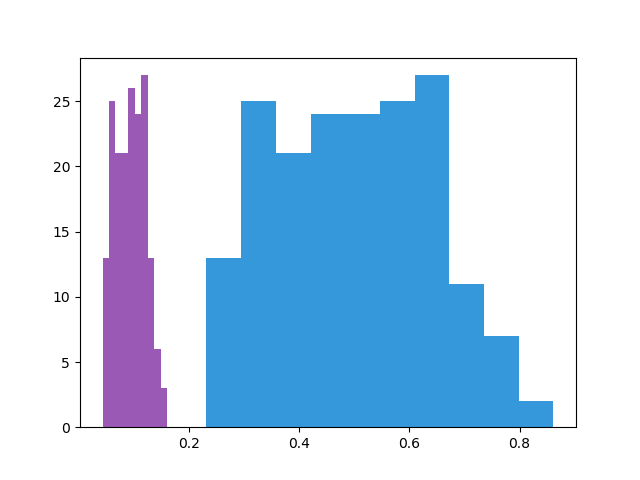

(array([13., 25., 21., 24., 24., 25., 27., 11.,  7.,  2.]),
 array([0.23153647, 0.29454549, 0.3575545 , 0.42056352, 0.48357254,
        0.54658156, 0.60959058, 0.67259959, 0.73560861, 0.79861763,
        0.86162665]),
 <a list of 10 Patch objects>)

In [58]:
pl.figure()
pl.hist(semtrace)
pl.hist(stdtrace)

# Stats?

In [20]:
skey

NameError: name 'skey' is not defined

In [27]:
from statsmodels.stats.anova import AnovaRM 

import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

In [409]:
roi = 38

# dflist = [pd.DataFrame({'response': estats.gdf.get_group(roi).groupby(['config'])['dff'].values,
#               'size': [sdf['size'][c]\
#                        for c in estats.gdf.get_group(roi).groupby(['config']).mean()['dff'].index.tolist()],
#               'morphlevel': [sdf['morphlevel'][c]\
#                        for c in estats.gdf.get_group(roi).groupby(['config']).mean()['dff'].index.tolist()],
#               'cell': [roi for _ in \
#                       range(len(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'].index.tolist()))]})\
#           for roi in estats.rois]
# df2way = pd.concat(dflist)

# Stack trials of config1, then all trials of config2, etc.
n_reps = estats.gdf.get_group(estats.rois[0]).groupby(['config']).count().values[0][0]
n_trials = estats.gdf.get_group(estats.rois[0]).count()[0]

df2way = pd.DataFrame(
    {'response': np.hstack(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).values),
     'size': [sdf['size'][c]\
             for c in np.repeat(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).index.tolist(), n_reps).ravel()],
     'morphlevel': [sdf['morphlevel'][c]\
             for c in np.repeat(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).index.tolist(), n_reps).ravel()],
     'trial': range(n_trials)})# for _ in range(n_trials)]})

In [28]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov


In [29]:
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())

In [30]:
size_colors = sns.cubehelix_palette(len(tested_sizes))

In [31]:
formula = 'response ~ C(size) + C(morphlevel) + C(size):C(morphlevel)'


In [459]:
aovs = {}
models = {}
# Stack trials of config1, then all trials of config2, etc.
for roi in estats.rois:
    n_reps = estats.gdf.get_group(estats.rois[0]).groupby(['config']).count().values[0][0]
    n_trials = estats.gdf.get_group(estats.rois[0]).count()[0]

    df2way = pd.DataFrame(
        {'response': np.hstack(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).values),
         'size': [sdf['size'][c]\
                 for c in np.repeat(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).index.tolist(), n_reps).ravel()],
         'morphlevel': [sdf['morphlevel'][c]\
                 for c in np.repeat(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).index.tolist(), n_reps).ravel()],
         'trial': range(n_trials)})# for _ in range(n_trials)]})
    
    model = ols(formula, df2way).fit()
    aov_table = anova_lm(model, typ=2)
    eta_squared(aov_table)
    omega_squared(aov_table)
    
    aovs[roi] = aov_table
    models[roi] = model
    

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


In [460]:
fvals = pd.DataFrame({'F1': [aov.F[0] for roi, aov in aovs.items()],
                     'F2': [aov.F[1] for roi, aov in aovs.items()],
                     'Fx': [aov.F[2] for roi, aov in aovs.items()]})


<IPython.core.display.Javascript object>


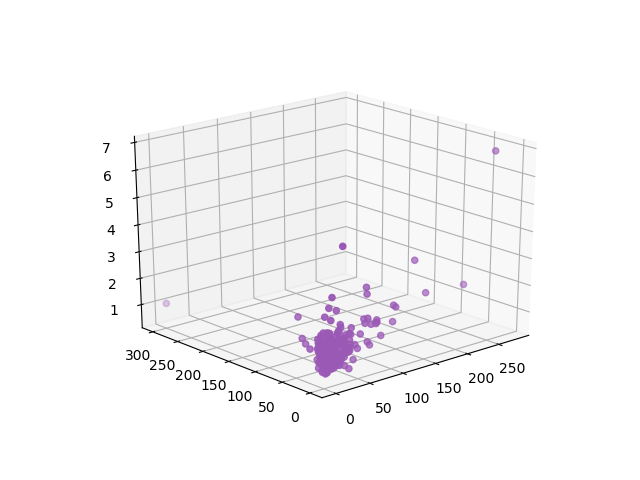

In [464]:

fig = pl.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(fvals['F1'], fvals['F2'], fvals['Fx'])

In [475]:
xd = StandardScaler().fit_transform(fvals)

pca = PCA(n_components=2)
pcar = pca.fit_transform(xd)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.53802441 0.33300204]
[21.10649682 16.60499   ]


<IPython.core.display.Javascript object>


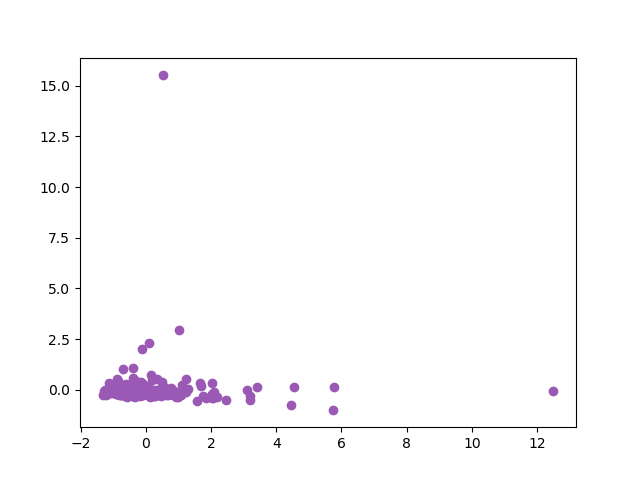

In [476]:
fig, ax = pl.subplots()
ax.scatter(pcar[:,0], pcar[:, 1])

In [454]:
model = ols(formula, df2way).fit()
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)


                          sum_sq      df          F        PR(>F)    eta_sq  \
C(size)                 0.760308     4.0   8.457274  9.657710e-07  0.017518   
C(morphlevel)           9.948049     9.0  49.180875  1.657067e-77  0.229212   
C(size):C(morphlevel)   1.227709    36.0   1.517378  2.608668e-02  0.028288   
Residual               31.464959  1400.0        NaN           NaN       NaN   

                       omega_sq  
C(size)                0.015439  
C(morphlevel)          0.224435  
C(size):C(morphlevel)  0.009640  
Residual                    NaN  


In [71]:
print(aov_table)

                         sum_sq      df         F    PR(>F)    eta_sq  \
C(size)                0.177448     4.0  7.715223  0.000004  0.020552   
C(morphlevel)          0.141150     9.0  2.727579  0.003717  0.016348   
C(size):C(morphlevel)  0.265439    36.0  1.282331  0.123424  0.030744   
Residual               8.049901  1400.0       NaN       NaN       NaN   

                       omega_sq  
C(size)                0.017877  
C(morphlevel)          0.010348  
C(size):C(morphlevel)  0.006764  
Residual                    NaN  


In [72]:
print("Overall model F(%i, %i) = %.3f, p = %.4f" % (model.df_model, model.df_resid, model.fvalue, model.f_pvalue))


Overall model F(49, 1400) = 2.073, p = 0.0000


In [73]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.073
Date:                Fri, 06 Sep 2019   Prob (F-statistic):           2.57e-05
Time:                        12:33:50   Log-Likelihood:                 1707.9
No. Observations:                1450   AIC:                            -3316.
Df Residuals:                    1400   BIC:                            -3052.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0419      0.014      2.977      0.003       0.014       0.070
C(size)[T.20.0]                         -0.0018      0.020     -0.090      0.928      -0.041       0.037
C(size)[T.30.0]                         -0.0174      0.020     -0.874      0.383      -0.056       0.022
C(size)[T.40.0]                         -0.0036      0.020     -0.183      0.855      -0.043       0.035
C(size)[T.50.0]                          0.0037      0.020      0.183      0.854      -0.035       0.043
C(morphlevel)[T.0]                       0.0216      0.020      1.084      0.279      -0.017       0.061
C(morphlevel)[T.14]                      0.0326      0.020      1.635      0.102      -0.007       0.072
C(morphlevel)[T.27]                      0.0409      0.020      2.054      0.040       0.002       0.080
C(morphlevel)[T.40]                      0.0099      0.020      0.499      0.618      -0.029       0.049
C(morphlevel)[T.53]                      0.0119      0.020      0.598      0.550      -0.027       0.051
C(morphlevel)[T.66]                      0.0071      0.020      0.358      0.720      -0.032       0.046
C(morphlevel)[T.79]                      0.0133      0.020      0.668      0.504      -0.026       0.052
C(morphlevel)[T.92]                      0.0254      0.020      1.277      0.202      -0.014       0.064
C(morphlevel)[T.106]                     0.0207      0.020      1.040      0.299      -0.018       0.060
C(size)[T.20.0]:C(morphlevel)[T.0]       0.0514      0.028      1.824      0.068      -0.004       0.107
C(size)[T.30.0]:C(morphlevel)[T.0]       0.0352      0.028      1.250      0.211      -0.020       0.090
C(size)[T.40.0]:C(morphlevel)[T.0]       0.0073      0.028      0.260      0.795      -0.048       0.063
C(size)[T.50.0]:C(morphlevel)[T.0]      -0.0392      0.028     -1.392      0.164      -0.094       0.016
C(size)[T.20.0]:C(morphlevel)[T.14]      0.0054      0.028      0.193      0.847      -0.050       0.061
C(size)[T.30.0]:C(morphlevel)[T.14]      0.0051      0.028      0.182      0.855      -0.050       0.060
C(size)[T.40.0]:C(morphlevel)[T.14]     -0.0165      0.028     -0.587      0.557      -0.072       0.039
C(size)[T.50.0]:C(morphlevel)[T.14]     -0.0377      0.028     -1.340      0.180      -0.093       0.018
C(size)[T.20.0]:C(morphlevel)[T.27]     -0.0192      0.028     -0.680      0.496      -0.074       0.036
C(size)[T.30.0]:C(morphlevel)[T.27]     -0.0194      0.028     -0.688      0.492      -0.075       0.036
C(size)[T.40.0]:C(morphlevel)[T.27]     -0.0150      0.028     -0.533      0.594      -0.070       0.040
C(size)[T.50.0]:C(morphlevel)[T.27]     -0.0378      0.028     -1.343      0.180      -0.093       0.017
C(size)[T.20.0]:C(morphlevel)[T.40]   

In [74]:
model.df_resid

1400.0

<IPython.core.display.Javascript object>


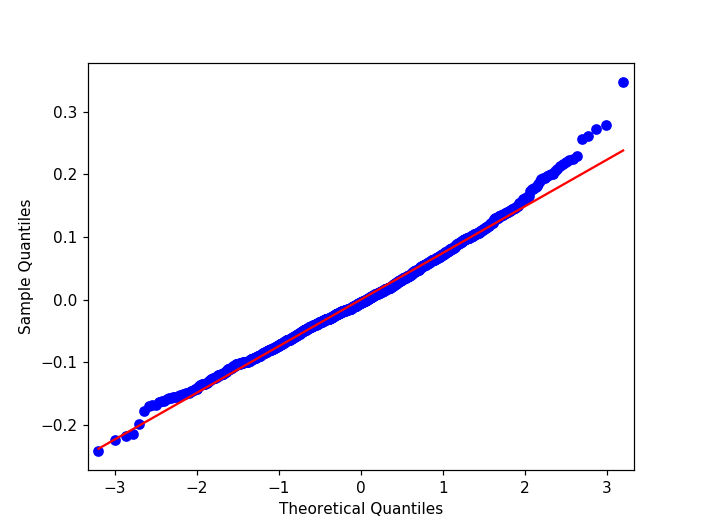

In [75]:
res = model.resid 
fig = sm.qqplot(res, line='s')
pl.show()

In [35]:
isinstance(aov_table, pd.DataFrame)

True

In [67]:
aovs = {}
models = {}
dfs = {}

In [68]:
currdata = dsets[dsets['visual_area']=='V1']

for si, ((animalid, session, fov), g) in enumerate(currdata.groupby(['animalid', 'session', 'fov'])):
    skey = '-'.join([animalid, session, fov]
                   )
    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    # Get stimulus conditions
    sdf = exp.get_stimuli()
    sdf = reformat_morph_values(sdf)
    sizes = np.array(sorted(sdf['size'].unique()))
    morphs = np.array(sorted(sdf['morphlevel'].unique()))

    n_sizes = len(sdf['size'].unique())
    n_morphs = len(sdf['morphlevel'].unique()) 
    if n_sizes != n_sz or n_morphs != n_mp:
        incorrect_nvalues.append(skey)
        pass

    rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
    rstats = rstats['nframes_above']

    # Get metrics for each condition
    estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
    meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                       for roi in estats.rois], axis=1).T

    # Get ROI list
    if threshold_dff:
        rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
    else:
        rois_plot = meanr.index.tolist()
        
        
    for roi in rois_plot: #estats.rois:
        n_reps = estats.gdf.get_group(estats.rois[0]).groupby(['config']).count().values[0][0]
        n_trials = estats.gdf.get_group(estats.rois[0]).count()[0]

        df2way = pd.DataFrame(
            {'response': np.hstack(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).values),
             'size': [sdf['size'][c]\
                     for c in np.repeat(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).index.tolist(), n_reps).ravel()],
             'morphlevel': [sdf['morphlevel'][c]\
                     for c in np.repeat(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).index.tolist(), n_reps).ravel()],
             'trial': range(n_trials)})# for _ in range(n_trials)]})

        model = ols(formula, df2way).fit()
        aov_table = anova_lm(model, typ=2)
        eta_squared(aov_table)
        omega_squared(aov_table)

        aovs['%s_%i' % (skey, roi)] = aov_table
        models['%s_%i' % (skey, roi)] = model
        dfs['%s_%i' % (skey, roi)] = df2way
        


... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/2019

In [69]:
with open(os.path.join(outdir, 'aov-results.pkl'), 'wb') as f:
    pkl.dump({'aovs': aovs, 'models': models, 'dfs': dfs}, f, protocol=pkl.HIGHEST_PROTOCOL)
    

In [ ]:
#np.hstack(estats.gdf.get_group(roi).groupby(['config'])['dff'].apply(np.array).values)

In [100]:

animalid = 'JC097'
session = '20190617'
fov = 'FOV1_zoom2p0x'
roi = 64

rkey = '%s_%i' % ('-'.join([animalid, session, fov]), roi)

aov = aovs[rkey]
model = models[rkey]
df2way = dfs[rkey]


In [101]:
df2way['response'].max()

2.742979527292013

In [108]:
roi

64

In [103]:
import itertools

In [116]:
anova_opts = list(itertools.product([True, False], repeat=3))
anova_colors = sns.color_palette('cubehelix', n_colors=len(anova_opts))
colors = [anova_colors[anova_opts.index(tuple(aov.iloc[0:3]['PR(>F)']<0.05))] for roi, aov in aovs.items()]
print len(colors)

1771


In [109]:
for roi, aov in aovs.items():
    print roi, tuple(aov.iloc[0:3]['PR(>F)']<0.05)

JC097-20190617-FOV1_zoom2p0x_12 (True, True, True)
JC097-20190617-FOV1_zoom2p0x_13 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_10 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_11 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_16 (False, True, False)
JC097-20190617-FOV1_zoom2p0x_17 (False, True, True)
JC076-20190420-FOV1_zoom2p0x_229 (False, True, False)
JC076-20190420-FOV1_zoom2p0x_228 (False, True, False)
JC076-20190420-FOV1_zoom2p0x_227 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_18 (True, True, True)
JC097-20190617-FOV1_zoom2p0x_19 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_223 (True, False, False)
JC097-20190613-FOV1_zoom2p0x_149 (True, True, False)
JC097-20190613-FOV1_zoom2p0x_146 (True, True, True)
JC097-20190613-FOV1_zoom2p0x_145 (True, False, False)
JC097-20190613-FOV1_zoom2p0x_144 (True, True, True)
JC097-20190613-FOV1_zoom2p0x_143 (True, True, False)
JC097-20190613-FOV1_zoom2p0x_142 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_15 (True, False, False)


JC076-20190501-FOV1_zoom2p0x_22 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_65 (True, True, False)
JC083-20190510-FOV1_zoom2p0x_66 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_67 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_68 (True, True, False)
JC083-20190510-FOV1_zoom2p0x_69 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_97 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_96 (False, False, False)
JC076-20190420-FOV1_zoom2p0x_91 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_93 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_92 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_214 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_113 (True, True, True)
JC084-20190522-FOV1_zoom2p0x_112 (True, True, True)
JC084-20190522-FOV1_zoom2p0x_117 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_116 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_119 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_118 (True, True, True)
JC083-20190507-FOV1_zoom2p0x_175 (True, True, True)
JC083-201

JC085-20190622-FOV1_zoom2p0x_222 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_225 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_224 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_227 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_9 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_5 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_4 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_7 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_6 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_0 (False, True, False)
JC083-20190510-FOV1_zoom2p0x_3 (False, True, False)
JC083-20190510-FOV1_zoom2p0x_2 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_304 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_301 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_300 (True, True, False)
JC083-20190507-FOV1_zoom2p0x_179 (True, True, True)
JC097-20190617-FOV1_zoom2p0x_302 (True, True, False)
JC097-20190616-FOV1_zoom2p0x_154 (True, True, True)
JC097-20190616-FOV1_zoom2p0x_157 (True, True, True)
JC097-20190616-FO

JC076-20190420-FOV1_zoom2p0x_61 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_69 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_148 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_145 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_147 (True, True, True)
JC084-20190522-FOV1_zoom2p0x_140 (True, True, True)
JC084-20190522-FOV1_zoom2p0x_141 (True, True, True)
JC084-20190522-FOV1_zoom2p0x_142 (True, True, True)
JC084-20190522-FOV1_zoom2p0x_143 (True, True, False)
JC076-20190501-FOV1_zoom2p0x_79 (True, True, True)
JC076-20190501-FOV1_zoom2p0x_75 (False, True, True)
JC076-20190501-FOV1_zoom2p0x_74 (True, True, True)
JC076-20190501-FOV1_zoom2p0x_77 (True, True, False)
JC076-20190501-FOV1_zoom2p0x_76 (False, True, True)
JC076-20190501-FOV1_zoom2p0x_71 (False, True, False)
JC076-20190501-FOV1_zoom2p0x_73 (True, True, True)
JC076-20190501-FOV1_zoom2p0x_72 (True, False, True)
JC085-20190622-FOV1_zoom2p0x_16 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_15 (True, True, True)
JC085-2019062

JC076-20190501-FOV1_zoom2p0x_90 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_99 (False, False, False)
JC076-20190420-FOV1_zoom2p0x_47 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_45 (True, False, False)
JC076-20190420-FOV1_zoom2p0x_42 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_43 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_40 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_128 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_31 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_124 (False, True, True)
JC085-20190622-FOV1_zoom2p0x_33 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_32 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_35 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_37 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_36 (True, True, True)
JC097-20190613-FOV1_zoom2p0x_63 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_38 (False, False, False)
JC097-20190613-FOV1_zoom2p0x_61 (True, True, False)
JC097-20190613-FOV1_zoom2p0x_67 (True, False, True)
JC097-2019061

JC097-20190617-FOV1_zoom2p0x_79 (True, True, True)
JC084-20190522-FOV1_zoom2p0x_188 (False, False, False)
JC084-20190522-FOV1_zoom2p0x_180 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_181 (True, True, False)
JC084-20190522-FOV1_zoom2p0x_183 (True, True, True)
JC084-20190522-FOV1_zoom2p0x_184 (True, False, False)
JC076-20190420-FOV1_zoom2p0x_29 (False, True, False)
JC076-20190420-FOV1_zoom2p0x_20 (True, False, False)
JC076-20190420-FOV1_zoom2p0x_21 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_22 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_24 (True, True, False)
JC076-20190420-FOV1_zoom2p0x_25 (True, True, True)
JC076-20190420-FOV1_zoom2p0x_26 (True, True, False)
JC097-20190613-FOV1_zoom2p0x_45 (True, True, False)
JC097-20190613-FOV1_zoom2p0x_44 (True, True, True)
JC097-20190613-FOV1_zoom2p0x_47 (True, True, True)
JC097-20190613-FOV1_zoom2p0x_46 (True, True, False)
JC097-20190613-FOV1_zoom2p0x_41 (True, True, False)
JC097-20190613-FOV1_zoom2p0x_40 (True, True, False)
JC097-2

JC084-20190522-FOV1_zoom2p0x_28 (True, True, False)
JC097-20190616-FOV1_zoom2p0x_341 (True, True, False)
JC097-20190616-FOV1_zoom2p0x_342 (False, True, False)
JC097-20190616-FOV1_zoom2p0x_346 (True, True, False)
JC097-20190616-FOV1_zoom2p0x_347 (False, True, False)
JC076-20190420-FOV1_zoom2p0x_98 (True, True, True)
JC097-20190613-FOV1_zoom2p0x_69 (True, True, False)
JC097-20190613-FOV1_zoom2p0x_68 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_39 (True, False, False)
JC084-20190522-FOV1_zoom2p0x_208 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_39 (False, False, False)
JC083-20190510-FOV1_zoom2p0x_38 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_37 (True, False, True)
JC083-20190510-FOV1_zoom2p0x_36 (True, True, False)
JC083-20190510-FOV1_zoom2p0x_35 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_32 (True, True, True)
JC097-20190617-FOV1_zoom2p0x_23 (False, True, True)
JC097-20190617-FOV1_zoom2p0x_21 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_20 (True, False, False)
JC097-2

JC097-20190617-FOV1_zoom2p0x_354 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_355 (True, True, True)
JC097-20190617-FOV1_zoom2p0x_353 (False, True, True)
JC097-20190616-FOV1_zoom2p0x_108 (True, True, True)
JC097-20190616-FOV1_zoom2p0x_109 (True, True, False)
JC097-20190616-FOV1_zoom2p0x_106 (True, True, False)
JC097-20190616-FOV1_zoom2p0x_105 (True, True, False)
JC097-20190616-FOV1_zoom2p0x_102 (True, True, True)
JC097-20190616-FOV1_zoom2p0x_103 (True, True, True)
JC097-20190616-FOV1_zoom2p0x_100 (True, True, False)
JC097-20190616-FOV1_zoom2p0x_101 (True, True, False)
JC083-20190507-FOV1_zoom2p0x_120 (True, True, True)
JC083-20190507-FOV1_zoom2p0x_121 (True, True, True)
JC083-20190507-FOV1_zoom2p0x_122 (True, True, True)
JC083-20190507-FOV1_zoom2p0x_124 (True, True, False)
JC083-20190507-FOV1_zoom2p0x_125 (True, True, True)
JC083-20190507-FOV1_zoom2p0x_126 (True, True, True)
JC083-20190507-FOV1_zoom2p0x_127 (True, True, True)
JC083-20190507-FOV1_zoom2p0x_128 (True, True, True)
JC08

JC083-20190510-FOV1_zoom2p0x_132 (True, True, True)
JC083-20190510-FOV1_zoom2p0x_131 (False, True, True)
JC076-20190501-FOV1_zoom2p0x_150 (True, True, True)
JC097-20190617-FOV1_zoom2p0x_249 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_210 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_211 (True, True, True)
JC085-20190622-FOV1_zoom2p0x_213 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_214 (False, False, False)
JC085-20190622-FOV1_zoom2p0x_215 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_216 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_217 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_218 (True, True, False)
JC085-20190622-FOV1_zoom2p0x_219 (True, True, False)
JC083-20190511-FOV1_zoom2p0x_166 (True, True, True)
JC097-20190617-FOV1_zoom2p0x_339 (False, True, False)
JC097-20190617-FOV1_zoom2p0x_336 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_330 (True, False, False)
JC097-20190617-FOV1_zoom2p0x_331 (True, True, False)
JC097-20190617-FOV1_zoom2p0x_333 (True, True, F

1771


In [107]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df2way['size'], df2way['morphlevel'])
mc_results = mc.tukeyhsd()
print(mc_results)



Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  -1     0      0.0    -5.2812 5.2812 False 
  -1     14     0.0    -5.2812 5.2812 False 
  -1     27     0.0    -5.2812 5.2812 False 
  -1     40     0.0    -5.2812 5.2812 False 
  -1     53     0.0    -5.2812 5.2812 False 
  -1     66     0.0    -5.2812 5.2812 False 
  -1     79     0.0    -5.2812 5.2812 False 
  -1     92     0.0    -5.2812 5.2812 False 
  -1    106     0.0    -5.2812 5.2812 False 
  0      14     0.0    -5.2812 5.2812 False 
  0      27     0.0    -5.2812 5.2812 False 
  0      40     0.0    -5.2812 5.2812 False 
  0      53     0.0    -5.2812 5.2812 False 
  0      66     0.0    -5.2812 5.2812 False 
  0      79     0.0    -5.2812 5.2812 False 
  0      92     0.0    -5.2812 5.2812 False 
  0     106     0.0    -5.2812 5.2812 False 
  14     27     0.0    -5.2812 5.2812 False 
  14     40     0.0    -5.2812 5.2812 False 
  14

In [41]:
fvals = pd.DataFrame({'F1': [aov.F[0] for roi, aov in aovs.items()],
                     'F2': [aov.F[1] for roi, aov in aovs.items()],
                     'Fx': [aov.F[2] for roi, aov in aovs.items()]})


In [42]:
fvals.shape

(1772, 3)

<IPython.core.display.Javascript object>


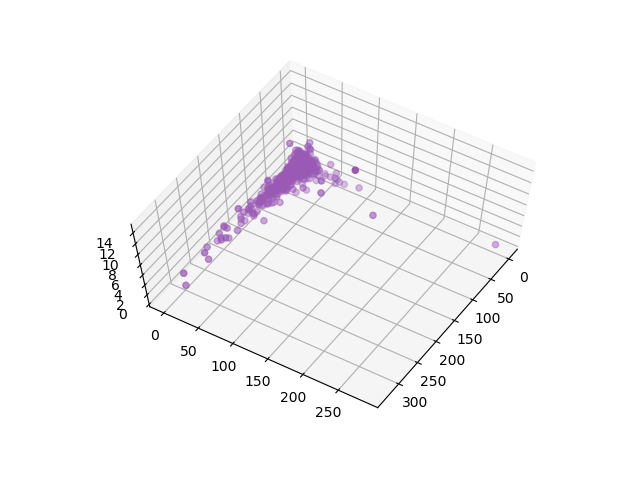

In [43]:

fig = pl.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(fvals['F1'], fvals['F2'], fvals['Fx'])

In [44]:
xd = StandardScaler().fit_transform(fvals)

pca = PCA(n_components=2)
pcar = pca.fit_transform(xd)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.55469427 0.29196013]
[54.30243787 39.39619316]


<IPython.core.display.Javascript object>


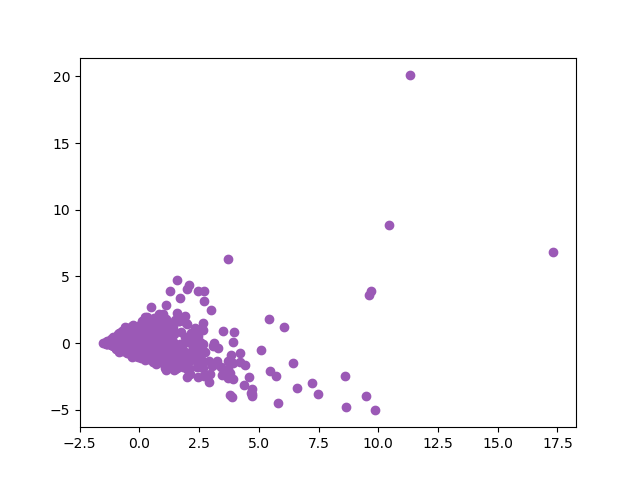

In [45]:
fig, ax = pl.subplots()
ax.scatter(pcar[:,0], pcar[:, 1])

In [47]:

from matplotlib.ticker import NullFormatter
from sklearn import manifold
from time import time

<IPython.core.display.Javascript object>


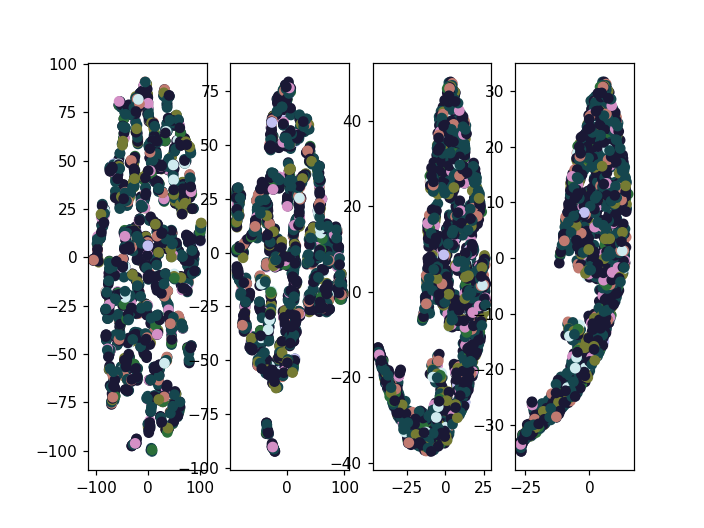

In [121]:
perplexities = [5, 10, 50, 100]
fig, axes = pl.subplots(1,len(perplexities))
for ax, perplexity in zip(axes.flat, perplexities):

    tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(fvals)
    ax.scatter(Y[:, 0], Y[:, 1], c=colors)

<IPython.core.display.Javascript object>


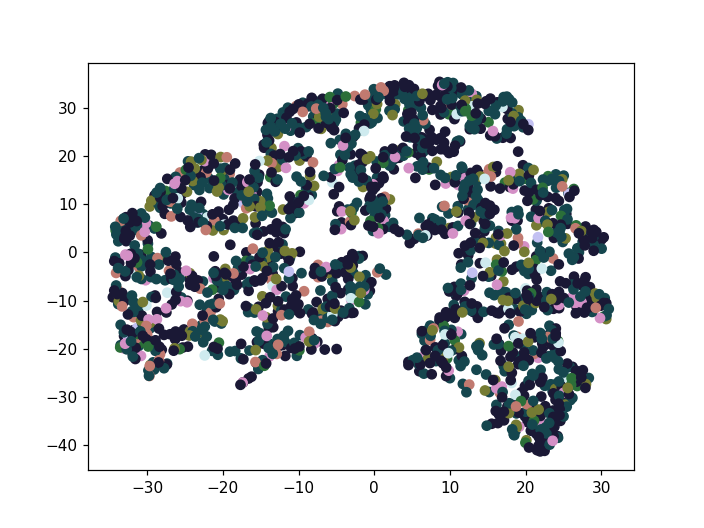

In [57]:
fvals.shape

(1772, 3)